## imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import time
import xgboost as xgb
import lightgbm as lgb
import category_encoders as cat_ed
import gc, mlcrate, glob

from fastai.imports import *
from fastai.structured import *
from gplearn.genetic import SymbolicTransformer
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from IPython.display import display
from catboost import CatBoostClassifier
from scipy.cluster import hierarchy as hc
from collections import Counter

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score, roc_auc_score, log_loss
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.decomposition import PCA, TruncatedSVD, FastICA, FactorAnalysis
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.cluster import KMeans

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

# will ignore all warning from sklearn, seaborn etc..
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

pd.option_context("display.max_rows", 20);
pd.option_context("display.max_columns", 20);

In [3]:
PATH = os.getcwd();
PATH

'D:\\Github\\fastai\\courses\\ml1'

In [4]:
# df_raw_1 = pd.read_csv(f'{PATH}\\AV_Stud_2\\train.csv', low_memory=False)
# df_test_1 = pd.read_csv(f'{PATH}\\AV_Stud_2\\test.csv', low_memory=False)

# df_raw['last_new_job'] = df_raw_1['last_new_job']
# df_test['last_new_job'] = df_test_1['last_new_job']

# del df_raw_1, df_test_1

In [5]:
df_raw = pd.read_csv(f'{PATH}\\AV_Stud_2\\train.csv', low_memory=False)
df_test = pd.read_csv(f'{PATH}\\AV_Stud_2\\test.csv', low_memory=False)

stack_train_1 = pd.read_csv(f'{PATH}\\AV_Stud_2\\stack_train.csv')
stack_test_1 = pd.read_csv(f'{PATH}\\AV_Stud_2\\stack_test.csv')

# stack_train_2 = pd.read_csv(f'{PATH}\\AV_Stud_2\\stack_train_2.csv')
# stack_test_2 = pd.read_csv(f'{PATH}\\AV_Stud_2\\stack_test_2.csv')

train_67 = np.load(f'{PATH}\\AV_Stud_2\\train_67.npy')
test_67 = np.load(f'{PATH}\\AV_Stud_2\\test_67.npy')

# drop enrollee id

In [6]:
target = stack_train_1.target
stack_train_1.drop('target', axis=1, inplace=True)
df_raw.drop(['target'],axis=1,inplace=True)
#df_test.drop('enrollee_id', axis=1,inplace=True)

## cleaning a bit

In [7]:
#target = df_raw.target.values
drop_col = ['enrollee_id']
df_raw.drop(drop_col, axis=1,inplace=True)
df_test.drop(drop_col, axis=1, inplace=True)

In [9]:
cols = ['city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'enrolled_university_degree',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours']
df_raw.columns = cols
df_test.columns = cols

In [8]:
for c in df_raw.columns:
    n = df_raw[c].nunique()
    print(c)
    if n <= 8:
        print(n, sorted(df_raw[c].value_counts().to_dict().items()))
    else:
        print(n)
    print(120 * '-')

city
123
------------------------------------------------------------------------------------------------------------------------
city_development_index
93
------------------------------------------------------------------------------------------------------------------------
gender
3 [('Female', 1188), ('Male', 12884), ('Other', 189)]
------------------------------------------------------------------------------------------------------------------------
relevent_experience
2 [('Has relevent experience', 13596), ('No relevent experience', 4763)]
------------------------------------------------------------------------------------------------------------------------
enrolled_university
3 [('Full time course', 3187), ('Part time course', 1171), ('no_enrollment', 13659)]
------------------------------------------------------------------------------------------------------------------------
enrolled_university_degree
5 [('Graduate', 10769), ('High School', 2032), ('Masters', 4319), ('Phd', 

## city and city_dev col's

In [10]:
#clean city split
df_raw['city'] = df_raw['city'].str.split('_',expand=True)[1]
df_raw['city'] = df_raw['city'].astype('int32')

df_test['city'] = df_test['city'].str.split('_',expand=True)[1]
df_test['city'] = df_test['city'].astype('int32')

In [11]:
df_raw['is_city_in_103_21_116_114_160'] = np.full(df_raw.shape[0], 0)
my_query = df_raw[(df_raw['city'] == 103)|(df_raw['city'] == 21) | (df_raw['city'] == 16) | (df_raw['city'] == 114) | (df_raw['city'] == 160)].index
df_raw.iloc[my_query, -1] = 1

In [12]:
df_test['is_city_in_103_21_116_114_160'] = np.full(df_test.shape[0], 0)

my_query = df_test[(df_test['city'] == 103)|(df_test['city'] == 21) | (df_test['city'] == 16) | (df_test['city'] == 114) | (df_test['city'] == 160)].index
df_test.iloc[my_query, -1] = 1

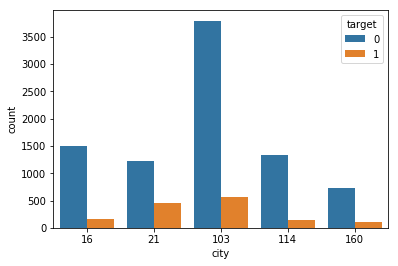

In [32]:
sns.countplot(df_raw[(df_raw['city'] == 103)|(df_raw['city'] == 21) | (df_raw['city'] == 16) |\
       (df_raw['city'] == 114) | (df_raw['city'] == 160)]['city'], data=df_raw, hue='target');

In [43]:
df_raw['city_development_index'].value_counts(ascending=False).head(20).cumsum()

0.920     5185
0.624     6857
0.910     8511
0.926     9983
0.698    10638
0.897    11262
0.939    11806
0.855    12261
0.924    12579
0.804    12892
0.884    13173
0.887    13444
0.754    13708
0.913    13925
0.899    14119
0.802    14307
0.925    14485
0.893    14660
0.878    14816
0.743    14968
Name: city_development_index, dtype: int64

In [13]:
df_raw['is_dev_20'] = np.zeros(df_raw.shape[0])
my_query = df_raw.query('city_development_index<=.2').index
df_raw.iloc[my_query, -1] = 1

df_raw['is_dev_21_30'] = np.zeros(df_raw.shape[0])
my_query = df_raw.query('city_development_index>=.21 & city_development_index<=.3').index
df_raw.iloc[my_query, -1] = 1

df_raw['is_dev_31_40'] = np.zeros(df_raw.shape[0])
my_query = df_raw.query('city_development_index>=.31 & city_development_index<=.4').index
df_raw.iloc[my_query, -1] = 1

df_raw['is_dev_41_50'] = np.zeros(df_raw.shape[0])
my_query = df_raw.query('city_development_index>=.41 & city_development_index<=.5').index
df_raw.iloc[my_query, -1] = 1

df_raw['is_dev_51_60'] = np.zeros(df_raw.shape[0])
my_query = df_raw.query('city_development_index>=.51 & city_development_index<=.6').index
df_raw.iloc[my_query, -1] = 1

df_raw['is_dev_61_70'] = np.zeros(df_raw.shape[0])
my_query = df_raw.query('city_development_index>=.61 & city_development_index<=.7').index
df_raw.iloc[my_query, -1] = 1

df_raw['is_dev_71_80'] = np.zeros(df_raw.shape[0])
my_query = df_raw.query('city_development_index>=.71 & city_development_index<=.8').index
df_raw.iloc[my_query, -1] = 1

df_raw['is_dev_81_90'] = np.zeros(df_raw.shape[0])
my_query = df_raw.query('city_development_index>=.81 & city_development_index<=.9').index
df_raw.iloc[my_query, -1] = 1

df_raw['is_dev_91'] = np.zeros(df_raw.shape[0])
my_query = df_raw.query('city_development_index>=.91').index
df_raw.iloc[my_query, -1] = 1

In [14]:
df_test['is_dev_20'] = np.zeros(df_test.shape[0])
my_query = df_test.query('city_development_index<=.2').index
df_test.iloc[my_query, -1] = 1

df_test['is_dev_21_30'] = np.zeros(df_test.shape[0])
my_query = df_test.query('city_development_index>=.21 & city_development_index<=.3').index
df_test.iloc[my_query, -1] = 1

df_test['is_dev_31_40'] = np.zeros(df_test.shape[0])
my_query = df_test.query('city_development_index>=.31 & city_development_index<=.4').index
df_test.iloc[my_query, -1] = 1

df_test['is_dev_41_50'] = np.zeros(df_test.shape[0])
my_query = df_test.query('city_development_index>=.41 & city_development_index<=.5').index
df_test.iloc[my_query, -1] = 1

df_test['is_dev_51_60'] = np.zeros(df_test.shape[0])
my_query = df_test.query('city_development_index>=.51 & city_development_index<=.6').index
df_test.iloc[my_query, -1] = 1

df_test['is_dev_61_70'] = np.zeros(df_test.shape[0])
my_query = df_test.query('city_development_index>=.61 & city_development_index<=.7').index
df_test.iloc[my_query, -1] = 1

df_test['is_dev_71_80'] = np.zeros(df_test.shape[0])
my_query = df_test.query('city_development_index>=.71 & city_development_index<=.8').index
df_test.iloc[my_query, -1] = 1

df_test['is_dev_81_90'] = np.zeros(df_test.shape[0])
my_query = df_test.query('city_development_index>=.81 & city_development_index<=.9').index
df_test.iloc[my_query, -1] = 1

df_test['is_dev_91'] = np.zeros(df_test.shape[0])
my_query = df_test.query('city_development_index>=.91').index
df_test.iloc[my_query, -1] = 1

In [15]:
df_raw.shape, df_test.shape

((18359, 22), (15021, 22))

## company_size col

In [16]:
# merge both df's
df_raw['min_company_size'] = np.full(df_raw.shape[0], np.nan)
df_raw['max_company_size'] = np.full(df_raw.shape[0], np.nan)

my_query = df_raw[df_raw['company_size'] =='<10'].index
df_raw.iloc[my_query, -2] = 0
df_raw.iloc[my_query, -1] = 9

my_query = df_raw[df_raw['company_size'] =='10/49'].index
df_raw.iloc[my_query, -2] = 10
df_raw.iloc[my_query, -1] = 49

my_query = df_raw[df_raw['company_size'] =='50-99'].index
df_raw.iloc[my_query, -2] = 50
df_raw.iloc[my_query, -1] = 99

my_query = df_raw[df_raw['company_size'] =='100-500'].index
df_raw.iloc[my_query, -2] = 100
df_raw.iloc[my_query, -1] = 500

my_query = df_raw[df_raw['company_size'] =='500-999'].index
df_raw.iloc[my_query, -2] = 500
df_raw.iloc[my_query, -1] = 999

my_query = df_raw[df_raw['company_size'] =='1000-4999'].index
df_raw.iloc[my_query, -2] = 1000
df_raw.iloc[my_query, -1] = 4999

my_query = df_raw[df_raw['company_size'] =='5000-9999'].index
df_raw.iloc[my_query, -2] = 5000
df_raw.iloc[my_query, -1] = 9999

my_query = df_raw[df_raw['company_size'] =='10000+'].index
df_raw.iloc[my_query, -2] = 10000
df_raw.iloc[my_query, -1] = 15000

########################################################################

df_test['min_company_size'] = np.full(df_test.shape[0], -1)
df_test['max_company_size'] = np.full(df_test.shape[0], -1)

my_query = df_test[df_test['company_size'] =='<10'].index
df_test.iloc[my_query, -2] = 0
df_test.iloc[my_query, -1] = 9

my_query = df_test[df_test['company_size'] =='10/49'].index
df_test.iloc[my_query, -2] = 10
df_test.iloc[my_query, -1] = 49

my_query = df_test[df_test['company_size'] =='50-99'].index
df_test.iloc[my_query, -2] = 50
df_test.iloc[my_query, -1] = 99

my_query = df_test[df_test['company_size'] =='100-500'].index
df_test.iloc[my_query, -2] = 100
df_test.iloc[my_query, -1] = 500

my_query = df_test[df_test['company_size'] =='500-999'].index
df_test.iloc[my_query, -2] = 500
df_test.iloc[my_query, -1] = 999

my_query = df_test[df_test['company_size'] =='1000-4999'].index
df_test.iloc[my_query, -2] = 1000
df_test.iloc[my_query, -1] = 4999

my_query = df_test[df_test['company_size'] =='5000-9999'].index
df_test.iloc[my_query, -2] = 5000
df_test.iloc[my_query, -1] = 9999

my_query = df_test[df_test['company_size'] =='10000+'].index
df_test.iloc[my_query, -2] = 10000
df_test.iloc[my_query, -1] = 15000

# df_raw.drop('company_size', axis=1, inplace=True)
# df_test.drop('company_size', axis=1, inplace=True)

# fill na's now wrt to exp level (to do) ####################################################

#df_raw['company_size'].fillna(df_raw.groupby('experience')['company_size'].tranform('median'))
#drop_col.append('company_size')

In [ ]:
sns.countplot(data=df_raw,hue='target', x = 'min_company_size')

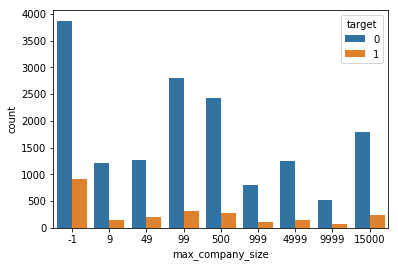

In [58]:
sns.countplot(data=df_raw,hue='target', x = 'max_company_size')

In [ ]:
# df_raw['company_size'].str.split('-', expand=True)

In [ ]:
# df_raw[df_raw['company_size'] =='10/49']['company_size'].str.split('/', expand=True)[1]

## last_new_job col

In [17]:
df_raw['last_new_job'].replace('>4',5, inplace = True)
df_raw['last_new_job'].replace('never',0, inplace = True)
df_raw['last_new_job'] = df_raw['last_new_job'].astype('float32')

df_test['last_new_job'].replace('>4',5, inplace = True)
df_test['last_new_job'].replace('never',0, inplace = True)
df_test['last_new_job'] = df_test['last_new_job'].astype('float32')

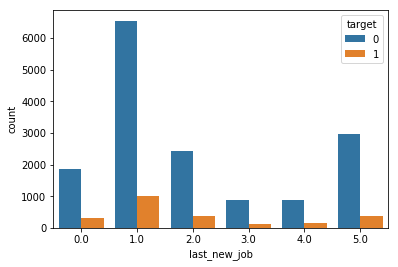

In [63]:
sns.countplot(df_raw['last_new_job'], hue='target', data=df_raw)

In [265]:
df_test['last_new_job'].fillna(method='ffill', inplace=True)

In [18]:
df_raw['last_new_job'].fillna(np.nan, inplace=True)
df_test['last_new_job'].fillna(np.nan, inplace=True)

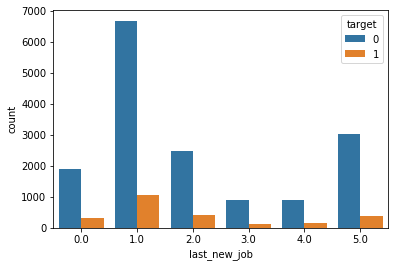

In [65]:
sns.countplot(df_raw['last_new_job'], hue='target', data=df_raw)

## experience col

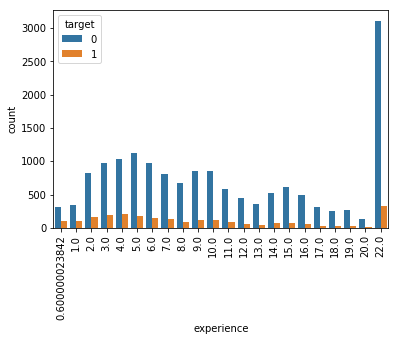

In [77]:
plt.xticks(rotation=90)
sns.countplot('experience', data=df_raw, hue='target',);

In [19]:
df_raw['experience'].replace('>20',22, inplace = True)
df_test['experience'].replace('>20',22, inplace = True)

df_raw['experience'].replace('<1',.6, inplace = True)
df_test['experience'].replace('<1',.6, inplace = True)

df_raw['experience'] = df_raw['experience'].astype('float32')
df_test['experience'] = df_test['experience'].astype('float32')

In [20]:
df_raw['experience'].fillna(np.nan,inplace=True)
df_test['experience'].fillna(np.nan,inplace=True)

## company_type col

In [21]:
df_raw['is_startup'] = np.full(df_raw.shape[0], 0)
my_query = df_raw[(df_raw['company_type'] == 'Funded Startup' )|(df_raw['company_type'] == 'Early Stage Startup')].index
df_raw.iloc[my_query, -1] = 1

df_test['is_startup'] = np.full(df_test.shape[0], 0)
my_query = df_test[(df_test['company_type'] == 'Funded Startup' )|(df_test['company_type'] == 'Early Stage Startup')].index
df_test.iloc[my_query, -1] = 1

In [22]:
df_raw['is_ltd'] = np.full(df_raw.shape[0], 0)
my_query = df_raw[(df_raw['company_type'] == 'Pvt Ltd' )|(df_raw['company_type'] == 'Public Sector')].index
df_raw.iloc[my_query, -1] = 1

df_test['is_ltd'] = np.full(df_test.shape[0], 0)
my_query = df_test[(df_test['company_type'] == 'Pvt Ltd' )|(df_test['company_type'] == 'Public Sector')].index
df_test.iloc[my_query, -1] = 1

In [23]:
df_raw['company_type'].fillna(value=np.nan, axis=0, inplace=True)
df_test['company_type'].fillna(value=np.nan, axis=0, inplace=True)

## gender

In [165]:
df_raw.isnull().sum().sort_values(ascending=False).head()/len(df_raw)

company_size                  0.260308
gender                        0.223215
major_discipline              0.154584
enrolled_university_degree    0.024892
enrolled_university           0.018628
dtype: float64

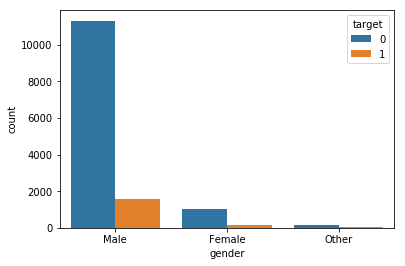

In [161]:
sns.countplot(df_raw['gender'],data=df_raw, hue='target');

In [178]:
df_raw['gender'].value_counts(normalize=True)

Male       0.701781
Unknown    0.223215
Female     0.064709
Other      0.010295
Name: gender, dtype: float64

In [24]:
df_raw1 = df_raw.copy()
df_test1 = df_test.copy()

In [25]:
df_raw['gender'].fillna(value=np.nan, axis=0, inplace=True)
df_test['gender'].fillna(value=np.nan, axis=0, inplace=True)

In [182]:
df_raw.head(2)

,city,city_development_index,gender,relevent_experience,enrolled_university,enrolled_university_degree,major_discipline,experience,company_size,company_type,...,is_dev_41_50,is_dev_51_60,is_dev_61_70,is_dev_71_80,is_dev_81_90,is_dev_91,min_company_size,max_company_size,is_startup,is_ltd
0,149,0.689,Male,Has relevent experience,no_enrollment,Graduate,STEM,3.0,100-500,Pvt Ltd,...,0.0,0.0,1.0,0.0,0.0,0.0,100,500,0,1
1,83,0.923,Male,Has relevent experience,no_enrollment,Graduate,STEM,14.0,<10,Funded Startup,...,0.0,0.0,0.0,0.0,0.0,1.0,0,9,1,0


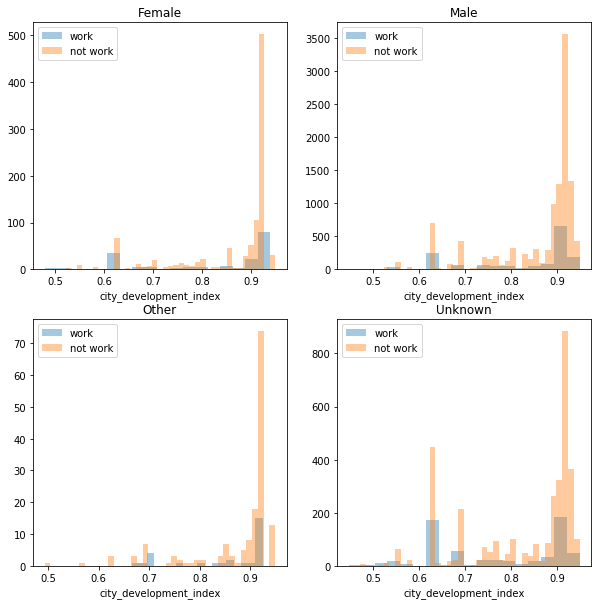

In [197]:
survived = 'work'
not_survived = 'not work'
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(10, 10))

women = df_raw[df_raw['gender']=='Female']
men = df_raw[df_raw['gender']=='Male']
other = df_raw[df_raw['gender']== 'Other']
unknown = df_raw[df_raw['gender']== 'Unknown']

ax = sns.distplot(women[women['target']==1].city_development_index, bins=18, label = survived, ax = axes[0][0], kde =False)
ax = sns.distplot(women[women['target']==0].city_development_index, bins=40, label = not_survived, ax = axes[0][0], kde =False)
ax.legend()
ax.set_title('Female')

ax = sns.distplot(men[men['target']==1].city_development_index, bins=18, label = survived, ax = axes[0][1], kde = False)
ax = sns.distplot(men[men['target']==0].city_development_index, bins=40, label = not_survived, ax = axes[0][1], kde = False)
ax.legend()
ax.set_title('Male')

ax = sns.distplot(other[other['target']==1].city_development_index, bins=18, label = survived, ax = axes[1][0], kde =False)
ax = sns.distplot(other[other['target']==0].city_development_index, bins=40, label = not_survived, ax = axes[1][0], kde =False)
ax.legend()
ax.set_title('Other')

ax = sns.distplot(unknown[unknown['target']==1].city_development_index, bins=18, label = survived, ax = axes[1][1], kde =False)
ax = sns.distplot(unknown[unknown['target']==0].city_development_index, bins=40, label = not_survived, ax = axes[1][1], kde =False)
ax.legend()
_ = ax.set_title('Unknown')

## major discipline

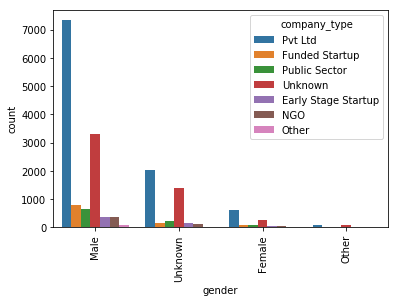

In [177]:
plt.xticks(rotation=90)
sns.countplot('gender', data=df_raw, hue='company_type')

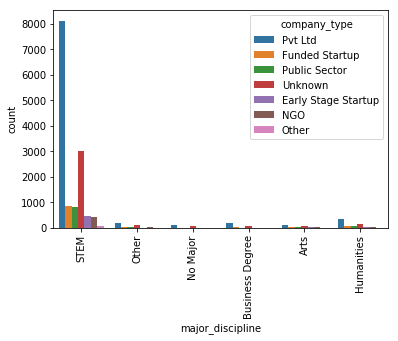

In [180]:
plt.xticks(rotation=90)
sns.countplot('major_discipline', data=df_raw, hue='company_type')

In [26]:
df_raw['unaffliated_college'] = np.zeros(df_raw.shape[0])
df_test['unaffliated_college'] = np.zeros(df_test.shape[0])

for i in ['Phd', 'Graduate', 'Masters', 'High School', 'Primary School']:

    my_query = df_raw[(df_raw['enrolled_university'] == 'no_enrollment') & (df_raw['enrolled_university_degree'] == i)].index
    df_raw.iloc[my_query, -1] = 1
    
    my_query = df_test[(df_test['enrolled_university'] == 'no_enrollment') & (df_test['enrolled_university_degree'] == i)].index
    df_test.iloc[my_query, -1] = 1

df_raw['enroll_type__enroll_deg__major_in'] = df_raw.enrolled_university+'_'+df_raw.enrolled_university_degree\
                                                +'_'+df_raw.major_discipline
df_test['enroll_type__enroll_deg__major_in'] = df_test.enrolled_university+'_'+df_test.enrolled_university_degree\
                                                +'_'+df_test.major_discipline
    
df_raw['gender__major_in'] = df_raw.gender+'_'+df_raw.major_discipline
df_test['gender__major_in'] = df_test.gender+'_'+df_test.major_discipline

df_raw['enroll_deg__major_in'] = df_raw.enrolled_university_degree+'_'+df_raw.major_discipline
df_test['enroll_deg__major_in'] = df_test.enrolled_university_degree+'_'+df_test.major_discipline
    
df_raw['city_dev__max_comp_siz'] = df_raw.city.astype(str)+'_'+df_raw.max_company_size.astype(str)
df_test['city_dev__max_comp_siz'] = df_test.city.astype(str)+'_'+df_test.max_company_size.astype(str)


In [224]:
for i in ['Phd', 'Graduate', 'Masters', 'High School', 'Primary School'] : # enrolled_university_degree
    for j in ['Arts', 'Business Degree', 'Other', 'STEM', 'Humanities', 'No Major']: #major discipline
        print(i,'&&',j,'\nTrain-', df_raw[(df_raw['major_discipline'] == j ) & (df_raw['enrolled_university'] == 'no_enrollment') & (df_raw['enrolled_university_degree'] == i)].shape[0], \
             'Test-',df_test[(df_raw['major_discipline'] == j ) & (df_test['enrolled_university'] == 'no_enrollment') & (df_test['enrolled_university_degree'] == i)].shape[0])

Phd && Arts 
Train- 3 Test- 3
Phd && Business Degree 
Train- 5 Test- 9
Phd && Other 
Train- 5 Test- 6
Phd && STEM 
Train- 378 Test- 276
Phd && Humanities 
Train- 23 Test- 18
Phd && No Major 
Train- 0 Test- 2
Graduate && Arts 
Train- 179 Test- 88
Graduate && Business Degree 
Train- 179 Test- 111
Graduate && Other 
Train- 197 Test- 119
Graduate && STEM 
Train- 6994 Test- 4924
Graduate && Humanities 
Train- 391 Test- 252
Graduate && No Major 
Train- 153 Test- 81
Masters && Arts 
Train- 32 Test- 33
Masters && Business Degree 
Train- 75 Test- 45
Masters && Other 
Train- 76 Test- 64
Masters && STEM 
Train- 3172 Test- 2152
Masters && Humanities 
Train- 203 Test- 106
Masters && No Major 
Train- 23 Test- 39
High School && Arts 
Train- 0 Test- 12
High School && Business Degree 
Train- 0 Test- 14
High School && Other 
Train- 0 Test- 14
High School && STEM 
Train- 0 Test- 628
High School && Humanities 
Train- 0 Test- 39
High School && No Major 
Train- 0 Test- 10
Primary School && Arts 
Train- 0 Te

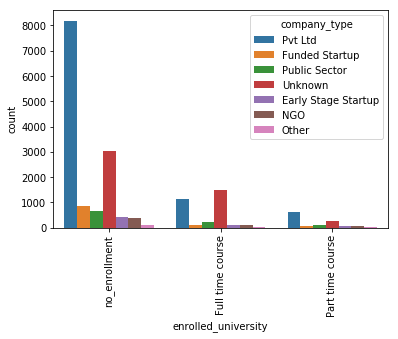

In [172]:
plt.xticks(rotation=90)
sns.countplot('enrolled_university', data=df_raw, hue='company_type')

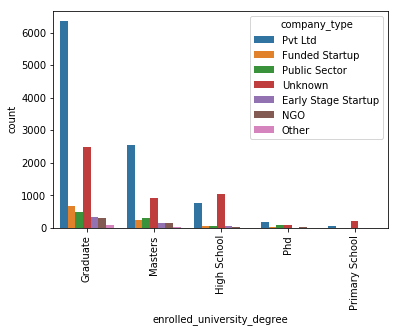

In [173]:
plt.xticks(rotation=90)
sns.countplot('enrolled_university_degree', data=df_raw, hue='company_type')

In [27]:
df_raw['major_discipline'].fillna(np.nan, axis=0, inplace=True)
df_test['major_discipline'].fillna(np.nan, axis=0, inplace=True)

df_raw['enrolled_university'].fillna(np.nan, axis=0, inplace=True)
df_test['enrolled_university'].fillna(np.nan, axis=0, inplace=True)

df_raw['enrolled_university_degree'].fillna(np.nan, axis=0, inplace=True)
df_test['enrolled_university_degree'].fillna(np.nan, axis=0, inplace=True)

In [268]:
df_test['last_new_job'].fillna(0,axis=0,inplace=True)

In [32]:
df_test.isnull().sum().sort_values(ascending=False).head(10)/len(df_test)

gender__major_in                     0.336196
company_type                         0.288263
company_size                         0.269689
gender                               0.225551
enroll_type__enroll_deg__major_in    0.169696
enroll_deg__major_in                 0.159377
major_discipline                     0.159310
enrolled_university_degree           0.026297
last_new_job                         0.020238
enrolled_university                  0.018574
dtype: float64

In [33]:
df_raw.isnull().sum().sort_values(ascending=False).head(10)/len(df_raw)

gender__major_in                     0.333569
company_type                         0.274470
company_size                         0.260308
max_company_size                     0.260308
min_company_size                     0.260308
gender                               0.223215
enroll_type__enroll_deg__major_in    0.164769
enroll_deg__major_in                 0.154584
major_discipline                     0.154584
enrolled_university_degree           0.024892
dtype: float64

## start here

In [34]:
# This way we have randomness and are able to reproduce the behaviour within this cell.
# *****[Helper Script] Comes directly from a kaggle kernel with negligible changes... (not mine)*****

np.random.seed(13)
from sklearn.model_selection import KFold

def impact_coding(data, feature, target='y'):
    '''
    In this implementation we get the values and the dictionary as two different steps.
    This is just because initially we were ignoring the dictionary as a result variable.
    
    In this implementation the KFolds use shuffling. If you want reproducibility the cv 
    could be moved to a parameter.
    '''
    n_folds = 7
    n_inner_folds = 5
    impact_coded = pd.Series()
    
    oof_default_mean = data[target].mean() # Gobal mean to use by default (you could further tune this)
    kf = KFold(n_splits=n_folds, shuffle=True)
    oof_mean_cv = pd.DataFrame()
    split = 0
    for infold, oof in kf.split(data[feature]):
            impact_coded_cv = pd.Series()
            kf_inner = KFold(n_splits=n_inner_folds, shuffle=True)
            inner_split = 0
            inner_oof_mean_cv = pd.DataFrame()
            oof_default_inner_mean = data.iloc[infold][target].mean()
            for infold_inner, oof_inner in kf_inner.split(data.iloc[infold]):
                # The mean to apply to the inner oof split (a 1/n_folds % based on the rest)
                oof_mean = data.iloc[infold_inner].groupby(by=feature)[target].mean()
                impact_coded_cv = impact_coded_cv.append(data.iloc[infold].apply(
                            lambda x: oof_mean[x[feature]]
                                      if x[feature] in oof_mean.index
                                      else oof_default_inner_mean
                            , axis=1))

                # Also populate mapping (this has all group -> mean for all inner CV folds)
                inner_oof_mean_cv = inner_oof_mean_cv.join(pd.DataFrame(oof_mean), rsuffix=inner_split, how='outer')
                inner_oof_mean_cv.fillna(value=oof_default_inner_mean, inplace=True)
                inner_split += 1

            # Also populate mapping
            oof_mean_cv = oof_mean_cv.join(pd.DataFrame(inner_oof_mean_cv), rsuffix=split, how='outer')
            oof_mean_cv.fillna(value=oof_default_mean, inplace=True)
            split += 1
            
            impact_coded = impact_coded.append(data.iloc[oof].apply(
                            lambda x: inner_oof_mean_cv.loc[x[feature]].mean()
                                      if x[feature] in inner_oof_mean_cv.index
                                      else oof_default_mean
                            , axis=1))

    return impact_coded, oof_mean_cv.mean(axis=1), oof_default_mean

In [25]:
df_raw.get_ftype_counts()

category:dense     7
float32:dense      2
float64:dense     12
int32:dense        4
int64:dense        2
dtype: int64

In [28]:
#drop id if original data is imported
#target = df_raw.target.values
#df_raw.drop(['target'],axis=1, inplace=True)
#df_test.drop('id', axis=1, inplace=True)

features = df_raw.columns
numeric_features = []
categorical_features = []
i = 0
index = []
for dtype, feature in zip(df_raw.dtypes, df_raw.columns):

    if dtype == object:
        #print(column)
        #print(train_data[column].describe())
        categorical_features.append(feature)
        index.append(i)
    else:
        numeric_features.append(feature)
    i +=1
train_cats(df_raw);
apply_cats(df_test, df_raw);
categorical_features

['gender',
 'relevent_experience',
 'enrolled_university',
 'enrolled_university_degree',
 'major_discipline',
 'company_size',
 'company_type',
 'enroll_type__enroll_deg__major_in',
 'gender__major_in',
 'enroll_deg__major_in',
 'city_dev__max_comp_siz']

In [36]:
%%time

df_raw['target'] = target
# Apply the encoding to training and test data, and preserve the mapping
impact_coding_map = {}
# for f in categorical_features:
for f in categorical_features:
    print("Impact coding for {}".format(f))
    df_raw["impact_encoded_{}".format(f)], impact_coding_mapping, default_coding = impact_coding(df_raw, f,'target')
    impact_coding_map[f] = (impact_coding_mapping, default_coding)
    mapping, default_mean = impact_coding_map[f]
    df_test["impact_encoded_{}".format(f)] = df_test.apply(lambda x: mapping[x[f]]
                                                                         if x[f] in mapping
                                                                         else default_mean
                                                               , axis=1)

df_raw.drop('target', inplace=True, axis =1);

Impact coding for gender
Impact coding for relevent_experience
Impact coding for enrolled_university
Impact coding for enrolled_university_degree
Impact coding for major_discipline
Impact coding for company_size
Impact coding for company_type
Impact coding for enroll_type__enroll_deg__major_in
Impact coding for gender__major_in
Impact coding for enroll_deg__major_in
Impact coding for city_dev__max_comp_siz
Wall time: 9min 22s


In [29]:
df_raw = pd.get_dummies(df_raw,columns=categorical_features,prefix='dummy')
df_test = pd.get_dummies(df_test,columns=categorical_features,prefix='dummy')

In [30]:
X_train = df_raw.drop(categorical_features,axis=1)  #numeric ones
X_test  = df_test.drop(categorical_features,axis=1) #numeric ones

In [66]:
df_raw[:].fillna(method='ffill', inplace=True)
df_test[:].fillna(method='ffill', inplace=True)

In [ ]:
%%time
N_COMP = 15

print("\nStart decomposition process...")
print("PCA")
pca = PCA(n_components=N_COMP, random_state=17)
pca_results_X_train = pca.fit_transform(X_train)
pca_results_X_test = pca.transform(X_test)

In [ ]:
%%time
print("Append decomposition components to datasets...")

for i in range(1, N_COMP + 1):
    X_train['pca_' + str(i)] = pca_results_X_train[:, i - 1]
    X_test['pca_' + str(i)] = pca_results_X_test[:, i - 1]

In [24]:
def prepare(data_orig):
    data = pd.DataFrame()
    data['mean'] = data_orig.mean(axis=1)
    data['std'] = data_orig.std(axis=1)
    data['min'] = data_orig.min(axis=1)
    data['max'] = data_orig.max(axis=1)
    data['number_of_different'] = data_orig.nunique(axis=1)               # Number of diferent values in a row.
    data['non_zero_count'] = data_orig.fillna(0).astype(bool).sum(axis=1) # Number of non zero values
    return data

# Replace 0 with NaN to ignore them.
X_test_stats = prepare(X_test.replace(0,np.nan))
X_train_stats = prepare(X_train.replace(0, np.nan))

In [ ]:
from sklearn.cluster import KMeans

flist = [x for x in X_train.columns]

flist_kmeans = []
for ncl in range(2,11):
    cls = KMeans(n_clusters=ncl)
    cls.fit_predict(X_train[flist].values)
    X_train['kmeans_cluster_'+str(ncl)] = cls.predict(X_train[flist].values)
    X_test['kmeans_cluster_'+str(ncl)] = cls.predict(X_test[flist].values)
    flist_kmeans.append('kmeans_cluster_'+str(ncl))
print(flist_kmeans)

In [290]:
X_train_stack, X_test_stack = np.hstack((X_train, X_train_stats)), np.hstack((X_test, X_test_stats))

In [31]:
X_train_stack, X_test_stack = np.hstack((df_raw, stack_train_1)), np.hstack((df_test, stack_test_1))

In [71]:
params = {}
params['booster'] = 'gbtree'
params["objective"] = "binary:logistic"
params['eval_metric'] = 'logloss'
#params['eval_metric'] = 'auc'
params["eta"] = 0.05 #0.03
params["subsample"] = .7 #.85 was tried before
params["silent"] = 0
params['verbose'] = 1
params["max_depth"] = 7
params["seed"] = 1
params["max_delta_step"] = 1
params['scale_pos_weight'] =  0.13208780434664197
params["gamma"] = 10 #.5 #.1 #.2
params['colsample_bytree'] = 0.7
params['nrounds'] = 1000 #3600 #2000 #4000 #using lower no for demo
params['missing'] = 0
#params['max_leaves'] = 511
#params['verbose_eval'] = 50

In [72]:
model_xgb, p_train, p_test  = mlcrate.xgb.train_kfold(params, X_train_stack, target, X_test_stack\
                                                       , folds = 7,skip_checks = True, stratify=target, print_imp='final')

[mlcrate] Training 7 stratified XGBoost models on training set (18359, 54) with test set (15021, 54)
[mlcrate] Running fold 0, 15735 train samples, 2624 validation samples
[0]	train-logloss:0.675063	valid-logloss:0.675072
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[1]	train-logloss:0.657603	valid-logloss:0.657621
[2]	train-logloss:0.640766	valid-logloss:0.640793
[3]	train-logloss:0.624551	valid-logloss:0.624587
[4]	train-logloss:0.608955	valid-logloss:0.609
[5]	train-logloss:0.593974	valid-logloss:0.594028
[6]	train-logloss:0.579604	valid-logloss:0.579666
[7]	train-logloss:0.56584	valid-logloss:0.565912
[8]	train-logloss:0.552677	valid-logloss:0.552757
[9]	train-logloss:0.540108	valid-logloss:0.540197
[10]	train-logloss:0.528127	valid-logloss:0.528225
[11]	train-logloss:0.516725	valid-logloss:0.516832
[12]	train-logloss:0.505896	valid-logloss:0.506012
[13]	train-logloss:0.49563	v

C:\ProgramData\Anaconda3\lib\site-packages\mlcrate\backend.py:7: UserWarning: Timer.format_elapsed() has been deprecated in favour of Timer.fsince() and will be removed soon
  warn(message)


[mlcrate] Finished training fold 0 - took 4s - running score 0.390213
[mlcrate] Running fold 1, 15735 train samples, 2624 validation samples
[0]	train-logloss:0.675063	valid-logloss:0.675072
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[1]	train-logloss:0.657603	valid-logloss:0.657621
[2]	train-logloss:0.640766	valid-logloss:0.640793
[3]	train-logloss:0.624551	valid-logloss:0.624587
[4]	train-logloss:0.608955	valid-logloss:0.609
[5]	train-logloss:0.593974	valid-logloss:0.594028
[6]	train-logloss:0.579604	valid-logloss:0.579666
[7]	train-logloss:0.56584	valid-logloss:0.565912
[8]	train-logloss:0.552677	valid-logloss:0.552757
[9]	train-logloss:0.540108	valid-logloss:0.540197
[10]	train-logloss:0.528127	valid-logloss:0.528225
[11]	train-logloss:0.516725	valid-logloss:0.516832
[12]	train-logloss:0.505896	valid-logloss:0.506012
[13]	train-logloss:0.49563	valid-logloss:0.495755
[14]	trai

[61]	train-logloss:0.425194	valid-logloss:0.425227
[62]	train-logloss:0.427351	valid-logloss:0.427352
[63]	train-logloss:0.429539	valid-logloss:0.429533
[64]	train-logloss:0.431746	valid-logloss:0.431716
[65]	train-logloss:0.433912	valid-logloss:0.433845
[66]	train-logloss:0.436087	valid-logloss:0.435996
[67]	train-logloss:0.438287	valid-logloss:0.438153
[68]	train-logloss:0.440403	valid-logloss:0.440244
[69]	train-logloss:0.442584	valid-logloss:0.442397
[70]	train-logloss:0.444669	valid-logloss:0.444476
[71]	train-logloss:0.446631	valid-logloss:0.446435
[72]	train-logloss:0.448625	valid-logloss:0.448397
[73]	train-logloss:0.450535	valid-logloss:0.450265
[74]	train-logloss:0.452489	valid-logloss:0.452178
[75]	train-logloss:0.454873	valid-logloss:0.454572
[76]	train-logloss:0.456638	valid-logloss:0.456289
[77]	train-logloss:0.458491	valid-logloss:0.458102
[78]	train-logloss:0.46027	valid-logloss:0.460057
[79]	train-logloss:0.462037	valid-logloss:0.461785
[80]	train-logloss:0.464143	vali

[31]	train-logloss:0.395275	valid-logloss:0.395037
[32]	train-logloss:0.393654	valid-logloss:0.393409
[33]	train-logloss:0.392371	valid-logloss:0.392119
[34]	train-logloss:0.391415	valid-logloss:0.391155
[35]	train-logloss:0.390774	valid-logloss:0.390506
[36]	train-logloss:0.390438	valid-logloss:0.390163
[37]	train-logloss:0.390393	valid-logloss:0.39011
[38]	train-logloss:0.390264	valid-logloss:0.390051
[39]	train-logloss:0.390354	valid-logloss:0.390224
[40]	train-logloss:0.390654	valid-logloss:0.390545
[41]	train-logloss:0.391181	valid-logloss:0.391086
[42]	train-logloss:0.391857	valid-logloss:0.391851
[43]	train-logloss:0.392733	valid-logloss:0.392746
[44]	train-logloss:0.393724	valid-logloss:0.393837
[45]	train-logloss:0.394898	valid-logloss:0.395026
[46]	train-logloss:0.396147	valid-logloss:0.396377
[47]	train-logloss:0.397517	valid-logloss:0.397761
[48]	train-logloss:0.399054	valid-logloss:0.399404
[49]	train-logloss:0.400673	valid-logloss:0.401048
[50]	train-logloss:0.402424	vali

Will train until valid-logloss hasn't improved in 50 rounds.
[1]	train-logloss:0.657607	valid-logloss:0.657593
[2]	train-logloss:0.640773	valid-logloss:0.640751
[3]	train-logloss:0.624561	valid-logloss:0.624531
[4]	train-logloss:0.608967	valid-logloss:0.60893
[5]	train-logloss:0.593988	valid-logloss:0.593943
[6]	train-logloss:0.57962	valid-logloss:0.579568
[7]	train-logloss:0.565859	valid-logloss:0.565799
[8]	train-logloss:0.552698	valid-logloss:0.552631
[9]	train-logloss:0.540132	valid-logloss:0.540057
[10]	train-logloss:0.528152	valid-logloss:0.528071
[11]	train-logloss:0.516753	valid-logloss:0.516664
[12]	train-logloss:0.505926	valid-logloss:0.50583
[13]	train-logloss:0.495662	valid-logloss:0.495558
[14]	train-logloss:0.485953	valid-logloss:0.485841
[15]	train-logloss:0.476788	valid-logloss:0.476669
[16]	train-logloss:0.468158	valid-logloss:0.468031
[17]	train-logloss:0.460052	valid-logloss:0.459918
[18]	train-logloss:0.45246	valid-logloss:0.452319
[19]	train-logloss:0.445371	valid-

In [73]:
def make_submission(probs):
    sample = pd.read_csv(f'{PATH}\\AV_Stud_2\\sample_submission.csv')
    submit = sample.copy()
    submit['target'] = probs
    return submit

In [32]:
submit = make_submission(p_test)
submit.to_csv(f'{PATH}\\AV_Stud_2\\xgb_with_eid.csv', index=False)
submit.head(2)

# np.save(f'{PATH}\\AV_Stud_2\\xgb_oof_1207.npy', p_train)
# np.save(f'{PATH}\\AV_Stud_2\\raw_train_dummy_impact_train67.npy', X_train_stack)
# np.save(f'{PATH}\\AV_Stud_2\\raw_test_dummy_impact_test67.npy', X_test_stack)

# np.save(f'{PATH}\\AV_Stud_2\\train_no_cat_with_std_pca.npy', df_raw)
# np.save(f'{PATH}\\AV_Stud_2\\test_no_cat_with_std_pca.npy', df_test)

,enrollee_id,target
0,16548,0.229773
1,12036,0.019617


In [272]:
df_raw.to_csv(f'{PATH}\\AV_Stud_2\\clean_train_1207.csv', index=False)
df_test.to_csv(f'{PATH}\\AV_Stud_2\\clean_test_1207.csv', index=False)

In [4]:
train = np.load(f'{PATH}\\AV_Stud_2\\train_dummy_impact_train67.npy')

In [5]:
np.savetxt(f'{PATH}\\AV_Stud_2\\train_dummy_impact_train67.csv',train, delimiter=',')

In [6]:
test = np.load(f'{PATH}\\AV_Stud_2\\test_dummy_impact_test67.npy')
np.savetxt(f'{PATH}\\AV_Stud_2\\test_dummy_impact_train67.csv',test, delimiter=',')

In [15]:
clf_et = ExtraTreesClassifier(criterion='entropy',max_leaf_nodes=0,n_estimators=500,\
                             min_impurity_split=0.0001,n_jobs=4,max_features=0.7,max_depth=8,min_samples_leaf=1,\
                             class_weight='balanced')

In [295]:
stack_test = pd.DataFrame()
stack_train = pd.DataFrame()
log_cols=["Classifier", "Accuracy"]
log = pd.DataFrame(columns=log_cols)

In [ ]:
classifiers = [
    GradientBoostingClassifier(max_depth=8,subsample=0.8,max_features='auto'),
    MLPClassifier(hidden_layer_sizes=(50,25),alpha=1,validation_fraction=0.2),
    ExtraTreesClassifier(100,max_depth=10,n_jobs=-1,class_weight='balanced_subsample',bootstrap=True,oob_score=True),
    DecisionTreeClassifier(min_samples_leaf= 3, class_weight ='balanced', max_features=.85, max_leaf_nodes=5, max_depth = 10),
    RandomForestClassifier(n_estimators=100,max_features=.85, max_leaf_nodes=3,n_jobs=-1,class_weight='balanced'),
    AdaBoostClassifier(),
    LogisticRegression(penalty='l2', C=1.2, fit_intercept=True, intercept_scaling=1, class_weight='balanced', solver='lbfgs', max_iter=500, multi_class='ovr', n_jobs=-1)
    ]

# Logging for Visual Comparison ( see above cell)

for clf in classifiers:    
    name = clf.__class__.__name__
    print("="*60, name)

    models, p_train, p_test, scores = train_k_fold(X_train_stack, target, clf, X_test_stack, 7, target)
    
    stack_test[name] = p_test
    stack_train[name] = p_train
    
    print("Accuracy: {:.4%}".format(np.mean(scores)))
    
    log_entry = pd.DataFrame([[name, np.mean(scores)*100]], columns=log_cols)
    log = log.append(log_entry)
    
    del models, p_train, p_test, scores
    print(gc.collect())

In [ ]:
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")
plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy');

In [298]:
stack_train.to_csv(f'{PATH}\\AV_Stud_2\\stack_train_2.csv', index = False)
stack_test.to_csv(f'{PATH}\\AV_Stud_2\\stack_test_2.csv', index = False)
log.to_csv(f'{PATH}\\AV_Stud_2\\log.csv', index = False)

In [304]:
name = model_xgb[3].__class__.__name__    
stack_test[name] = p_test
stack_train[name] = p_train

In [306]:
_, _, p_test  = mlcrate.xgb.train_kfold(params, stack_train, target, stack_test\
                                                       , folds = 7,skip_checks = True, stratify=target, print_imp='final')

[mlcrate] Training 7 stratified XGBoost models on training set (18359, 8) with test set (15021, 8)
[mlcrate] Running fold 0, 15735 train samples, 2624 validation samples
[0]	train-auc:0.660126	valid-auc:0.669168
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[1]	train-auc:0.664186	valid-auc:0.688596
[2]	train-auc:0.664263	valid-auc:0.6899
[3]	train-auc:0.676224	valid-auc:0.692548
[4]	train-auc:0.677235	valid-auc:0.694662
[5]	train-auc:0.677262	valid-auc:0.694701
[6]	train-auc:0.686145	valid-auc:0.708831
[7]	train-auc:0.686155	valid-auc:0.708793
[8]	train-auc:0.686158	valid-auc:0.708742
[9]	train-auc:0.686152	valid-auc:0.70886
[10]	train-auc:0.686155	valid-auc:0.708861
[11]	train-auc:0.686155	valid-auc:0.708865
[12]	train-auc:0.686125	valid-auc:0.708509
[13]	train-auc:0.686121	valid-auc:0.708477
[14]	train-auc:0.686111	valid-auc:0.70901
[15]	train-auc:0.689476	valid-auc:0.709069
[16]	train-au

C:\ProgramData\Anaconda3\lib\site-packages\mlcrate\backend.py:7: UserWarning: Timer.format_elapsed() has been deprecated in favour of Timer.fsince() and will be removed soon
  warn(message)


[mlcrate] Finished training fold 0 - took 1s - running score 0.711619
[mlcrate] Running fold 1, 15735 train samples, 2624 validation samples
[0]	train-auc:0.646852	valid-auc:0.660876
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[1]	train-auc:0.665349	valid-auc:0.67368
[2]	train-auc:0.667164	valid-auc:0.67754
[3]	train-auc:0.667132	valid-auc:0.677222
[4]	train-auc:0.671255	valid-auc:0.683354
[5]	train-auc:0.671263	valid-auc:0.683036
[6]	train-auc:0.673693	valid-auc:0.688326
[7]	train-auc:0.673664	valid-auc:0.688291
[8]	train-auc:0.675425	valid-auc:0.68961
[9]	train-auc:0.675833	valid-auc:0.690361
[10]	train-auc:0.675836	valid-auc:0.690287
[11]	train-auc:0.675829	valid-auc:0.690363
[12]	train-auc:0.679024	valid-auc:0.696537
[13]	train-auc:0.679006	valid-auc:0.696674
[14]	train-auc:0.679008	valid-auc:0.696632
[15]	train-auc:0.678966	valid-auc:0.69666
[16]	train-auc:0.678994	valid-auc:0.696809

[51]	train-auc:0.725761	valid-auc:0.736586
[52]	train-auc:0.72649	valid-auc:0.736361
[53]	train-auc:0.726877	valid-auc:0.736435
[54]	train-auc:0.727484	valid-auc:0.736563
[55]	train-auc:0.728965	valid-auc:0.7358
[56]	train-auc:0.729948	valid-auc:0.735793
[57]	train-auc:0.730296	valid-auc:0.735659
[58]	train-auc:0.730847	valid-auc:0.736251
[59]	train-auc:0.731944	valid-auc:0.736013
[60]	train-auc:0.732331	valid-auc:0.736665
[61]	train-auc:0.732619	valid-auc:0.737426
[62]	train-auc:0.733172	valid-auc:0.737403
[63]	train-auc:0.733472	valid-auc:0.737173
[64]	train-auc:0.735859	valid-auc:0.736251
[65]	train-auc:0.738535	valid-auc:0.73591
[66]	train-auc:0.738844	valid-auc:0.735817
[67]	train-auc:0.739655	valid-auc:0.734659
[68]	train-auc:0.741083	valid-auc:0.734126
[69]	train-auc:0.741905	valid-auc:0.73483
[70]	train-auc:0.743914	valid-auc:0.734289
[71]	train-auc:0.745829	valid-auc:0.734342
[72]	train-auc:0.745935	valid-auc:0.73509
[73]	train-auc:0.746322	valid-auc:0.735338
[74]	train-auc:0.

[12]	train-auc:0.682071	valid-auc:0.655707
[13]	train-auc:0.682098	valid-auc:0.655674
[14]	train-auc:0.683092	valid-auc:0.655002
[15]	train-auc:0.683277	valid-auc:0.65483
[16]	train-auc:0.683194	valid-auc:0.654784
[17]	train-auc:0.683194	valid-auc:0.654749
[18]	train-auc:0.684265	valid-auc:0.658142
[19]	train-auc:0.685671	valid-auc:0.661257
[20]	train-auc:0.685678	valid-auc:0.661351
[21]	train-auc:0.685752	valid-auc:0.66152
[22]	train-auc:0.685746	valid-auc:0.661513
[23]	train-auc:0.685753	valid-auc:0.661489
[24]	train-auc:0.690137	valid-auc:0.661911
[25]	train-auc:0.690129	valid-auc:0.66192
[26]	train-auc:0.690093	valid-auc:0.662217
[27]	train-auc:0.711458	valid-auc:0.679751
[28]	train-auc:0.711486	valid-auc:0.680175
[29]	train-auc:0.717085	valid-auc:0.682422
[30]	train-auc:0.717109	valid-auc:0.682613
[31]	train-auc:0.717839	valid-auc:0.681492
[32]	train-auc:0.72512	valid-auc:0.690481
[33]	train-auc:0.725651	valid-auc:0.690503
[34]	train-auc:0.727791	valid-auc:0.691364
[35]	train-auc:

[67]	train-auc:0.742741	valid-auc:0.705152
[68]	train-auc:0.743567	valid-auc:0.705198
[69]	train-auc:0.745218	valid-auc:0.705028
[70]	train-auc:0.746125	valid-auc:0.705299
[71]	train-auc:0.746661	valid-auc:0.705775
[72]	train-auc:0.747022	valid-auc:0.706002
[73]	train-auc:0.747723	valid-auc:0.706799
[74]	train-auc:0.74809	valid-auc:0.707078
[75]	train-auc:0.748821	valid-auc:0.707409
[76]	train-auc:0.749608	valid-auc:0.706884
[77]	train-auc:0.750254	valid-auc:0.706877
[78]	train-auc:0.752295	valid-auc:0.706971
[79]	train-auc:0.752873	valid-auc:0.70827
[80]	train-auc:0.754112	valid-auc:0.708586
[81]	train-auc:0.755275	valid-auc:0.708229
[82]	train-auc:0.756296	valid-auc:0.708246
[83]	train-auc:0.757794	valid-auc:0.707941
[84]	train-auc:0.759026	valid-auc:0.707941
[85]	train-auc:0.760528	valid-auc:0.707758
[86]	train-auc:0.761503	valid-auc:0.707777
[87]	train-auc:0.762446	valid-auc:0.707834
[88]	train-auc:0.763358	valid-auc:0.70748
[89]	train-auc:0.763617	valid-auc:0.707118
[90]	train-auc

[118]	train-auc:0.779474	valid-auc:0.728408
[119]	train-auc:0.779594	valid-auc:0.728552
[120]	train-auc:0.780434	valid-auc:0.728811
[121]	train-auc:0.780942	valid-auc:0.728929
[122]	train-auc:0.781611	valid-auc:0.728638
[123]	train-auc:0.782058	valid-auc:0.728213
[124]	train-auc:0.782497	valid-auc:0.728345
[125]	train-auc:0.782695	valid-auc:0.728355
[126]	train-auc:0.783278	valid-auc:0.728187
[127]	train-auc:0.783857	valid-auc:0.728307
[128]	train-auc:0.785357	valid-auc:0.728558
[129]	train-auc:0.786408	valid-auc:0.728605
[130]	train-auc:0.786641	valid-auc:0.728204
[131]	train-auc:0.78699	valid-auc:0.728205
[132]	train-auc:0.78734	valid-auc:0.728547
[133]	train-auc:0.787531	valid-auc:0.728642
[134]	train-auc:0.787674	valid-auc:0.728555
[135]	train-auc:0.788111	valid-auc:0.728288
[136]	train-auc:0.788085	valid-auc:0.728336
[137]	train-auc:0.788301	valid-auc:0.72827
[138]	train-auc:0.788895	valid-auc:0.728084
[139]	train-auc:0.789172	valid-auc:0.728324
[140]	train-auc:0.789289	valid-auc:

In [40]:
# Create parameters to search
gridParams = {
    'learning_rate': [0.05],
    'n_estimators': [100, 150, 250, 500],
    'num_leaves': [255,511],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [501], # Updated from 'seed'
    'colsample_bytree' : [.7, 0.74, 0.75, 0.76, .85],
    'subsample' : [0.7,0.75, .8],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
    }

# Create classifier to use. Note that parameters have to be input manually
# not as a dict!
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt', 
          objective = 'binary', 
          n_jobs = -1, # Updated from 'nthread' 
          silent = False,
          max_depth = 8,
          max_bin = 128, 
          subsample_for_bin = 1,
          subsample = .7, 
          subsample_freq = 1, 
          min_split_gain = .5,  
          scale_pos_weight = 0.1346)

# To view the default model params:
mdl.get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq', 'max_bin', 'scale_pos_weight'])

In [41]:
# Create the grid
grid = GridSearchCV(mdl, gridParams, verbose=1, cv=5, n_jobs=-1)
# Run the grid
grid.fit(X_train_stack, target)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed: 18.0min finished


{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 255, 'objective': 'binary', 'random_state': 501, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.7}
0.867912195653


In [45]:
params = {}

Fitting with params: 
{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'num_leaves': 255, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.7}
Fitting model 0


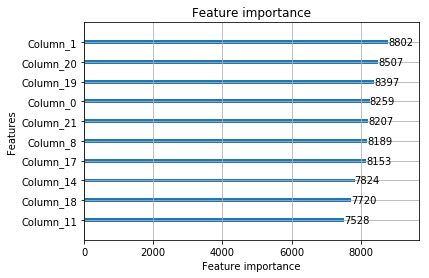

Fitting model 1


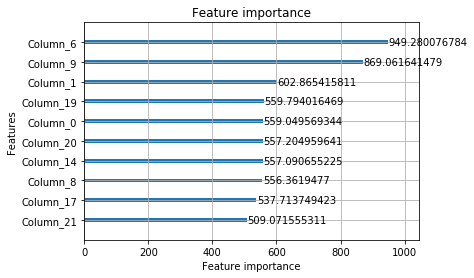

In [46]:
# Using parameters already set above, replace in the best from the grid search
params['colsample_bytree'] = grid.best_params_['colsample_bytree']
params['learning_rate'] = 0.05 
# params['max_bin'] = grid.best_params_['max_bin']
params['num_leaves'] = grid.best_params_['num_leaves']
params['reg_alpha'] = grid.best_params_['reg_alpha']
params['reg_lambda'] = grid.best_params_['reg_lambda']
params['subsample'] = grid.best_params_['subsample']

print('Fitting with params: ')
print(params)

# Kit k models with early-stopping on different training/validation splits
k = 2;
predsValid = 0 
predsTrain = 0
predsTest = 0
l = ['split','gain']
for i in range(0, k): 
    print('Fitting model', i)
    
    # Prepare the data set for fold
    X_train, X_test, y_train, y_test = train_test_split(X_train_stack, target, test_size=0.2, random_state=7, shuffle=True)
    
    d_train = lgb.Dataset(X_train, label=y_train)
    d_test = lgb.Dataset(X_test, label=y_test)
    
    # Train     
    gbm = lgb.train(params,
                    d_train, 
                    1000, 
                    verbose_eval=1)

    # Plot importance
    lgb.plot_importance(gbm,max_num_features=10, importance_type=l[i])
    plt.show()

## random

In [45]:
 def train_k_fold(x_train, y_train, model=None, x_test=None, folds=7, stratify=None, random_state=1337):

    assert model is not None, "model can't be none, Please pass your model."
    
    if hasattr(x_train, 'columns'):
        columns = x_train.columns.values
        columns_exists = True
    else:
        columns = np.arange(x_train.shape[1])
        columns_exists = False

    x_train = np.asarray(x_train)
    y_train = np.array(y_train)

    if x_test is not None:
        if columns_exists:
            try:
                x_test = x_test[columns]
            except Exception as e:
                print('x_test columns doesn\'t match x_train columns.')
                raise e
        x_test = np.asarray(x_test)

    assert x_train.shape[1] == x_test.shape[1], "x_train and x_test have different numbers of features."

    print('Training {} {}models on training set {} {}'.format(folds, 'stratified ' if stratify is not None else '',
        x_train.shape, 'with test set {}'.format(x_test.shape) if x_test is not None else 'without a test set'))

    if stratify is not None:
        kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=random_state)
        splits = kf.split(x_train, stratify)
    else:
        kf = KFold(n_splits=folds, shuffle=True, random_state=4242)
        splits = kf.split(x_train)

    p_train = np.zeros_like(y_train, dtype=np.float32)
    ps_test = []
    models = []
    scores = []
    fold_i = 0

    for train_kf, valid_kf in splits:
        
        print('Running fold {}, {} train samples, {} validation samples'.format(fold_i, len(train_kf), len(valid_kf)))
        
        d_train, label_train = x_train[train_kf], y_train[train_kf]
        d_valid, label_valid = x_train[valid_kf], y_train[valid_kf]

        mdl = model.fit(d_train,label_train)
        scores.append(mdl.score(d_valid, label_valid))
        print('Finished training fold {} - running score {} '.format(fold_i, np.mean(scores)))

        # Get predictions from the model 

        if hasattr(mdl,'predict_proba'):
            #print('Using model.predict_proba')
            p_valid = mdl.predict_proba(d_valid)[:,1]
            if x_test is not None:
                p_test = mdl.predict_proba(x_test)[:,1]
        else:
            #print('Using model.predict')
            p_valid = mdl.predict(d_valid)
            if x_test is not None:
                p_test = mdl.predict(x_test)

        p_train[valid_kf] = p_valid

        ps_test.append(p_test)
        models.append(mdl)

        fold_i += 1

    if x_test is not None:
        p_test = np.mean(ps_test, axis=0)

    print('Finished training {} models '.format(folds))

    if x_test is None:
        p_test = None

    return models, p_train, p_test, scores

In [46]:
model=CatBoostClassifier(iterations=1020, depth=8, learning_rate=0.06, loss_function= 'Logloss')

In [47]:
stack_test = pd.DataFrame()
stack_train = pd.DataFrame()
log_cols=["Classifier", "Accuracy"]
log = pd.DataFrame(columns=log_cols)

In [ ]:
classifiers = [
    model,
#     GradientBoostingClassifier(max_depth=10,subsample=0.8,max_features='auto'),
#     MLPClassifier((50,30,10), alpha=0.01,validation_fraction=0.2),
#     ExtraTreesClassifier(100,max_depth=10,n_jobs=-1,class_weight='balanced_subsample',bootstrap=True,oob_score=True),
#     DecisionTreeClassifier(min_samples_leaf= 3, class_weight ='balanced', max_features=.85, max_leaf_nodes=5, max_depth = 10),
#     RandomForestClassifier(n_estimators=100,max_features=.85,n_jobs=-1,class_weight='balanced'),
#     AdaBoostClassifier(n_estimators=200, learning_rate=0.15),
#     RandomForestClassifier(n_estimators=200,max_features=.85,max_depth=7,n_jobs=-1,class_weight='balanced'),
#     LogisticRegression(class_weight='balanced',max_iter=500, multi_class='ovr', n_jobs=-1),
    ]

# Logging for Visual Comparison ( see above cell)
count = 0
for clf in classifiers:    
    name = clf.__class__.__name__+'{}'.format(count)
    print("="*60, name)

    models, p_train, p_test, scores = train_k_fold( X_train_stack, target, clf, X_test_stack, 7, target)
    
    stack_test[name] = p_test
    stack_train[name] = p_train
    
    print("Accuracy: {:.4%}".format(np.mean(scores)))
    
    log_entry = pd.DataFrame([[name, np.mean(scores)*100]], columns=log_cols)
    log = log.append(log_entry)
    
    del models, p_train, p_test, scores
    
    count += 1
    print(gc.collect())
#     submit = make_submission(p_test)
#     submit.to_csv(f'{PATH}\\AV_Stud_2\\stacked_sklearn_showdown.csv', index=False)
#     submit.head(2)

In [56]:
preds = stack_test['CatBoostClassifier0'].values

In [58]:
submit = make_submission(preds)
submit.to_csv(f'{PATH}\\AV_Stud_2\\cat_with_eid.csv', index=False)
submit.head(2)

,enrollee_id,target
0,16548,0.835014
1,12036,0.060623


## cat

In [104]:
params = {'depth':[7,8,9,10,11],
          'iterations':[500,1000, 1500],
          'learning_rate':[0.05,0.001,0.01,0.1,0.2,0.3], 
          'l2_leaf_reg':[3,1,5,10,100],
          'border_count':[32,5,10,20,50,100,200],
          'thread_count':4,
          'loss_function': 'Logloss'}

# this function does 3-fold crossvalidation with catboostclassifier          
def crossvaltest(params, train_set, train_label, cat_dims, n_splits=3):
    
    kf = KFold(n_splits=n_splits,shuffle=True) 
    res = []
    
    for train_kf, valid_kf in kf.split(train_set):
        
        d_train, label_train = train_set[train_kf], train_label[train_kf]
        d_valid, label_valid = train_set[valid_kf], train_label[valid_kf]
        
        clf = CatBoostClassifier(**params)
        clf.fit(d_train, np.ravel(label_train), cat_features=cat_dims)

        res.append(np.mean(clf.predict_proba(d_valid)==np.ravel(label_valid)))
        
    return np.mean(res)

In [105]:
from fastai.paramsearch import paramsearch
from itertools import product,chain

In [106]:
# this function runs grid search on several parameters

def catboost_param_tune(params, train_set, train_label, cat_dims=None,n_splits=7):
    
    ps = paramsearch(params)
    for prms in chain(ps.grid_search(['border_count']),
                      ps.grid_search(['ctr_border_count']),
                      ps.grid_search(['l2_leaf_reg']),
                      ps.grid_search(['iterations','learning_rate']),
                      ps.grid_search(['depth'])):
        
        res = crossvaltest(prms,train_set,train_label,cat_dims,n_splits)
        
        # save the crossvalidation result so that future iterations can reuse the best parameters
        ps.register_result(res,prms)
        print(res,prms,'best:',ps.bestscore(),ps.bestparam())
    return ps.bestparam()

bestparams = catboost_param_tune(params,X_train_stack,target,cat_dims = None)

0:	learn: 0.6555258	total: 59.3ms	remaining: 29.6s
1:	learn: 0.6220049	total: 113ms	remaining: 28.1s
2:	learn: 0.5925177	total: 157ms	remaining: 26s
3:	learn: 0.5668134	total: 204ms	remaining: 25.2s
4:	learn: 0.5442018	total: 249ms	remaining: 24.6s
5:	learn: 0.5263823	total: 273ms	remaining: 22.4s
6:	learn: 0.5088891	total: 321ms	remaining: 22.6s
7:	learn: 0.4933679	total: 352ms	remaining: 21.7s
8:	learn: 0.4797806	total: 398ms	remaining: 21.7s
9:	learn: 0.4673222	total: 442ms	remaining: 21.6s
10:	learn: 0.4565408	total: 489ms	remaining: 21.7s
11:	learn: 0.4465699	total: 537ms	remaining: 21.8s
12:	learn: 0.4375145	total: 585ms	remaining: 21.9s
13:	learn: 0.4296871	total: 634ms	remaining: 22s
14:	learn: 0.4228363	total: 682ms	remaining: 22.1s
15:	learn: 0.4168044	total: 720ms	remaining: 21.8s
16:	learn: 0.4119076	total: 765ms	remaining: 21.7s
17:	learn: 0.4071547	total: 813ms	remaining: 21.8s
18:	learn: 0.4025505	total: 870ms	remaining: 22s
19:	learn: 0.3989684	total: 919ms	remaining: 2

161:	learn: 0.3360525	total: 7.59s	remaining: 15.8s
162:	learn: 0.3357065	total: 7.64s	remaining: 15.8s
163:	learn: 0.3353975	total: 7.7s	remaining: 15.8s
164:	learn: 0.3350422	total: 7.75s	remaining: 15.7s
165:	learn: 0.3349177	total: 7.8s	remaining: 15.7s
166:	learn: 0.3346401	total: 7.84s	remaining: 15.6s
167:	learn: 0.3342908	total: 7.89s	remaining: 15.6s
168:	learn: 0.3339405	total: 7.93s	remaining: 15.5s
169:	learn: 0.3337419	total: 7.99s	remaining: 15.5s
170:	learn: 0.3337408	total: 8.01s	remaining: 15.4s
171:	learn: 0.3334927	total: 8.06s	remaining: 15.4s
172:	learn: 0.3332240	total: 8.11s	remaining: 15.3s
173:	learn: 0.3329507	total: 8.16s	remaining: 15.3s
174:	learn: 0.3327671	total: 8.21s	remaining: 15.3s
175:	learn: 0.3325518	total: 8.26s	remaining: 15.2s
176:	learn: 0.3324064	total: 8.32s	remaining: 15.2s
177:	learn: 0.3322062	total: 8.37s	remaining: 15.1s
178:	learn: 0.3318439	total: 8.42s	remaining: 15.1s
179:	learn: 0.3316259	total: 8.47s	remaining: 15.1s
180:	learn: 0.

320:	learn: 0.3031235	total: 14.9s	remaining: 8.31s
321:	learn: 0.3028469	total: 14.9s	remaining: 8.26s
322:	learn: 0.3027324	total: 15s	remaining: 8.21s
323:	learn: 0.3025867	total: 15s	remaining: 8.17s
324:	learn: 0.3022303	total: 15.1s	remaining: 8.12s
325:	learn: 0.3019249	total: 15.1s	remaining: 8.07s
326:	learn: 0.3017131	total: 15.2s	remaining: 8.03s
327:	learn: 0.3015267	total: 15.2s	remaining: 7.98s
328:	learn: 0.3013741	total: 15.3s	remaining: 7.93s
329:	learn: 0.3011450	total: 15.3s	remaining: 7.88s
330:	learn: 0.3008589	total: 15.3s	remaining: 7.84s
331:	learn: 0.3007473	total: 15.4s	remaining: 7.79s
332:	learn: 0.3005743	total: 15.4s	remaining: 7.75s
333:	learn: 0.3004361	total: 15.5s	remaining: 7.7s
334:	learn: 0.3002175	total: 15.5s	remaining: 7.65s
335:	learn: 0.3000275	total: 15.6s	remaining: 7.6s
336:	learn: 0.2998749	total: 15.6s	remaining: 7.56s
337:	learn: 0.2995843	total: 15.7s	remaining: 7.51s
338:	learn: 0.2994083	total: 15.7s	remaining: 7.46s
339:	learn: 0.2992

479:	learn: 0.2756953	total: 22.1s	remaining: 921ms
480:	learn: 0.2756092	total: 22.2s	remaining: 875ms
481:	learn: 0.2754372	total: 22.2s	remaining: 829ms
482:	learn: 0.2753178	total: 22.3s	remaining: 783ms
483:	learn: 0.2751240	total: 22.3s	remaining: 738ms
484:	learn: 0.2749592	total: 22.4s	remaining: 691ms
485:	learn: 0.2748678	total: 22.4s	remaining: 645ms
486:	learn: 0.2745674	total: 22.4s	remaining: 599ms
487:	learn: 0.2743312	total: 22.5s	remaining: 553ms
488:	learn: 0.2740604	total: 22.5s	remaining: 507ms
489:	learn: 0.2739735	total: 22.6s	remaining: 461ms
490:	learn: 0.2737847	total: 22.6s	remaining: 415ms
491:	learn: 0.2736537	total: 22.7s	remaining: 369ms
492:	learn: 0.2734175	total: 22.8s	remaining: 323ms
493:	learn: 0.2732242	total: 22.8s	remaining: 277ms
494:	learn: 0.2732186	total: 22.8s	remaining: 231ms
495:	learn: 0.2729624	total: 22.9s	remaining: 185ms
496:	learn: 0.2729593	total: 22.9s	remaining: 138ms
497:	learn: 0.2727166	total: 22.9s	remaining: 92.1ms
498:	learn:

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


0:	learn: 0.6567424	total: 53.6ms	remaining: 26.7s
1:	learn: 0.6230627	total: 127ms	remaining: 31.7s
2:	learn: 0.5939939	total: 180ms	remaining: 29.8s
3:	learn: 0.5685220	total: 230ms	remaining: 28.5s
4:	learn: 0.5453499	total: 284ms	remaining: 28.1s
5:	learn: 0.5264232	total: 315ms	remaining: 25.9s
6:	learn: 0.5082482	total: 360ms	remaining: 25.3s
7:	learn: 0.4920457	total: 403ms	remaining: 24.8s
8:	learn: 0.4777695	total: 447ms	remaining: 24.4s
9:	learn: 0.4652521	total: 489ms	remaining: 24s
10:	learn: 0.4541932	total: 526ms	remaining: 23.4s
11:	learn: 0.4441027	total: 569ms	remaining: 23.1s
12:	learn: 0.4355108	total: 607ms	remaining: 22.7s
13:	learn: 0.4280935	total: 649ms	remaining: 22.5s
14:	learn: 0.4212661	total: 693ms	remaining: 22.4s
15:	learn: 0.4154415	total: 735ms	remaining: 22.2s
16:	learn: 0.4098929	total: 780ms	remaining: 22.1s
17:	learn: 0.4048817	total: 823ms	remaining: 22s
18:	learn: 0.4006988	total: 859ms	remaining: 21.7s
19:	learn: 0.3969329	total: 901ms	remaining:

161:	learn: 0.3349605	total: 7.42s	remaining: 15.5s
162:	learn: 0.3346749	total: 7.48s	remaining: 15.5s
163:	learn: 0.3344611	total: 7.54s	remaining: 15.5s
164:	learn: 0.3341749	total: 7.61s	remaining: 15.5s
165:	learn: 0.3338409	total: 7.68s	remaining: 15.4s
166:	learn: 0.3337506	total: 7.72s	remaining: 15.4s
167:	learn: 0.3335980	total: 7.78s	remaining: 15.4s
168:	learn: 0.3333165	total: 7.83s	remaining: 15.3s
169:	learn: 0.3330845	total: 7.9s	remaining: 15.3s
170:	learn: 0.3328887	total: 7.96s	remaining: 15.3s
171:	learn: 0.3326221	total: 8.02s	remaining: 15.3s
172:	learn: 0.3324196	total: 8.08s	remaining: 15.3s
173:	learn: 0.3321717	total: 8.13s	remaining: 15.2s
174:	learn: 0.3319217	total: 8.19s	remaining: 15.2s
175:	learn: 0.3316902	total: 8.25s	remaining: 15.2s
176:	learn: 0.3313270	total: 8.31s	remaining: 15.2s
177:	learn: 0.3312000	total: 8.37s	remaining: 15.1s
178:	learn: 0.3311694	total: 8.41s	remaining: 15.1s
179:	learn: 0.3309520	total: 8.48s	remaining: 15.1s
180:	learn: 0

320:	learn: 0.3014457	total: 15.7s	remaining: 8.73s
321:	learn: 0.3012120	total: 15.7s	remaining: 8.69s
322:	learn: 0.3010498	total: 15.8s	remaining: 8.64s
323:	learn: 0.3008366	total: 15.8s	remaining: 8.59s
324:	learn: 0.3006781	total: 15.9s	remaining: 8.55s
325:	learn: 0.3005643	total: 15.9s	remaining: 8.5s
326:	learn: 0.3003669	total: 16s	remaining: 8.45s
327:	learn: 0.3001861	total: 16s	remaining: 8.4s
328:	learn: 0.2999412	total: 16.1s	remaining: 8.36s
329:	learn: 0.2997408	total: 16.1s	remaining: 8.31s
330:	learn: 0.2995863	total: 16.2s	remaining: 8.26s
331:	learn: 0.2995008	total: 16.2s	remaining: 8.21s
332:	learn: 0.2992865	total: 16.3s	remaining: 8.17s
333:	learn: 0.2990442	total: 16.3s	remaining: 8.12s
334:	learn: 0.2988398	total: 16.4s	remaining: 8.07s
335:	learn: 0.2986449	total: 16.4s	remaining: 8.03s
336:	learn: 0.2985519	total: 16.5s	remaining: 7.98s
337:	learn: 0.2984019	total: 16.5s	remaining: 7.93s
338:	learn: 0.2980334	total: 16.6s	remaining: 7.88s
339:	learn: 0.2978

479:	learn: 0.2740156	total: 23.4s	remaining: 974ms
480:	learn: 0.2740126	total: 23.4s	remaining: 924ms
481:	learn: 0.2738605	total: 23.4s	remaining: 875ms
482:	learn: 0.2737160	total: 23.5s	remaining: 827ms
483:	learn: 0.2735430	total: 23.5s	remaining: 778ms
484:	learn: 0.2733613	total: 23.6s	remaining: 729ms
485:	learn: 0.2732022	total: 23.6s	remaining: 680ms
486:	learn: 0.2730523	total: 23.7s	remaining: 632ms
487:	learn: 0.2729965	total: 23.7s	remaining: 583ms
488:	learn: 0.2728251	total: 23.8s	remaining: 534ms
489:	learn: 0.2726381	total: 23.8s	remaining: 486ms
490:	learn: 0.2725282	total: 23.8s	remaining: 437ms
491:	learn: 0.2723695	total: 23.9s	remaining: 389ms
492:	learn: 0.2721942	total: 23.9s	remaining: 340ms
493:	learn: 0.2720649	total: 24s	remaining: 291ms
494:	learn: 0.2719348	total: 24s	remaining: 243ms
495:	learn: 0.2717207	total: 24.1s	remaining: 194ms
496:	learn: 0.2715407	total: 24.1s	remaining: 146ms
497:	learn: 0.2712790	total: 24.2s	remaining: 97.2ms
498:	learn: 0.2

140:	learn: 0.3416980	total: 6.69s	remaining: 17s
141:	learn: 0.3415034	total: 6.73s	remaining: 17s
142:	learn: 0.3412124	total: 6.78s	remaining: 16.9s
143:	learn: 0.3409887	total: 6.82s	remaining: 16.9s
144:	learn: 0.3406527	total: 6.87s	remaining: 16.8s
145:	learn: 0.3404198	total: 6.92s	remaining: 16.8s
146:	learn: 0.3400587	total: 6.97s	remaining: 16.7s
147:	learn: 0.3398375	total: 7.02s	remaining: 16.7s
148:	learn: 0.3396267	total: 7.07s	remaining: 16.7s
149:	learn: 0.3394790	total: 7.12s	remaining: 16.6s
150:	learn: 0.3391585	total: 7.16s	remaining: 16.5s
151:	learn: 0.3389781	total: 7.2s	remaining: 16.5s
152:	learn: 0.3387993	total: 7.25s	remaining: 16.4s
153:	learn: 0.3385735	total: 7.29s	remaining: 16.4s
154:	learn: 0.3383716	total: 7.33s	remaining: 16.3s
155:	learn: 0.3381650	total: 7.38s	remaining: 16.3s
156:	learn: 0.3379439	total: 7.42s	remaining: 16.2s
157:	learn: 0.3376670	total: 7.47s	remaining: 16.2s
158:	learn: 0.3373082	total: 7.51s	remaining: 16.1s
159:	learn: 0.337

299:	learn: 0.3081109	total: 14.4s	remaining: 9.59s
300:	learn: 0.3078242	total: 14.4s	remaining: 9.54s
301:	learn: 0.3075502	total: 14.5s	remaining: 9.49s
302:	learn: 0.3073279	total: 14.5s	remaining: 9.44s
303:	learn: 0.3073271	total: 14.5s	remaining: 9.38s
304:	learn: 0.3071381	total: 14.6s	remaining: 9.33s
305:	learn: 0.3069722	total: 14.7s	remaining: 9.29s
306:	learn: 0.3069713	total: 14.7s	remaining: 9.23s
307:	learn: 0.3067202	total: 14.7s	remaining: 9.18s
308:	learn: 0.3065949	total: 14.8s	remaining: 9.13s
309:	learn: 0.3063166	total: 14.8s	remaining: 9.08s
310:	learn: 0.3061192	total: 14.9s	remaining: 9.03s
311:	learn: 0.3059721	total: 14.9s	remaining: 8.99s
312:	learn: 0.3057809	total: 15s	remaining: 8.94s
313:	learn: 0.3055913	total: 15s	remaining: 8.89s
314:	learn: 0.3053549	total: 15.1s	remaining: 8.85s
315:	learn: 0.3051369	total: 15.1s	remaining: 8.8s
316:	learn: 0.3049048	total: 15.2s	remaining: 8.76s
317:	learn: 0.3046949	total: 15.2s	remaining: 8.71s
318:	learn: 0.304

458:	learn: 0.2813423	total: 22.1s	remaining: 1.98s
459:	learn: 0.2811306	total: 22.2s	remaining: 1.93s
460:	learn: 0.2808670	total: 22.2s	remaining: 1.88s
461:	learn: 0.2808667	total: 22.3s	remaining: 1.83s
462:	learn: 0.2806092	total: 22.3s	remaining: 1.78s
463:	learn: 0.2804389	total: 22.4s	remaining: 1.73s
464:	learn: 0.2803048	total: 22.4s	remaining: 1.69s
465:	learn: 0.2803045	total: 22.4s	remaining: 1.64s
466:	learn: 0.2801168	total: 22.5s	remaining: 1.59s
467:	learn: 0.2801112	total: 22.5s	remaining: 1.54s
468:	learn: 0.2799564	total: 22.6s	remaining: 1.49s
469:	learn: 0.2797166	total: 22.6s	remaining: 1.44s
470:	learn: 0.2795130	total: 22.7s	remaining: 1.4s
471:	learn: 0.2792496	total: 22.7s	remaining: 1.35s
472:	learn: 0.2792488	total: 22.7s	remaining: 1.3s
473:	learn: 0.2792485	total: 22.8s	remaining: 1.25s
474:	learn: 0.2792482	total: 22.8s	remaining: 1.2s
475:	learn: 0.2791389	total: 22.8s	remaining: 1.15s
476:	learn: 0.2789343	total: 22.9s	remaining: 1.1s
477:	learn: 0.27

119:	learn: 0.3464822	total: 5.6s	remaining: 17.7s
120:	learn: 0.3461770	total: 5.65s	remaining: 17.7s
121:	learn: 0.3460206	total: 5.7s	remaining: 17.7s
122:	learn: 0.3459963	total: 5.74s	remaining: 17.6s
123:	learn: 0.3456513	total: 5.79s	remaining: 17.5s
124:	learn: 0.3453861	total: 5.83s	remaining: 17.5s
125:	learn: 0.3451779	total: 5.88s	remaining: 17.5s
126:	learn: 0.3450010	total: 5.93s	remaining: 17.4s
127:	learn: 0.3448215	total: 5.99s	remaining: 17.4s
128:	learn: 0.3445316	total: 6.04s	remaining: 17.4s
129:	learn: 0.3443177	total: 6.09s	remaining: 17.3s
130:	learn: 0.3441743	total: 6.14s	remaining: 17.3s
131:	learn: 0.3440245	total: 6.2s	remaining: 17.3s
132:	learn: 0.3437429	total: 6.25s	remaining: 17.2s
133:	learn: 0.3437213	total: 6.27s	remaining: 17.1s
134:	learn: 0.3435794	total: 6.32s	remaining: 17.1s
135:	learn: 0.3434265	total: 6.37s	remaining: 17.1s
136:	learn: 0.3434180	total: 6.4s	remaining: 17s
137:	learn: 0.3432794	total: 6.45s	remaining: 16.9s
138:	learn: 0.3430

278:	learn: 0.3139209	total: 12.8s	remaining: 10.2s
279:	learn: 0.3137410	total: 12.9s	remaining: 10.1s
280:	learn: 0.3135231	total: 12.9s	remaining: 10.1s
281:	learn: 0.3133559	total: 13s	remaining: 10s
282:	learn: 0.3132648	total: 13s	remaining: 9.98s
283:	learn: 0.3131629	total: 13.1s	remaining: 9.94s
284:	learn: 0.3129767	total: 13.1s	remaining: 9.89s
285:	learn: 0.3127781	total: 13.2s	remaining: 9.85s
286:	learn: 0.3127773	total: 13.2s	remaining: 9.79s
287:	learn: 0.3125547	total: 13.2s	remaining: 9.75s
288:	learn: 0.3122301	total: 13.3s	remaining: 9.71s
289:	learn: 0.3119257	total: 13.3s	remaining: 9.66s
290:	learn: 0.3116827	total: 13.4s	remaining: 9.62s
291:	learn: 0.3114969	total: 13.4s	remaining: 9.58s
292:	learn: 0.3112805	total: 13.5s	remaining: 9.53s
293:	learn: 0.3110128	total: 13.5s	remaining: 9.49s
294:	learn: 0.3108389	total: 13.6s	remaining: 9.45s
295:	learn: 0.3106106	total: 13.6s	remaining: 9.4s
296:	learn: 0.3106094	total: 13.7s	remaining: 9.34s
297:	learn: 0.31026

437:	learn: 0.2885979	total: 20s	remaining: 2.83s
438:	learn: 0.2883200	total: 20.1s	remaining: 2.79s
439:	learn: 0.2881688	total: 20.1s	remaining: 2.74s
440:	learn: 0.2880233	total: 20.2s	remaining: 2.7s
441:	learn: 0.2878181	total: 20.2s	remaining: 2.65s
442:	learn: 0.2877290	total: 20.3s	remaining: 2.61s
443:	learn: 0.2875602	total: 20.3s	remaining: 2.56s
444:	learn: 0.2874479	total: 20.4s	remaining: 2.52s
445:	learn: 0.2872781	total: 20.4s	remaining: 2.48s
446:	learn: 0.2871025	total: 20.5s	remaining: 2.43s
447:	learn: 0.2868873	total: 20.6s	remaining: 2.39s
448:	learn: 0.2867066	total: 20.6s	remaining: 2.34s
449:	learn: 0.2866214	total: 20.7s	remaining: 2.3s
450:	learn: 0.2863642	total: 20.7s	remaining: 2.25s
451:	learn: 0.2861815	total: 20.8s	remaining: 2.21s
452:	learn: 0.2860861	total: 20.8s	remaining: 2.16s
453:	learn: 0.2859334	total: 20.9s	remaining: 2.12s
454:	learn: 0.2858306	total: 20.9s	remaining: 2.07s
455:	learn: 0.2856621	total: 21s	remaining: 2.03s
456:	learn: 0.2854

98:	learn: 0.3493284	total: 4.7s	remaining: 19s
99:	learn: 0.3490204	total: 4.75s	remaining: 19s
100:	learn: 0.3488094	total: 4.8s	remaining: 19s
101:	learn: 0.3486451	total: 4.85s	remaining: 18.9s
102:	learn: 0.3484239	total: 4.91s	remaining: 18.9s
103:	learn: 0.3481561	total: 4.97s	remaining: 18.9s
104:	learn: 0.3478948	total: 5.04s	remaining: 18.9s
105:	learn: 0.3478939	total: 5.06s	remaining: 18.8s
106:	learn: 0.3477628	total: 5.11s	remaining: 18.8s
107:	learn: 0.3474382	total: 5.16s	remaining: 18.7s
108:	learn: 0.3472693	total: 5.21s	remaining: 18.7s
109:	learn: 0.3470988	total: 5.27s	remaining: 18.7s
110:	learn: 0.3470963	total: 5.29s	remaining: 18.6s
111:	learn: 0.3469190	total: 5.36s	remaining: 18.6s
112:	learn: 0.3467053	total: 5.42s	remaining: 18.6s
113:	learn: 0.3467033	total: 5.45s	remaining: 18.5s
114:	learn: 0.3464435	total: 5.5s	remaining: 18.4s
115:	learn: 0.3463032	total: 5.56s	remaining: 18.4s
116:	learn: 0.3461383	total: 5.61s	remaining: 18.4s
117:	learn: 0.3459903	t

257:	learn: 0.3182686	total: 12.9s	remaining: 12.1s
258:	learn: 0.3179921	total: 12.9s	remaining: 12s
259:	learn: 0.3178656	total: 13s	remaining: 12s
260:	learn: 0.3177067	total: 13s	remaining: 11.9s
261:	learn: 0.3174993	total: 13.1s	remaining: 11.9s
262:	learn: 0.3174984	total: 13.1s	remaining: 11.8s
263:	learn: 0.3172080	total: 13.2s	remaining: 11.8s
264:	learn: 0.3172066	total: 13.2s	remaining: 11.7s
265:	learn: 0.3172054	total: 13.3s	remaining: 11.7s
266:	learn: 0.3168585	total: 13.3s	remaining: 11.6s
267:	learn: 0.3166103	total: 13.4s	remaining: 11.6s
268:	learn: 0.3163298	total: 13.4s	remaining: 11.6s
269:	learn: 0.3161567	total: 13.5s	remaining: 11.5s
270:	learn: 0.3161545	total: 13.6s	remaining: 11.5s
271:	learn: 0.3158690	total: 13.6s	remaining: 11.4s
272:	learn: 0.3155842	total: 13.8s	remaining: 11.4s
273:	learn: 0.3153932	total: 13.8s	remaining: 11.4s
274:	learn: 0.3151994	total: 13.9s	remaining: 11.4s
275:	learn: 0.3150108	total: 14s	remaining: 11.3s
276:	learn: 0.3147557	

416:	learn: 0.2922899	total: 20.4s	remaining: 4.06s
417:	learn: 0.2921688	total: 20.4s	remaining: 4.01s
418:	learn: 0.2919815	total: 20.5s	remaining: 3.96s
419:	learn: 0.2918375	total: 20.5s	remaining: 3.91s
420:	learn: 0.2917464	total: 20.6s	remaining: 3.87s
421:	learn: 0.2915094	total: 20.7s	remaining: 3.82s
422:	learn: 0.2913836	total: 20.7s	remaining: 3.77s
423:	learn: 0.2912318	total: 20.8s	remaining: 3.72s
424:	learn: 0.2910498	total: 20.8s	remaining: 3.67s
425:	learn: 0.2908935	total: 20.9s	remaining: 3.62s
426:	learn: 0.2908931	total: 20.9s	remaining: 3.57s
427:	learn: 0.2908915	total: 20.9s	remaining: 3.52s
428:	learn: 0.2908911	total: 20.9s	remaining: 3.46s
429:	learn: 0.2907304	total: 21s	remaining: 3.42s
430:	learn: 0.2905082	total: 21.1s	remaining: 3.37s
431:	learn: 0.2903345	total: 21.1s	remaining: 3.32s
432:	learn: 0.2901832	total: 21.2s	remaining: 3.27s
433:	learn: 0.2899871	total: 21.2s	remaining: 3.23s
434:	learn: 0.2897543	total: 21.3s	remaining: 3.18s
435:	learn: 0.

77:	learn: 0.3528028	total: 3.55s	remaining: 19.2s
78:	learn: 0.3526193	total: 3.61s	remaining: 19.2s
79:	learn: 0.3524555	total: 3.66s	remaining: 19.2s
80:	learn: 0.3522760	total: 3.71s	remaining: 19.2s
81:	learn: 0.3520607	total: 3.77s	remaining: 19.2s
82:	learn: 0.3517547	total: 3.82s	remaining: 19.2s
83:	learn: 0.3514285	total: 3.88s	remaining: 19.2s
84:	learn: 0.3510612	total: 3.94s	remaining: 19.3s
85:	learn: 0.3509179	total: 4s	remaining: 19.2s
86:	learn: 0.3506427	total: 4.05s	remaining: 19.2s
87:	learn: 0.3504096	total: 4.11s	remaining: 19.2s
88:	learn: 0.3502775	total: 4.15s	remaining: 19.2s
89:	learn: 0.3500822	total: 4.23s	remaining: 19.3s
90:	learn: 0.3498607	total: 4.28s	remaining: 19.3s
91:	learn: 0.3496358	total: 4.34s	remaining: 19.2s
92:	learn: 0.3493794	total: 4.39s	remaining: 19.2s
93:	learn: 0.3490336	total: 4.44s	remaining: 19.2s
94:	learn: 0.3487688	total: 4.5s	remaining: 19.2s
95:	learn: 0.3486033	total: 4.56s	remaining: 19.2s
96:	learn: 0.3483731	total: 4.61s	r

236:	learn: 0.3188811	total: 12.4s	remaining: 13.8s
237:	learn: 0.3185632	total: 12.5s	remaining: 13.8s
238:	learn: 0.3183327	total: 12.6s	remaining: 13.7s
239:	learn: 0.3183281	total: 12.6s	remaining: 13.6s
240:	learn: 0.3182183	total: 12.6s	remaining: 13.6s
241:	learn: 0.3182172	total: 12.7s	remaining: 13.5s
242:	learn: 0.3179856	total: 12.7s	remaining: 13.4s
243:	learn: 0.3179829	total: 12.7s	remaining: 13.4s
244:	learn: 0.3177577	total: 12.8s	remaining: 13.3s
245:	learn: 0.3175513	total: 12.8s	remaining: 13.3s
246:	learn: 0.3172177	total: 12.9s	remaining: 13.2s
247:	learn: 0.3170217	total: 13s	remaining: 13.2s
248:	learn: 0.3167641	total: 13s	remaining: 13.1s
249:	learn: 0.3166411	total: 13.1s	remaining: 13.1s
250:	learn: 0.3162880	total: 13.2s	remaining: 13s
251:	learn: 0.3161080	total: 13.2s	remaining: 13s
252:	learn: 0.3159567	total: 13.3s	remaining: 13s
253:	learn: 0.3157913	total: 13.3s	remaining: 12.9s
254:	learn: 0.3156383	total: 13.4s	remaining: 12.9s
255:	learn: 0.3154237	

395:	learn: 0.2885091	total: 21.8s	remaining: 5.72s
396:	learn: 0.2884343	total: 21.8s	remaining: 5.67s
397:	learn: 0.2882281	total: 21.9s	remaining: 5.61s
398:	learn: 0.2881309	total: 22s	remaining: 5.56s
399:	learn: 0.2879753	total: 22s	remaining: 5.51s
400:	learn: 0.2878684	total: 22.1s	remaining: 5.45s
401:	learn: 0.2876488	total: 22.1s	remaining: 5.39s
402:	learn: 0.2875556	total: 22.2s	remaining: 5.34s
403:	learn: 0.2872842	total: 22.3s	remaining: 5.29s
404:	learn: 0.2870272	total: 22.3s	remaining: 5.23s
405:	learn: 0.2868584	total: 22.4s	remaining: 5.18s
406:	learn: 0.2866288	total: 22.4s	remaining: 5.12s
407:	learn: 0.2864651	total: 22.5s	remaining: 5.07s
408:	learn: 0.2863359	total: 22.5s	remaining: 5.01s
409:	learn: 0.2861748	total: 22.6s	remaining: 4.96s
410:	learn: 0.2860105	total: 22.6s	remaining: 4.9s
411:	learn: 0.2858462	total: 22.7s	remaining: 4.85s
412:	learn: 0.2856616	total: 22.8s	remaining: 4.8s
413:	learn: 0.2855034	total: 22.8s	remaining: 4.74s
414:	learn: 0.2852

55:	learn: 0.3613896	total: 2.41s	remaining: 19.1s
56:	learn: 0.3609819	total: 2.45s	remaining: 19.1s
57:	learn: 0.3606806	total: 2.5s	remaining: 19s
58:	learn: 0.3603886	total: 2.55s	remaining: 19s
59:	learn: 0.3601301	total: 2.59s	remaining: 19s
60:	learn: 0.3598803	total: 2.64s	remaining: 19s
61:	learn: 0.3595430	total: 2.69s	remaining: 19s
62:	learn: 0.3594795	total: 2.73s	remaining: 18.9s
63:	learn: 0.3592750	total: 2.78s	remaining: 18.9s
64:	learn: 0.3589898	total: 2.83s	remaining: 18.9s
65:	learn: 0.3587255	total: 2.88s	remaining: 18.9s
66:	learn: 0.3583923	total: 2.94s	remaining: 19s
67:	learn: 0.3581562	total: 2.99s	remaining: 19s
68:	learn: 0.3576470	total: 3.04s	remaining: 19s
69:	learn: 0.3572695	total: 3.08s	remaining: 18.9s
70:	learn: 0.3571116	total: 3.13s	remaining: 18.9s
71:	learn: 0.3568338	total: 3.17s	remaining: 18.9s
72:	learn: 0.3567676	total: 3.2s	remaining: 18.7s
73:	learn: 0.3564879	total: 3.25s	remaining: 18.7s
74:	learn: 0.3561897	total: 3.29s	remaining: 18.7

215:	learn: 0.3279635	total: 10.7s	remaining: 14.1s
216:	learn: 0.3279629	total: 10.7s	remaining: 14s
217:	learn: 0.3277343	total: 10.8s	remaining: 13.9s
218:	learn: 0.3277338	total: 10.8s	remaining: 13.9s
219:	learn: 0.3274878	total: 10.9s	remaining: 13.8s
220:	learn: 0.3273390	total: 10.9s	remaining: 13.8s
221:	learn: 0.3271256	total: 11s	remaining: 13.7s
222:	learn: 0.3268410	total: 11s	remaining: 13.7s
223:	learn: 0.3266356	total: 11.1s	remaining: 13.6s
224:	learn: 0.3266349	total: 11.1s	remaining: 13.6s
225:	learn: 0.3264324	total: 11.1s	remaining: 13.5s
226:	learn: 0.3262022	total: 11.2s	remaining: 13.5s
227:	learn: 0.3262018	total: 11.2s	remaining: 13.4s
228:	learn: 0.3260788	total: 11.3s	remaining: 13.3s
229:	learn: 0.3258019	total: 11.3s	remaining: 13.3s
230:	learn: 0.3254380	total: 11.4s	remaining: 13.2s
231:	learn: 0.3252490	total: 11.4s	remaining: 13.2s
232:	learn: 0.3249363	total: 11.5s	remaining: 13.1s
233:	learn: 0.3248974	total: 11.5s	remaining: 13.1s
234:	learn: 0.3247

374:	learn: 0.2989621	total: 18.1s	remaining: 6.02s
375:	learn: 0.2987887	total: 18.1s	remaining: 5.97s
376:	learn: 0.2986008	total: 18.2s	remaining: 5.93s
377:	learn: 0.2986005	total: 18.2s	remaining: 5.87s
378:	learn: 0.2983372	total: 18.2s	remaining: 5.82s
379:	learn: 0.2982278	total: 18.3s	remaining: 5.78s
380:	learn: 0.2982268	total: 18.3s	remaining: 5.72s
381:	learn: 0.2979966	total: 18.4s	remaining: 5.67s
382:	learn: 0.2977812	total: 18.4s	remaining: 5.63s
383:	learn: 0.2977808	total: 18.4s	remaining: 5.57s
384:	learn: 0.2977803	total: 18.4s	remaining: 5.51s
385:	learn: 0.2975909	total: 18.5s	remaining: 5.46s
386:	learn: 0.2975860	total: 18.5s	remaining: 5.41s
387:	learn: 0.2975852	total: 18.5s	remaining: 5.35s
388:	learn: 0.2975849	total: 18.6s	remaining: 5.29s
389:	learn: 0.2974773	total: 18.6s	remaining: 5.25s
390:	learn: 0.2974771	total: 18.6s	remaining: 5.19s
391:	learn: 0.2972207	total: 18.7s	remaining: 5.14s
392:	learn: 0.2972199	total: 18.7s	remaining: 5.09s
393:	learn: 

28:	learn: 0.3784450	total: 1.31s	remaining: 21.3s
29:	learn: 0.3770743	total: 1.35s	remaining: 21.2s
30:	learn: 0.3760644	total: 1.38s	remaining: 20.9s
31:	learn: 0.3749830	total: 1.42s	remaining: 20.8s
32:	learn: 0.3739324	total: 1.47s	remaining: 20.7s
33:	learn: 0.3730212	total: 1.51s	remaining: 20.7s
34:	learn: 0.3722370	total: 1.54s	remaining: 20.5s
35:	learn: 0.3717345	total: 1.56s	remaining: 20.1s
36:	learn: 0.3709625	total: 1.61s	remaining: 20.1s
37:	learn: 0.3701883	total: 1.65s	remaining: 20.1s
38:	learn: 0.3695958	total: 1.7s	remaining: 20.1s
39:	learn: 0.3690931	total: 1.73s	remaining: 19.9s
40:	learn: 0.3685155	total: 1.78s	remaining: 19.9s
41:	learn: 0.3678446	total: 1.83s	remaining: 19.9s
42:	learn: 0.3672956	total: 1.88s	remaining: 19.9s
43:	learn: 0.3666451	total: 1.92s	remaining: 19.9s
44:	learn: 0.3661168	total: 1.97s	remaining: 19.9s
45:	learn: 0.3656330	total: 2.01s	remaining: 19.9s
46:	learn: 0.3652111	total: 2.06s	remaining: 19.8s
47:	learn: 0.3647492	total: 2.1s

188:	learn: 0.3322284	total: 9.35s	remaining: 15.4s
189:	learn: 0.3320728	total: 9.4s	remaining: 15.3s
190:	learn: 0.3318630	total: 9.46s	remaining: 15.3s
191:	learn: 0.3316274	total: 9.51s	remaining: 15.3s
192:	learn: 0.3314475	total: 9.57s	remaining: 15.2s
193:	learn: 0.3312800	total: 9.62s	remaining: 15.2s
194:	learn: 0.3312760	total: 9.65s	remaining: 15.1s
195:	learn: 0.3310595	total: 9.7s	remaining: 15s
196:	learn: 0.3308182	total: 9.75s	remaining: 15s
197:	learn: 0.3306015	total: 9.8s	remaining: 15s
198:	learn: 0.3303302	total: 9.86s	remaining: 14.9s
199:	learn: 0.3301418	total: 9.91s	remaining: 14.9s
200:	learn: 0.3299233	total: 9.96s	remaining: 14.8s
201:	learn: 0.3296988	total: 10s	remaining: 14.8s
202:	learn: 0.3295445	total: 10.1s	remaining: 14.7s
203:	learn: 0.3295435	total: 10.1s	remaining: 14.6s
204:	learn: 0.3293012	total: 10.1s	remaining: 14.6s
205:	learn: 0.3290815	total: 10.2s	remaining: 14.6s
206:	learn: 0.3287964	total: 10.2s	remaining: 14.5s
207:	learn: 0.3284695	t

347:	learn: 0.3043555	total: 17.5s	remaining: 7.63s
348:	learn: 0.3041526	total: 17.5s	remaining: 7.58s
349:	learn: 0.3039173	total: 17.6s	remaining: 7.54s
350:	learn: 0.3037292	total: 17.6s	remaining: 7.49s
351:	learn: 0.3035913	total: 17.7s	remaining: 7.44s
352:	learn: 0.3033969	total: 17.7s	remaining: 7.39s
353:	learn: 0.3032844	total: 17.8s	remaining: 7.34s
354:	learn: 0.3032821	total: 17.8s	remaining: 7.28s
355:	learn: 0.3030469	total: 17.9s	remaining: 7.23s
356:	learn: 0.3028511	total: 17.9s	remaining: 7.18s
357:	learn: 0.3026539	total: 18s	remaining: 7.13s
358:	learn: 0.3026522	total: 18s	remaining: 7.07s
359:	learn: 0.3026519	total: 18s	remaining: 7.01s
360:	learn: 0.3026513	total: 18.1s	remaining: 6.95s
361:	learn: 0.3025378	total: 18.1s	remaining: 6.91s
362:	learn: 0.3022893	total: 18.2s	remaining: 6.86s
363:	learn: 0.3022888	total: 18.2s	remaining: 6.8s
364:	learn: 0.3022885	total: 18.2s	remaining: 6.74s
365:	learn: 0.3021579	total: 18.3s	remaining: 6.69s
366:	learn: 0.30189

6:	learn: 0.5075700	total: 289ms	remaining: 20.4s
7:	learn: 0.4918024	total: 341ms	remaining: 20.9s
8:	learn: 0.4780547	total: 384ms	remaining: 20.9s
9:	learn: 0.4660743	total: 439ms	remaining: 21.5s
10:	learn: 0.4555367	total: 486ms	remaining: 21.6s
11:	learn: 0.4461911	total: 536ms	remaining: 21.8s
12:	learn: 0.4374479	total: 582ms	remaining: 21.8s
13:	learn: 0.4295242	total: 631ms	remaining: 21.9s
14:	learn: 0.4227218	total: 678ms	remaining: 21.9s
15:	learn: 0.4166840	total: 724ms	remaining: 21.9s
16:	learn: 0.4116902	total: 771ms	remaining: 21.9s
17:	learn: 0.4067653	total: 824ms	remaining: 22.1s
18:	learn: 0.4023235	total: 893ms	remaining: 22.6s
19:	learn: 0.3984323	total: 938ms	remaining: 22.5s
20:	learn: 0.3948965	total: 989ms	remaining: 22.6s
21:	learn: 0.3916652	total: 1.03s	remaining: 22.5s
22:	learn: 0.3891440	total: 1.06s	remaining: 22s
23:	learn: 0.3868406	total: 1.09s	remaining: 21.7s
24:	learn: 0.3845715	total: 1.14s	remaining: 21.7s
25:	learn: 0.3823840	total: 1.19s	rem

167:	learn: 0.3354766	total: 8.23s	remaining: 16.3s
168:	learn: 0.3353024	total: 8.29s	remaining: 16.2s
169:	learn: 0.3349732	total: 8.35s	remaining: 16.2s
170:	learn: 0.3348196	total: 8.41s	remaining: 16.2s
171:	learn: 0.3345890	total: 8.48s	remaining: 16.2s
172:	learn: 0.3343180	total: 8.55s	remaining: 16.2s
173:	learn: 0.3339789	total: 8.61s	remaining: 16.1s
174:	learn: 0.3337828	total: 8.67s	remaining: 16.1s
175:	learn: 0.3335890	total: 8.72s	remaining: 16.1s
176:	learn: 0.3334305	total: 8.77s	remaining: 16s
177:	learn: 0.3332142	total: 8.82s	remaining: 16s
178:	learn: 0.3330026	total: 8.88s	remaining: 15.9s
179:	learn: 0.3328322	total: 8.94s	remaining: 15.9s
180:	learn: 0.3326433	total: 8.99s	remaining: 15.8s
181:	learn: 0.3323626	total: 9.04s	remaining: 15.8s
182:	learn: 0.3320921	total: 9.1s	remaining: 15.8s
183:	learn: 0.3319086	total: 9.15s	remaining: 15.7s
184:	learn: 0.3315973	total: 9.21s	remaining: 15.7s
185:	learn: 0.3312833	total: 9.26s	remaining: 15.6s
186:	learn: 0.331

326:	learn: 0.3057976	total: 15.9s	remaining: 8.4s
327:	learn: 0.3054861	total: 15.9s	remaining: 8.35s
328:	learn: 0.3054850	total: 15.9s	remaining: 8.29s
329:	learn: 0.3054846	total: 16s	remaining: 8.22s
330:	learn: 0.3052889	total: 16s	remaining: 8.18s
331:	learn: 0.3050654	total: 16.1s	remaining: 8.13s
332:	learn: 0.3047942	total: 16.1s	remaining: 8.08s
333:	learn: 0.3045606	total: 16.1s	remaining: 8.03s
334:	learn: 0.3043293	total: 16.2s	remaining: 7.97s
335:	learn: 0.3040688	total: 16.2s	remaining: 7.92s
336:	learn: 0.3038899	total: 16.3s	remaining: 7.87s
337:	learn: 0.3036761	total: 16.3s	remaining: 7.83s
338:	learn: 0.3036756	total: 16.3s	remaining: 7.76s
339:	learn: 0.3034631	total: 16.4s	remaining: 7.71s
340:	learn: 0.3034603	total: 16.4s	remaining: 7.66s
341:	learn: 0.3034599	total: 16.4s	remaining: 7.59s
342:	learn: 0.3032291	total: 16.5s	remaining: 7.55s
343:	learn: 0.3029439	total: 16.5s	remaining: 7.5s
344:	learn: 0.3028083	total: 16.6s	remaining: 7.45s
345:	learn: 0.3026

485:	learn: 0.2804109	total: 23.3s	remaining: 672ms
486:	learn: 0.2802620	total: 23.4s	remaining: 624ms
487:	learn: 0.2800482	total: 23.4s	remaining: 577ms
488:	learn: 0.2797960	total: 23.5s	remaining: 529ms
489:	learn: 0.2796425	total: 23.5s	remaining: 481ms
490:	learn: 0.2795092	total: 23.6s	remaining: 433ms
491:	learn: 0.2793836	total: 23.6s	remaining: 385ms
492:	learn: 0.2793831	total: 23.7s	remaining: 336ms
493:	learn: 0.2791544	total: 23.7s	remaining: 288ms
494:	learn: 0.2790240	total: 23.8s	remaining: 240ms
495:	learn: 0.2789083	total: 23.8s	remaining: 192ms
496:	learn: 0.2787444	total: 23.9s	remaining: 144ms
497:	learn: 0.2784301	total: 23.9s	remaining: 96.2ms
498:	learn: 0.2782169	total: 24s	remaining: 48.1ms
499:	learn: 0.2780169	total: 24.1s	remaining: 0us
0:	learn: 0.6558627	total: 58.6ms	remaining: 29.2s
1:	learn: 0.6226047	total: 121ms	remaining: 30.1s
2:	learn: 0.5937214	total: 176ms	remaining: 29.1s
3:	learn: 0.5679317	total: 224ms	remaining: 27.8s
4:	learn: 0.5450455	t

146:	learn: 0.3407942	total: 7.45s	remaining: 17.9s
147:	learn: 0.3406363	total: 7.5s	remaining: 17.8s
148:	learn: 0.3405035	total: 7.56s	remaining: 17.8s
149:	learn: 0.3403015	total: 7.62s	remaining: 17.8s
150:	learn: 0.3400591	total: 7.67s	remaining: 17.7s
151:	learn: 0.3398705	total: 7.73s	remaining: 17.7s
152:	learn: 0.3395925	total: 7.79s	remaining: 17.7s
153:	learn: 0.3395412	total: 7.84s	remaining: 17.6s
154:	learn: 0.3391846	total: 7.89s	remaining: 17.6s
155:	learn: 0.3388625	total: 7.95s	remaining: 17.5s
156:	learn: 0.3387044	total: 8s	remaining: 17.5s
157:	learn: 0.3385025	total: 8.06s	remaining: 17.4s
158:	learn: 0.3382466	total: 8.11s	remaining: 17.4s
159:	learn: 0.3379857	total: 8.16s	remaining: 17.4s
160:	learn: 0.3377457	total: 8.22s	remaining: 17.3s
161:	learn: 0.3376009	total: 8.27s	remaining: 17.3s
162:	learn: 0.3375282	total: 8.31s	remaining: 17.2s
163:	learn: 0.3372824	total: 8.37s	remaining: 17.1s
164:	learn: 0.3370989	total: 8.43s	remaining: 17.1s
165:	learn: 0.33

305:	learn: 0.3090092	total: 15.8s	remaining: 10s
306:	learn: 0.3088030	total: 15.8s	remaining: 9.95s
307:	learn: 0.3086663	total: 15.9s	remaining: 9.9s
308:	learn: 0.3084941	total: 15.9s	remaining: 9.85s
309:	learn: 0.3084934	total: 16s	remaining: 9.78s
310:	learn: 0.3082513	total: 16s	remaining: 9.73s
311:	learn: 0.3082502	total: 16s	remaining: 9.67s
312:	learn: 0.3080733	total: 16.1s	remaining: 9.62s
313:	learn: 0.3078543	total: 16.1s	remaining: 9.56s
314:	learn: 0.3076692	total: 16.2s	remaining: 9.51s
315:	learn: 0.3074616	total: 16.2s	remaining: 9.46s
316:	learn: 0.3072786	total: 16.3s	remaining: 9.41s
317:	learn: 0.3070311	total: 16.3s	remaining: 9.36s
318:	learn: 0.3068691	total: 16.4s	remaining: 9.3s
319:	learn: 0.3066806	total: 16.4s	remaining: 9.25s
320:	learn: 0.3064788	total: 16.5s	remaining: 9.2s
321:	learn: 0.3063210	total: 16.5s	remaining: 9.15s
322:	learn: 0.3061832	total: 16.6s	remaining: 9.09s
323:	learn: 0.3061819	total: 16.6s	remaining: 9.03s
324:	learn: 0.3060897	t

464:	learn: 0.2815836	total: 23.3s	remaining: 1.75s
465:	learn: 0.2813915	total: 23.4s	remaining: 1.7s
466:	learn: 0.2812558	total: 23.4s	remaining: 1.65s
467:	learn: 0.2810816	total: 23.4s	remaining: 1.6s
468:	learn: 0.2810797	total: 23.5s	remaining: 1.55s
469:	learn: 0.2810778	total: 23.5s	remaining: 1.5s
470:	learn: 0.2810773	total: 23.5s	remaining: 1.45s
471:	learn: 0.2810155	total: 23.6s	remaining: 1.4s
472:	learn: 0.2808399	total: 23.6s	remaining: 1.35s
473:	learn: 0.2807003	total: 23.6s	remaining: 1.3s
474:	learn: 0.2805226	total: 23.7s	remaining: 1.25s
475:	learn: 0.2803430	total: 23.7s	remaining: 1.2s
476:	learn: 0.2803428	total: 23.7s	remaining: 1.14s
477:	learn: 0.2802237	total: 23.8s	remaining: 1.09s
478:	learn: 0.2800134	total: 23.8s	remaining: 1.04s
479:	learn: 0.2798119	total: 23.9s	remaining: 994ms
480:	learn: 0.2796999	total: 23.9s	remaining: 944ms
481:	learn: 0.2795458	total: 23.9s	remaining: 894ms
482:	learn: 0.2793949	total: 24s	remaining: 845ms
483:	learn: 0.279392

125:	learn: 0.3441983	total: 6.47s	remaining: 19.2s
126:	learn: 0.3440220	total: 6.52s	remaining: 19.2s
127:	learn: 0.3437057	total: 6.59s	remaining: 19.1s
128:	learn: 0.3435801	total: 6.64s	remaining: 19.1s
129:	learn: 0.3434161	total: 6.69s	remaining: 19.1s
130:	learn: 0.3432112	total: 6.75s	remaining: 19s
131:	learn: 0.3429418	total: 6.8s	remaining: 19s
132:	learn: 0.3428340	total: 6.85s	remaining: 18.9s
133:	learn: 0.3426103	total: 6.9s	remaining: 18.9s
134:	learn: 0.3423947	total: 6.95s	remaining: 18.8s
135:	learn: 0.3422515	total: 7s	remaining: 18.7s
136:	learn: 0.3420952	total: 7.06s	remaining: 18.7s
137:	learn: 0.3419084	total: 7.11s	remaining: 18.7s
138:	learn: 0.3418213	total: 7.15s	remaining: 18.6s
139:	learn: 0.3416513	total: 7.22s	remaining: 18.6s
140:	learn: 0.3414616	total: 7.28s	remaining: 18.5s
141:	learn: 0.3412350	total: 7.34s	remaining: 18.5s
142:	learn: 0.3411142	total: 7.4s	remaining: 18.5s
143:	learn: 0.3410045	total: 7.46s	remaining: 18.4s
144:	learn: 0.3408982	

284:	learn: 0.3106825	total: 15.1s	remaining: 11.4s
285:	learn: 0.3103951	total: 15.2s	remaining: 11.3s
286:	learn: 0.3101560	total: 15.2s	remaining: 11.3s
287:	learn: 0.3098446	total: 15.3s	remaining: 11.3s
288:	learn: 0.3097057	total: 15.4s	remaining: 11.2s
289:	learn: 0.3095081	total: 15.4s	remaining: 11.2s
290:	learn: 0.3092682	total: 15.5s	remaining: 11.1s
291:	learn: 0.3089882	total: 15.6s	remaining: 11.1s
292:	learn: 0.3088060	total: 15.7s	remaining: 11.1s
293:	learn: 0.3086570	total: 15.8s	remaining: 11s
294:	learn: 0.3084519	total: 15.8s	remaining: 11s
295:	learn: 0.3082851	total: 15.9s	remaining: 11s
296:	learn: 0.3081070	total: 16s	remaining: 10.9s
297:	learn: 0.3079148	total: 16s	remaining: 10.9s
298:	learn: 0.3077817	total: 16.1s	remaining: 10.8s
299:	learn: 0.3076180	total: 16.1s	remaining: 10.8s
300:	learn: 0.3073629	total: 16.2s	remaining: 10.7s
301:	learn: 0.3072466	total: 16.3s	remaining: 10.7s
302:	learn: 0.3070213	total: 16.3s	remaining: 10.6s
303:	learn: 0.3067618	

443:	learn: 0.2860666	total: 23.2s	remaining: 2.92s
444:	learn: 0.2860662	total: 23.2s	remaining: 2.87s
445:	learn: 0.2858516	total: 23.3s	remaining: 2.82s
446:	learn: 0.2856427	total: 23.3s	remaining: 2.77s
447:	learn: 0.2853919	total: 23.4s	remaining: 2.71s
448:	learn: 0.2853914	total: 23.4s	remaining: 2.66s
449:	learn: 0.2852061	total: 23.5s	remaining: 2.61s
450:	learn: 0.2849552	total: 23.5s	remaining: 2.56s
451:	learn: 0.2847363	total: 23.6s	remaining: 2.5s
452:	learn: 0.2847359	total: 23.6s	remaining: 2.45s
453:	learn: 0.2847341	total: 23.6s	remaining: 2.4s
454:	learn: 0.2846323	total: 23.7s	remaining: 2.34s
455:	learn: 0.2846316	total: 23.7s	remaining: 2.29s
456:	learn: 0.2845791	total: 23.8s	remaining: 2.24s
457:	learn: 0.2843496	total: 23.8s	remaining: 2.19s
458:	learn: 0.2841425	total: 23.9s	remaining: 2.13s
459:	learn: 0.2839799	total: 23.9s	remaining: 2.08s
460:	learn: 0.2838025	total: 24s	remaining: 2.03s
461:	learn: 0.2836816	total: 24s	remaining: 1.98s
462:	learn: 0.2834

104:	learn: 0.3488221	total: 4.75s	remaining: 17.9s
105:	learn: 0.3485703	total: 4.8s	remaining: 17.9s
106:	learn: 0.3483852	total: 4.85s	remaining: 17.8s
107:	learn: 0.3480925	total: 4.9s	remaining: 17.8s
108:	learn: 0.3479347	total: 4.95s	remaining: 17.8s
109:	learn: 0.3476566	total: 5s	remaining: 17.7s
110:	learn: 0.3473720	total: 5.05s	remaining: 17.7s
111:	learn: 0.3471014	total: 5.1s	remaining: 17.7s
112:	learn: 0.3468665	total: 5.15s	remaining: 17.6s
113:	learn: 0.3466385	total: 5.2s	remaining: 17.6s
114:	learn: 0.3464783	total: 5.25s	remaining: 17.6s
115:	learn: 0.3464779	total: 5.26s	remaining: 17.4s
116:	learn: 0.3462260	total: 5.31s	remaining: 17.4s
117:	learn: 0.3459374	total: 5.36s	remaining: 17.4s
118:	learn: 0.3457554	total: 5.41s	remaining: 17.3s
119:	learn: 0.3454568	total: 5.46s	remaining: 17.3s
120:	learn: 0.3452007	total: 5.51s	remaining: 17.3s
121:	learn: 0.3449338	total: 5.56s	remaining: 17.2s
122:	learn: 0.3446611	total: 5.61s	remaining: 17.2s
123:	learn: 0.34445

263:	learn: 0.3141362	total: 11.7s	remaining: 10.5s
264:	learn: 0.3139571	total: 11.8s	remaining: 10.4s
265:	learn: 0.3137497	total: 11.8s	remaining: 10.4s
266:	learn: 0.3134710	total: 11.9s	remaining: 10.4s
267:	learn: 0.3131652	total: 11.9s	remaining: 10.3s
268:	learn: 0.3130151	total: 12s	remaining: 10.3s
269:	learn: 0.3127420	total: 12s	remaining: 10.3s
270:	learn: 0.3124769	total: 12.1s	remaining: 10.2s
271:	learn: 0.3121825	total: 12.1s	remaining: 10.2s
272:	learn: 0.3119113	total: 12.2s	remaining: 10.1s
273:	learn: 0.3116500	total: 12.2s	remaining: 10.1s
274:	learn: 0.3115125	total: 12.3s	remaining: 10s
275:	learn: 0.3112521	total: 12.3s	remaining: 10s
276:	learn: 0.3110526	total: 12.4s	remaining: 9.96s
277:	learn: 0.3108841	total: 12.4s	remaining: 9.93s
278:	learn: 0.3106912	total: 12.5s	remaining: 9.9s
279:	learn: 0.3105323	total: 12.6s	remaining: 9.87s
280:	learn: 0.3102805	total: 12.6s	remaining: 9.83s
281:	learn: 0.3100671	total: 12.7s	remaining: 9.79s
282:	learn: 0.3098117

422:	learn: 0.2843151	total: 18.7s	remaining: 3.4s
423:	learn: 0.2841054	total: 18.7s	remaining: 3.36s
424:	learn: 0.2839692	total: 18.8s	remaining: 3.31s
425:	learn: 0.2839689	total: 18.8s	remaining: 3.27s
426:	learn: 0.2839686	total: 18.8s	remaining: 3.22s
427:	learn: 0.2837673	total: 18.9s	remaining: 3.17s
428:	learn: 0.2835921	total: 18.9s	remaining: 3.13s
429:	learn: 0.2834537	total: 18.9s	remaining: 3.08s
430:	learn: 0.2833075	total: 19s	remaining: 3.04s
431:	learn: 0.2831691	total: 19s	remaining: 2.99s
432:	learn: 0.2829535	total: 19.1s	remaining: 2.95s
433:	learn: 0.2827522	total: 19.1s	remaining: 2.9s
434:	learn: 0.2826227	total: 19.1s	remaining: 2.86s
435:	learn: 0.2824639	total: 19.2s	remaining: 2.82s
436:	learn: 0.2823710	total: 19.2s	remaining: 2.77s
437:	learn: 0.2822571	total: 19.3s	remaining: 2.73s
438:	learn: 0.2820698	total: 19.3s	remaining: 2.68s
439:	learn: 0.2818819	total: 19.3s	remaining: 2.64s
440:	learn: 0.2818809	total: 19.4s	remaining: 2.59s
441:	learn: 0.2817

83:	learn: 0.3479358	total: 3.37s	remaining: 16.7s
84:	learn: 0.3477215	total: 3.42s	remaining: 16.7s
85:	learn: 0.3474098	total: 3.46s	remaining: 16.7s
86:	learn: 0.3473427	total: 3.5s	remaining: 16.6s
87:	learn: 0.3470909	total: 3.54s	remaining: 16.6s
88:	learn: 0.3468145	total: 3.58s	remaining: 16.5s
89:	learn: 0.3465364	total: 3.62s	remaining: 16.5s
90:	learn: 0.3463307	total: 3.66s	remaining: 16.4s
91:	learn: 0.3459651	total: 3.7s	remaining: 16.4s
92:	learn: 0.3457675	total: 3.74s	remaining: 16.4s
93:	learn: 0.3454257	total: 3.78s	remaining: 16.3s
94:	learn: 0.3452097	total: 3.82s	remaining: 16.3s
95:	learn: 0.3448625	total: 3.86s	remaining: 16.3s
96:	learn: 0.3445428	total: 3.91s	remaining: 16.3s
97:	learn: 0.3442430	total: 3.96s	remaining: 16.2s
98:	learn: 0.3439303	total: 4.01s	remaining: 16.2s
99:	learn: 0.3435903	total: 4.06s	remaining: 16.2s
100:	learn: 0.3433706	total: 4.11s	remaining: 16.2s
101:	learn: 0.3430723	total: 4.15s	remaining: 16.2s
102:	learn: 0.3427066	total: 4.

242:	learn: 0.3126283	total: 10.7s	remaining: 11.3s
243:	learn: 0.3122792	total: 10.8s	remaining: 11.3s
244:	learn: 0.3121689	total: 10.8s	remaining: 11.2s
245:	learn: 0.3118726	total: 10.8s	remaining: 11.2s
246:	learn: 0.3117228	total: 10.9s	remaining: 11.1s
247:	learn: 0.3115786	total: 10.9s	remaining: 11.1s
248:	learn: 0.3114197	total: 11s	remaining: 11.1s
249:	learn: 0.3112563	total: 11s	remaining: 11s
250:	learn: 0.3110289	total: 11.1s	remaining: 11s
251:	learn: 0.3107419	total: 11.1s	remaining: 10.9s
252:	learn: 0.3106034	total: 11.1s	remaining: 10.9s
253:	learn: 0.3104035	total: 11.2s	remaining: 10.8s
254:	learn: 0.3102828	total: 11.2s	remaining: 10.8s
255:	learn: 0.3100500	total: 11.3s	remaining: 10.7s
256:	learn: 0.3099420	total: 11.3s	remaining: 10.7s
257:	learn: 0.3097048	total: 11.3s	remaining: 10.6s
258:	learn: 0.3094955	total: 11.4s	remaining: 10.6s
259:	learn: 0.3091252	total: 11.4s	remaining: 10.5s
260:	learn: 0.3088545	total: 11.5s	remaining: 10.5s
261:	learn: 0.308639

401:	learn: 0.2820032	total: 17.7s	remaining: 4.32s
402:	learn: 0.2817101	total: 17.8s	remaining: 4.27s
403:	learn: 0.2816065	total: 17.8s	remaining: 4.23s
404:	learn: 0.2814872	total: 17.8s	remaining: 4.18s
405:	learn: 0.2813633	total: 17.9s	remaining: 4.14s
406:	learn: 0.2812053	total: 17.9s	remaining: 4.09s
407:	learn: 0.2810253	total: 18s	remaining: 4.05s
408:	learn: 0.2809585	total: 18s	remaining: 4s
409:	learn: 0.2807864	total: 18.1s	remaining: 3.96s
410:	learn: 0.2805468	total: 18.1s	remaining: 3.92s
411:	learn: 0.2803443	total: 18.1s	remaining: 3.87s
412:	learn: 0.2801801	total: 18.2s	remaining: 3.83s
413:	learn: 0.2799802	total: 18.2s	remaining: 3.78s
414:	learn: 0.2798791	total: 18.3s	remaining: 3.74s
415:	learn: 0.2797569	total: 18.3s	remaining: 3.69s
416:	learn: 0.2795706	total: 18.3s	remaining: 3.65s
417:	learn: 0.2793798	total: 18.4s	remaining: 3.6s
418:	learn: 0.2791715	total: 18.4s	remaining: 3.56s
419:	learn: 0.2790596	total: 18.5s	remaining: 3.52s
420:	learn: 0.278923

61:	learn: 0.3568755	total: 2.71s	remaining: 19.1s
62:	learn: 0.3566405	total: 2.75s	remaining: 19.1s
63:	learn: 0.3564705	total: 2.79s	remaining: 19s
64:	learn: 0.3560780	total: 2.83s	remaining: 18.9s
65:	learn: 0.3556902	total: 2.87s	remaining: 18.9s
66:	learn: 0.3553815	total: 2.91s	remaining: 18.8s
67:	learn: 0.3553564	total: 2.93s	remaining: 18.6s
68:	learn: 0.3550764	total: 2.97s	remaining: 18.5s
69:	learn: 0.3546818	total: 3.01s	remaining: 18.5s
70:	learn: 0.3542491	total: 3.06s	remaining: 18.5s
71:	learn: 0.3539126	total: 3.1s	remaining: 18.4s
72:	learn: 0.3535816	total: 3.14s	remaining: 18.3s
73:	learn: 0.3533079	total: 3.18s	remaining: 18.3s
74:	learn: 0.3532448	total: 3.21s	remaining: 18.2s
75:	learn: 0.3528978	total: 3.25s	remaining: 18.1s
76:	learn: 0.3526019	total: 3.29s	remaining: 18.1s
77:	learn: 0.3523354	total: 3.33s	remaining: 18s
78:	learn: 0.3521846	total: 3.37s	remaining: 18s
79:	learn: 0.3519704	total: 3.41s	remaining: 17.9s
80:	learn: 0.3517354	total: 3.45s	rema

221:	learn: 0.3218243	total: 9.6s	remaining: 12s
222:	learn: 0.3215546	total: 9.64s	remaining: 12s
223:	learn: 0.3213748	total: 9.68s	remaining: 11.9s
224:	learn: 0.3211239	total: 9.72s	remaining: 11.9s
225:	learn: 0.3208846	total: 9.77s	remaining: 11.8s
226:	learn: 0.3206457	total: 9.81s	remaining: 11.8s
227:	learn: 0.3204089	total: 9.85s	remaining: 11.7s
228:	learn: 0.3201726	total: 9.89s	remaining: 11.7s
229:	learn: 0.3198620	total: 9.93s	remaining: 11.7s
230:	learn: 0.3196940	total: 9.97s	remaining: 11.6s
231:	learn: 0.3194942	total: 10s	remaining: 11.6s
232:	learn: 0.3192573	total: 10.1s	remaining: 11.5s
233:	learn: 0.3190424	total: 10.1s	remaining: 11.5s
234:	learn: 0.3189038	total: 10.1s	remaining: 11.4s
235:	learn: 0.3186434	total: 10.2s	remaining: 11.4s
236:	learn: 0.3184018	total: 10.2s	remaining: 11.3s
237:	learn: 0.3181507	total: 10.3s	remaining: 11.3s
238:	learn: 0.3179100	total: 10.3s	remaining: 11.2s
239:	learn: 0.3177063	total: 10.3s	remaining: 11.2s
240:	learn: 0.31747

380:	learn: 0.2890084	total: 16.7s	remaining: 5.22s
381:	learn: 0.2887981	total: 16.8s	remaining: 5.18s
382:	learn: 0.2886319	total: 16.8s	remaining: 5.13s
383:	learn: 0.2883668	total: 16.8s	remaining: 5.09s
384:	learn: 0.2881552	total: 16.9s	remaining: 5.04s
385:	learn: 0.2880294	total: 16.9s	remaining: 5s
386:	learn: 0.2878746	total: 17s	remaining: 4.96s
387:	learn: 0.2876191	total: 17s	remaining: 4.91s
388:	learn: 0.2873499	total: 17.1s	remaining: 4.87s
389:	learn: 0.2871253	total: 17.1s	remaining: 4.82s
390:	learn: 0.2869372	total: 17.1s	remaining: 4.78s
391:	learn: 0.2867038	total: 17.2s	remaining: 4.73s
392:	learn: 0.2864922	total: 17.2s	remaining: 4.69s
393:	learn: 0.2863887	total: 17.3s	remaining: 4.64s
394:	learn: 0.2860920	total: 17.3s	remaining: 4.6s
395:	learn: 0.2859643	total: 17.4s	remaining: 4.56s
396:	learn: 0.2857375	total: 17.4s	remaining: 4.51s
397:	learn: 0.2855615	total: 17.4s	remaining: 4.47s
398:	learn: 0.2854151	total: 17.5s	remaining: 4.42s
399:	learn: 0.285243

34:	learn: 0.3705386	total: 1.39s	remaining: 18.4s
35:	learn: 0.3696507	total: 1.43s	remaining: 18.4s
36:	learn: 0.3686141	total: 1.47s	remaining: 18.4s
37:	learn: 0.3678032	total: 1.51s	remaining: 18.4s
38:	learn: 0.3672319	total: 1.55s	remaining: 18.3s
39:	learn: 0.3665990	total: 1.59s	remaining: 18.3s
40:	learn: 0.3660878	total: 1.63s	remaining: 18.2s
41:	learn: 0.3656274	total: 1.67s	remaining: 18.2s
42:	learn: 0.3650723	total: 1.71s	remaining: 18.1s
43:	learn: 0.3647700	total: 1.73s	remaining: 17.9s
44:	learn: 0.3642419	total: 1.77s	remaining: 17.9s
45:	learn: 0.3637815	total: 1.81s	remaining: 17.9s
46:	learn: 0.3633524	total: 1.85s	remaining: 17.9s
47:	learn: 0.3628873	total: 1.9s	remaining: 17.9s
48:	learn: 0.3624910	total: 1.94s	remaining: 17.8s
49:	learn: 0.3621812	total: 1.98s	remaining: 17.8s
50:	learn: 0.3618567	total: 2.02s	remaining: 17.8s
51:	learn: 0.3614264	total: 2.06s	remaining: 17.8s
52:	learn: 0.3609870	total: 2.1s	remaining: 17.7s
53:	learn: 0.3606248	total: 2.14s

194:	learn: 0.3296516	total: 8.62s	remaining: 13.5s
195:	learn: 0.3294824	total: 8.66s	remaining: 13.4s
196:	learn: 0.3293021	total: 8.7s	remaining: 13.4s
197:	learn: 0.3291149	total: 8.74s	remaining: 13.3s
198:	learn: 0.3288771	total: 8.78s	remaining: 13.3s
199:	learn: 0.3286385	total: 8.83s	remaining: 13.2s
200:	learn: 0.3284450	total: 8.87s	remaining: 13.2s
201:	learn: 0.3282604	total: 8.91s	remaining: 13.1s
202:	learn: 0.3280790	total: 8.95s	remaining: 13.1s
203:	learn: 0.3278812	total: 8.99s	remaining: 13s
204:	learn: 0.3276165	total: 9.03s	remaining: 13s
205:	learn: 0.3273270	total: 9.07s	remaining: 12.9s
206:	learn: 0.3269602	total: 9.12s	remaining: 12.9s
207:	learn: 0.3267605	total: 9.16s	remaining: 12.9s
208:	learn: 0.3265827	total: 9.2s	remaining: 12.8s
209:	learn: 0.3264753	total: 9.24s	remaining: 12.8s
210:	learn: 0.3262707	total: 9.28s	remaining: 12.7s
211:	learn: 0.3260406	total: 9.32s	remaining: 12.7s
212:	learn: 0.3258762	total: 9.36s	remaining: 12.6s
213:	learn: 0.3257

353:	learn: 0.2983782	total: 15.7s	remaining: 6.46s
354:	learn: 0.2981541	total: 15.7s	remaining: 6.42s
355:	learn: 0.2980044	total: 15.8s	remaining: 6.38s
356:	learn: 0.2978352	total: 15.8s	remaining: 6.34s
357:	learn: 0.2976977	total: 15.9s	remaining: 6.29s
358:	learn: 0.2974512	total: 15.9s	remaining: 6.25s
359:	learn: 0.2972037	total: 16s	remaining: 6.21s
360:	learn: 0.2969680	total: 16s	remaining: 6.17s
361:	learn: 0.2967515	total: 16.1s	remaining: 6.13s
362:	learn: 0.2965379	total: 16.1s	remaining: 6.08s
363:	learn: 0.2964363	total: 16.2s	remaining: 6.04s
364:	learn: 0.2962707	total: 16.2s	remaining: 6s
365:	learn: 0.2962703	total: 16.2s	remaining: 5.94s
366:	learn: 0.2961116	total: 16.3s	remaining: 5.9s
367:	learn: 0.2959547	total: 16.3s	remaining: 5.86s
368:	learn: 0.2957227	total: 16.4s	remaining: 5.82s
369:	learn: 0.2957218	total: 16.4s	remaining: 5.76s
370:	learn: 0.2955843	total: 16.5s	remaining: 5.72s
371:	learn: 0.2954836	total: 16.5s	remaining: 5.68s
372:	learn: 0.295297

12:	learn: 0.4383495	total: 596ms	remaining: 22.3s
13:	learn: 0.4306659	total: 636ms	remaining: 22.1s
14:	learn: 0.4237318	total: 678ms	remaining: 21.9s
15:	learn: 0.4176662	total: 719ms	remaining: 21.7s
16:	learn: 0.4124226	total: 761ms	remaining: 21.6s
17:	learn: 0.4074806	total: 803ms	remaining: 21.5s
18:	learn: 0.4030329	total: 844ms	remaining: 21.4s
19:	learn: 0.3993028	total: 886ms	remaining: 21.3s
20:	learn: 0.3961916	total: 926ms	remaining: 21.1s
21:	learn: 0.3931414	total: 965ms	remaining: 21s
22:	learn: 0.3904220	total: 1.01s	remaining: 20.9s
23:	learn: 0.3878074	total: 1.05s	remaining: 20.8s
24:	learn: 0.3856203	total: 1.09s	remaining: 20.7s
25:	learn: 0.3835526	total: 1.13s	remaining: 20.7s
26:	learn: 0.3815217	total: 1.17s	remaining: 20.6s
27:	learn: 0.3799053	total: 1.22s	remaining: 20.5s
28:	learn: 0.3782727	total: 1.26s	remaining: 20.4s
29:	learn: 0.3768593	total: 1.3s	remaining: 20.3s
30:	learn: 0.3754323	total: 1.34s	remaining: 20.2s
31:	learn: 0.3744389	total: 1.36s	

172:	learn: 0.3364437	total: 7.51s	remaining: 14.2s
173:	learn: 0.3362934	total: 7.56s	remaining: 14.2s
174:	learn: 0.3360545	total: 7.61s	remaining: 14.1s
175:	learn: 0.3358542	total: 7.66s	remaining: 14.1s
176:	learn: 0.3357168	total: 7.71s	remaining: 14.1s
177:	learn: 0.3355438	total: 7.76s	remaining: 14s
178:	learn: 0.3353559	total: 7.8s	remaining: 14s
179:	learn: 0.3352036	total: 7.85s	remaining: 14s
180:	learn: 0.3350452	total: 7.9s	remaining: 13.9s
181:	learn: 0.3350008	total: 7.94s	remaining: 13.9s
182:	learn: 0.3348458	total: 7.99s	remaining: 13.8s
183:	learn: 0.3346388	total: 8.04s	remaining: 13.8s
184:	learn: 0.3345046	total: 8.09s	remaining: 13.8s
185:	learn: 0.3345042	total: 8.11s	remaining: 13.7s
186:	learn: 0.3342094	total: 8.16s	remaining: 13.7s
187:	learn: 0.3340633	total: 8.2s	remaining: 13.6s
188:	learn: 0.3337611	total: 8.24s	remaining: 13.6s
189:	learn: 0.3335844	total: 8.29s	remaining: 13.5s
190:	learn: 0.3331507	total: 8.33s	remaining: 13.5s
191:	learn: 0.3328821

331:	learn: 0.3055279	total: 14.5s	remaining: 7.32s
332:	learn: 0.3052592	total: 14.5s	remaining: 7.28s
333:	learn: 0.3050599	total: 14.6s	remaining: 7.24s
334:	learn: 0.3048799	total: 14.6s	remaining: 7.2s
335:	learn: 0.3048770	total: 14.6s	remaining: 7.15s
336:	learn: 0.3047386	total: 14.7s	remaining: 7.11s
337:	learn: 0.3045871	total: 14.7s	remaining: 7.06s
338:	learn: 0.3043403	total: 14.8s	remaining: 7.02s
339:	learn: 0.3040245	total: 14.8s	remaining: 6.98s
340:	learn: 0.3036980	total: 14.9s	remaining: 6.94s
341:	learn: 0.3034900	total: 14.9s	remaining: 6.9s
342:	learn: 0.3032908	total: 15s	remaining: 6.86s
343:	learn: 0.3030555	total: 15s	remaining: 6.81s
344:	learn: 0.3029429	total: 15.1s	remaining: 6.77s
345:	learn: 0.3027557	total: 15.1s	remaining: 6.72s
346:	learn: 0.3025520	total: 15.1s	remaining: 6.68s
347:	learn: 0.3023199	total: 15.2s	remaining: 6.63s
348:	learn: 0.3021772	total: 15.2s	remaining: 6.59s
349:	learn: 0.3020578	total: 15.3s	remaining: 6.54s
350:	learn: 0.3019

490:	learn: 0.2810023	total: 21.1s	remaining: 387ms
491:	learn: 0.2808807	total: 21.1s	remaining: 344ms
492:	learn: 0.2806802	total: 21.2s	remaining: 301ms
493:	learn: 0.2802702	total: 21.2s	remaining: 258ms
494:	learn: 0.2802696	total: 21.3s	remaining: 215ms
495:	learn: 0.2801430	total: 21.3s	remaining: 172ms
496:	learn: 0.2800415	total: 21.4s	remaining: 129ms
497:	learn: 0.2800411	total: 21.4s	remaining: 85.9ms
498:	learn: 0.2798848	total: 21.4s	remaining: 43ms
499:	learn: 0.2798843	total: 21.5s	remaining: 0us
0:	learn: 0.6556252	total: 40.6ms	remaining: 20.3s
1:	learn: 0.6233837	total: 61.2ms	remaining: 15.2s
2:	learn: 0.5939152	total: 102ms	remaining: 16.8s
3:	learn: 0.5692261	total: 137ms	remaining: 17s
4:	learn: 0.5459825	total: 178ms	remaining: 17.6s
5:	learn: 0.5254678	total: 218ms	remaining: 18s
6:	learn: 0.5078697	total: 260ms	remaining: 18.3s
7:	learn: 0.4919088	total: 304ms	remaining: 18.7s
8:	learn: 0.4779090	total: 343ms	remaining: 18.7s
9:	learn: 0.4655815	total: 385ms	r

151:	learn: 0.3379634	total: 6.34s	remaining: 14.5s
152:	learn: 0.3376454	total: 6.4s	remaining: 14.5s
153:	learn: 0.3374062	total: 6.45s	remaining: 14.5s
154:	learn: 0.3370332	total: 6.5s	remaining: 14.5s
155:	learn: 0.3368419	total: 6.54s	remaining: 14.4s
156:	learn: 0.3365382	total: 6.59s	remaining: 14.4s
157:	learn: 0.3362369	total: 6.64s	remaining: 14.4s
158:	learn: 0.3359145	total: 6.7s	remaining: 14.4s
159:	learn: 0.3355702	total: 6.75s	remaining: 14.3s
160:	learn: 0.3353096	total: 6.8s	remaining: 14.3s
161:	learn: 0.3349501	total: 6.84s	remaining: 14.3s
162:	learn: 0.3346933	total: 6.89s	remaining: 14.2s
163:	learn: 0.3344838	total: 6.94s	remaining: 14.2s
164:	learn: 0.3342636	total: 6.99s	remaining: 14.2s
165:	learn: 0.3340786	total: 7.04s	remaining: 14.2s
166:	learn: 0.3338816	total: 7.08s	remaining: 14.1s
167:	learn: 0.3337102	total: 7.13s	remaining: 14.1s
168:	learn: 0.3334858	total: 7.18s	remaining: 14.1s
169:	learn: 0.3334108	total: 7.23s	remaining: 14s
170:	learn: 0.3332

310:	learn: 0.3089464	total: 12.7s	remaining: 7.74s
311:	learn: 0.3087031	total: 12.8s	remaining: 7.7s
312:	learn: 0.3085556	total: 12.8s	remaining: 7.65s
313:	learn: 0.3082297	total: 12.9s	remaining: 7.61s
314:	learn: 0.3079241	total: 12.9s	remaining: 7.57s
315:	learn: 0.3079233	total: 12.9s	remaining: 7.52s
316:	learn: 0.3077451	total: 12.9s	remaining: 7.48s
317:	learn: 0.3074693	total: 13s	remaining: 7.43s
318:	learn: 0.3073102	total: 13s	remaining: 7.39s
319:	learn: 0.3070400	total: 13.1s	remaining: 7.35s
320:	learn: 0.3068794	total: 13.1s	remaining: 7.31s
321:	learn: 0.3066791	total: 13.2s	remaining: 7.27s
322:	learn: 0.3064812	total: 13.2s	remaining: 7.23s
323:	learn: 0.3064809	total: 13.2s	remaining: 7.18s
324:	learn: 0.3064802	total: 13.2s	remaining: 7.13s
325:	learn: 0.3064795	total: 13.2s	remaining: 7.07s
326:	learn: 0.3064788	total: 13.3s	remaining: 7.02s
327:	learn: 0.3062971	total: 13.3s	remaining: 6.98s
328:	learn: 0.3061170	total: 13.3s	remaining: 6.94s
329:	learn: 0.305

469:	learn: 0.2875911	total: 19.1s	remaining: 1.22s
470:	learn: 0.2874790	total: 19.1s	remaining: 1.18s
471:	learn: 0.2873698	total: 19.1s	remaining: 1.14s
472:	learn: 0.2873696	total: 19.2s	remaining: 1.09s
473:	learn: 0.2872191	total: 19.2s	remaining: 1.05s
474:	learn: 0.2870007	total: 19.2s	remaining: 1.01s
475:	learn: 0.2870005	total: 19.3s	remaining: 971ms
476:	learn: 0.2866906	total: 19.3s	remaining: 931ms
477:	learn: 0.2866899	total: 19.3s	remaining: 889ms
478:	learn: 0.2865496	total: 19.4s	remaining: 849ms
479:	learn: 0.2863827	total: 19.4s	remaining: 809ms
480:	learn: 0.2862080	total: 19.4s	remaining: 768ms
481:	learn: 0.2860803	total: 19.5s	remaining: 728ms
482:	learn: 0.2859125	total: 19.5s	remaining: 687ms
483:	learn: 0.2857722	total: 19.6s	remaining: 647ms
484:	learn: 0.2855254	total: 19.6s	remaining: 607ms
485:	learn: 0.2855251	total: 19.6s	remaining: 565ms
486:	learn: 0.2853373	total: 19.7s	remaining: 525ms
487:	learn: 0.2852375	total: 19.7s	remaining: 485ms
488:	learn: 

130:	learn: 0.3400645	total: 5.38s	remaining: 15.1s
131:	learn: 0.3399412	total: 5.42s	remaining: 15.1s
132:	learn: 0.3397031	total: 5.46s	remaining: 15.1s
133:	learn: 0.3394324	total: 5.5s	remaining: 15s
134:	learn: 0.3393221	total: 5.54s	remaining: 15s
135:	learn: 0.3390274	total: 5.59s	remaining: 15s
136:	learn: 0.3388480	total: 5.63s	remaining: 14.9s
137:	learn: 0.3385024	total: 5.67s	remaining: 14.9s
138:	learn: 0.3383227	total: 5.71s	remaining: 14.8s
139:	learn: 0.3383142	total: 5.73s	remaining: 14.7s
140:	learn: 0.3381230	total: 5.77s	remaining: 14.7s
141:	learn: 0.3379487	total: 5.82s	remaining: 14.7s
142:	learn: 0.3377307	total: 5.86s	remaining: 14.6s
143:	learn: 0.3375371	total: 5.91s	remaining: 14.6s
144:	learn: 0.3373200	total: 5.96s	remaining: 14.6s
145:	learn: 0.3371406	total: 6.01s	remaining: 14.6s
146:	learn: 0.3369047	total: 6.06s	remaining: 14.6s
147:	learn: 0.3368108	total: 6.11s	remaining: 14.5s
148:	learn: 0.3366051	total: 6.16s	remaining: 14.5s
149:	learn: 0.33649

289:	learn: 0.3149113	total: 11.8s	remaining: 8.53s
290:	learn: 0.3149092	total: 11.8s	remaining: 8.48s
291:	learn: 0.3147134	total: 11.8s	remaining: 8.44s
292:	learn: 0.3145017	total: 11.9s	remaining: 8.4s
293:	learn: 0.3142595	total: 11.9s	remaining: 8.36s
294:	learn: 0.3141213	total: 12s	remaining: 8.32s
295:	learn: 0.3139268	total: 12s	remaining: 8.28s
296:	learn: 0.3139262	total: 12s	remaining: 8.22s
297:	learn: 0.3138102	total: 12.1s	remaining: 8.18s
298:	learn: 0.3136320	total: 12.1s	remaining: 8.14s
299:	learn: 0.3134602	total: 12.1s	remaining: 8.1s
300:	learn: 0.3132662	total: 12.2s	remaining: 8.06s
301:	learn: 0.3130348	total: 12.2s	remaining: 8.02s
302:	learn: 0.3130339	total: 12.3s	remaining: 7.97s
303:	learn: 0.3128414	total: 12.3s	remaining: 7.93s
304:	learn: 0.3128412	total: 12.3s	remaining: 7.87s
305:	learn: 0.3125862	total: 12.4s	remaining: 7.83s
306:	learn: 0.3124280	total: 12.4s	remaining: 7.79s
307:	learn: 0.3121605	total: 12.4s	remaining: 7.75s
308:	learn: 0.311890

448:	learn: 0.2929158	total: 18.1s	remaining: 2.05s
449:	learn: 0.2927944	total: 18.1s	remaining: 2.01s
450:	learn: 0.2927941	total: 18.1s	remaining: 1.97s
451:	learn: 0.2926109	total: 18.2s	remaining: 1.93s
452:	learn: 0.2924413	total: 18.2s	remaining: 1.89s
453:	learn: 0.2922848	total: 18.3s	remaining: 1.85s
454:	learn: 0.2921407	total: 18.3s	remaining: 1.81s
455:	learn: 0.2921399	total: 18.3s	remaining: 1.77s
456:	learn: 0.2921396	total: 18.3s	remaining: 1.73s
457:	learn: 0.2919651	total: 18.4s	remaining: 1.69s
458:	learn: 0.2918566	total: 18.4s	remaining: 1.65s
459:	learn: 0.2916219	total: 18.5s	remaining: 1.6s
460:	learn: 0.2914539	total: 18.5s	remaining: 1.56s
461:	learn: 0.2914535	total: 18.5s	remaining: 1.52s
462:	learn: 0.2914527	total: 18.5s	remaining: 1.48s
463:	learn: 0.2913626	total: 18.6s	remaining: 1.44s
464:	learn: 0.2912094	total: 18.6s	remaining: 1.4s
465:	learn: 0.2912093	total: 18.6s	remaining: 1.36s
466:	learn: 0.2909448	total: 18.7s	remaining: 1.32s
467:	learn: 0.

109:	learn: 0.3466976	total: 4.66s	remaining: 16.5s
110:	learn: 0.3465328	total: 4.7s	remaining: 16.5s
111:	learn: 0.3464990	total: 4.73s	remaining: 16.4s
112:	learn: 0.3462300	total: 4.77s	remaining: 16.3s
113:	learn: 0.3460026	total: 4.81s	remaining: 16.3s
114:	learn: 0.3457690	total: 4.85s	remaining: 16.3s
115:	learn: 0.3456858	total: 4.89s	remaining: 16.2s
116:	learn: 0.3454237	total: 4.93s	remaining: 16.1s
117:	learn: 0.3453330	total: 4.97s	remaining: 16.1s
118:	learn: 0.3450527	total: 5.01s	remaining: 16.1s
119:	learn: 0.3448020	total: 5.06s	remaining: 16s
120:	learn: 0.3445293	total: 5.1s	remaining: 16s
121:	learn: 0.3443874	total: 5.14s	remaining: 15.9s
122:	learn: 0.3439805	total: 5.18s	remaining: 15.9s
123:	learn: 0.3436725	total: 5.22s	remaining: 15.8s
124:	learn: 0.3434597	total: 5.27s	remaining: 15.8s
125:	learn: 0.3432548	total: 5.31s	remaining: 15.8s
126:	learn: 0.3429856	total: 5.35s	remaining: 15.7s
127:	learn: 0.3426707	total: 5.39s	remaining: 15.7s
128:	learn: 0.3424

268:	learn: 0.3118772	total: 11.7s	remaining: 10.1s
269:	learn: 0.3116263	total: 11.8s	remaining: 10s
270:	learn: 0.3114068	total: 11.8s	remaining: 9.98s
271:	learn: 0.3112999	total: 11.9s	remaining: 9.94s
272:	learn: 0.3110655	total: 11.9s	remaining: 9.89s
273:	learn: 0.3109369	total: 11.9s	remaining: 9.85s
274:	learn: 0.3106918	total: 12s	remaining: 9.8s
275:	learn: 0.3104640	total: 12s	remaining: 9.76s
276:	learn: 0.3101818	total: 12.1s	remaining: 9.71s
277:	learn: 0.3099598	total: 12.1s	remaining: 9.66s
278:	learn: 0.3097761	total: 12.1s	remaining: 9.62s
279:	learn: 0.3096190	total: 12.2s	remaining: 9.57s
280:	learn: 0.3093643	total: 12.2s	remaining: 9.53s
281:	learn: 0.3091515	total: 12.3s	remaining: 9.48s
282:	learn: 0.3090085	total: 12.3s	remaining: 9.44s
283:	learn: 0.3088460	total: 12.4s	remaining: 9.4s
284:	learn: 0.3086033	total: 12.4s	remaining: 9.36s
285:	learn: 0.3083841	total: 12.4s	remaining: 9.31s
286:	learn: 0.3081197	total: 12.5s	remaining: 9.27s
287:	learn: 0.307964

427:	learn: 0.2804932	total: 18.9s	remaining: 3.18s
428:	learn: 0.2802893	total: 18.9s	remaining: 3.13s
429:	learn: 0.2801262	total: 19s	remaining: 3.09s
430:	learn: 0.2799461	total: 19s	remaining: 3.04s
431:	learn: 0.2798356	total: 19.1s	remaining: 3s
432:	learn: 0.2796863	total: 19.1s	remaining: 2.96s
433:	learn: 0.2794795	total: 19.1s	remaining: 2.91s
434:	learn: 0.2792393	total: 19.2s	remaining: 2.87s
435:	learn: 0.2790471	total: 19.2s	remaining: 2.82s
436:	learn: 0.2789119	total: 19.3s	remaining: 2.78s
437:	learn: 0.2786950	total: 19.3s	remaining: 2.73s
438:	learn: 0.2785576	total: 19.3s	remaining: 2.69s
439:	learn: 0.2783383	total: 19.4s	remaining: 2.64s
440:	learn: 0.2782147	total: 19.4s	remaining: 2.6s
441:	learn: 0.2780497	total: 19.5s	remaining: 2.55s
442:	learn: 0.2778248	total: 19.5s	remaining: 2.51s
443:	learn: 0.2775089	total: 19.6s	remaining: 2.46s
444:	learn: 0.2773641	total: 19.6s	remaining: 2.42s
445:	learn: 0.2771039	total: 19.6s	remaining: 2.38s
446:	learn: 0.276943

88:	learn: 0.3483763	total: 3.75s	remaining: 17.3s
89:	learn: 0.3480288	total: 3.79s	remaining: 17.3s
90:	learn: 0.3478659	total: 3.83s	remaining: 17.2s
91:	learn: 0.3474889	total: 3.87s	remaining: 17.2s
92:	learn: 0.3472961	total: 3.91s	remaining: 17.1s
93:	learn: 0.3470967	total: 3.95s	remaining: 17.1s
94:	learn: 0.3469412	total: 3.99s	remaining: 17s
95:	learn: 0.3467853	total: 4.03s	remaining: 17s
96:	learn: 0.3464981	total: 4.08s	remaining: 16.9s
97:	learn: 0.3462390	total: 4.12s	remaining: 16.9s
98:	learn: 0.3460056	total: 4.16s	remaining: 16.9s
99:	learn: 0.3457589	total: 4.2s	remaining: 16.8s
100:	learn: 0.3454443	total: 4.24s	remaining: 16.8s
101:	learn: 0.3453223	total: 4.28s	remaining: 16.7s
102:	learn: 0.3451167	total: 4.33s	remaining: 16.7s
103:	learn: 0.3449030	total: 4.37s	remaining: 16.6s
104:	learn: 0.3445841	total: 4.41s	remaining: 16.6s
105:	learn: 0.3443163	total: 4.45s	remaining: 16.5s
106:	learn: 0.3441271	total: 4.49s	remaining: 16.5s
107:	learn: 0.3440407	total: 

247:	learn: 0.3132807	total: 10.8s	remaining: 11s
248:	learn: 0.3129753	total: 10.9s	remaining: 11s
249:	learn: 0.3128560	total: 10.9s	remaining: 10.9s
250:	learn: 0.3126058	total: 11s	remaining: 10.9s
251:	learn: 0.3123992	total: 11s	remaining: 10.8s
252:	learn: 0.3122004	total: 11.1s	remaining: 10.8s
253:	learn: 0.3119798	total: 11.1s	remaining: 10.7s
254:	learn: 0.3117836	total: 11.1s	remaining: 10.7s
255:	learn: 0.3115370	total: 11.2s	remaining: 10.7s
256:	learn: 0.3112496	total: 11.2s	remaining: 10.6s
257:	learn: 0.3109812	total: 11.3s	remaining: 10.6s
258:	learn: 0.3107498	total: 11.3s	remaining: 10.5s
259:	learn: 0.3104413	total: 11.4s	remaining: 10.5s
260:	learn: 0.3104393	total: 11.4s	remaining: 10.4s
261:	learn: 0.3103318	total: 11.4s	remaining: 10.4s
262:	learn: 0.3101472	total: 11.5s	remaining: 10.3s
263:	learn: 0.3099131	total: 11.5s	remaining: 10.3s
264:	learn: 0.3098049	total: 11.5s	remaining: 10.2s
265:	learn: 0.3096459	total: 11.6s	remaining: 10.2s
266:	learn: 0.309448

406:	learn: 0.2838539	total: 17.8s	remaining: 4.07s
407:	learn: 0.2836150	total: 17.9s	remaining: 4.03s
408:	learn: 0.2834041	total: 17.9s	remaining: 3.98s
409:	learn: 0.2832720	total: 18s	remaining: 3.94s
410:	learn: 0.2830725	total: 18s	remaining: 3.9s
411:	learn: 0.2829046	total: 18s	remaining: 3.85s
412:	learn: 0.2826112	total: 18.1s	remaining: 3.81s
413:	learn: 0.2825067	total: 18.1s	remaining: 3.76s
414:	learn: 0.2822278	total: 18.2s	remaining: 3.72s
415:	learn: 0.2820258	total: 18.2s	remaining: 3.67s
416:	learn: 0.2818407	total: 18.2s	remaining: 3.63s
417:	learn: 0.2817004	total: 18.3s	remaining: 3.59s
418:	learn: 0.2815374	total: 18.3s	remaining: 3.54s
419:	learn: 0.2814319	total: 18.4s	remaining: 3.5s
420:	learn: 0.2813588	total: 18.4s	remaining: 3.45s
421:	learn: 0.2813581	total: 18.4s	remaining: 3.41s
422:	learn: 0.2811893	total: 18.5s	remaining: 3.36s
423:	learn: 0.2811890	total: 18.5s	remaining: 3.31s
424:	learn: 0.2810218	total: 18.5s	remaining: 3.27s
425:	learn: 0.280854

67:	learn: 0.3591372	total: 2.65s	remaining: 16.9s
68:	learn: 0.3589558	total: 2.69s	remaining: 16.8s
69:	learn: 0.3586891	total: 2.74s	remaining: 16.8s
70:	learn: 0.3584151	total: 2.78s	remaining: 16.8s
71:	learn: 0.3581006	total: 2.82s	remaining: 16.8s
72:	learn: 0.3577186	total: 2.86s	remaining: 16.7s
73:	learn: 0.3575395	total: 2.9s	remaining: 16.7s
74:	learn: 0.3572487	total: 2.94s	remaining: 16.7s
75:	learn: 0.3570607	total: 2.98s	remaining: 16.6s
76:	learn: 0.3568221	total: 3.02s	remaining: 16.6s
77:	learn: 0.3565791	total: 3.06s	remaining: 16.6s
78:	learn: 0.3563390	total: 3.11s	remaining: 16.6s
79:	learn: 0.3560936	total: 3.15s	remaining: 16.5s
80:	learn: 0.3559790	total: 3.19s	remaining: 16.5s
81:	learn: 0.3558052	total: 3.23s	remaining: 16.5s
82:	learn: 0.3555591	total: 3.27s	remaining: 16.4s
83:	learn: 0.3552243	total: 3.32s	remaining: 16.4s
84:	learn: 0.3551118	total: 3.36s	remaining: 16.4s
85:	learn: 0.3547632	total: 3.4s	remaining: 16.4s
86:	learn: 0.3545832	total: 3.44s

227:	learn: 0.3266800	total: 9.69s	remaining: 11.6s
228:	learn: 0.3265526	total: 9.73s	remaining: 11.5s
229:	learn: 0.3263381	total: 9.77s	remaining: 11.5s
230:	learn: 0.3261811	total: 9.81s	remaining: 11.4s
231:	learn: 0.3261805	total: 9.82s	remaining: 11.3s
232:	learn: 0.3260667	total: 9.87s	remaining: 11.3s
233:	learn: 0.3258100	total: 9.91s	remaining: 11.3s
234:	learn: 0.3256014	total: 9.95s	remaining: 11.2s
235:	learn: 0.3253835	total: 9.99s	remaining: 11.2s
236:	learn: 0.3253831	total: 10s	remaining: 11.1s
237:	learn: 0.3252168	total: 10s	remaining: 11.1s
238:	learn: 0.3250382	total: 10.1s	remaining: 11s
239:	learn: 0.3248013	total: 10.1s	remaining: 11s
240:	learn: 0.3246909	total: 10.2s	remaining: 10.9s
241:	learn: 0.3245816	total: 10.2s	remaining: 10.9s
242:	learn: 0.3242871	total: 10.3s	remaining: 10.8s
243:	learn: 0.3240833	total: 10.3s	remaining: 10.8s
244:	learn: 0.3238343	total: 10.3s	remaining: 10.8s
245:	learn: 0.3238338	total: 10.3s	remaining: 10.7s
246:	learn: 0.323665

386:	learn: 0.3015872	total: 16.3s	remaining: 4.76s
387:	learn: 0.3013610	total: 16.4s	remaining: 4.72s
388:	learn: 0.3012064	total: 16.4s	remaining: 4.68s
389:	learn: 0.3008972	total: 16.4s	remaining: 4.64s
390:	learn: 0.3007937	total: 16.5s	remaining: 4.59s
391:	learn: 0.3005865	total: 16.5s	remaining: 4.55s
392:	learn: 0.3004620	total: 16.6s	remaining: 4.51s
393:	learn: 0.3002973	total: 16.6s	remaining: 4.47s
394:	learn: 0.3002368	total: 16.6s	remaining: 4.42s
395:	learn: 0.3002365	total: 16.7s	remaining: 4.38s
396:	learn: 0.3000700	total: 16.7s	remaining: 4.33s
397:	learn: 0.2998054	total: 16.8s	remaining: 4.29s
398:	learn: 0.2998051	total: 16.8s	remaining: 4.24s
399:	learn: 0.2996886	total: 16.8s	remaining: 4.2s
400:	learn: 0.2995196	total: 16.8s	remaining: 4.16s
401:	learn: 0.2994881	total: 16.9s	remaining: 4.12s
402:	learn: 0.2992757	total: 16.9s	remaining: 4.08s
403:	learn: 0.2990953	total: 17s	remaining: 4.03s
404:	learn: 0.2987464	total: 17s	remaining: 3.99s
405:	learn: 0.298

40:	learn: 0.3637017	total: 1.67s	remaining: 18.7s
41:	learn: 0.3631305	total: 1.71s	remaining: 18.7s
42:	learn: 0.3625009	total: 1.75s	remaining: 18.7s
43:	learn: 0.3620899	total: 1.79s	remaining: 18.6s
44:	learn: 0.3616070	total: 1.84s	remaining: 18.6s
45:	learn: 0.3611099	total: 1.88s	remaining: 18.6s
46:	learn: 0.3608102	total: 1.93s	remaining: 18.6s
47:	learn: 0.3604728	total: 1.97s	remaining: 18.5s
48:	learn: 0.3598819	total: 2.01s	remaining: 18.5s
49:	learn: 0.3596150	total: 2.05s	remaining: 18.5s
50:	learn: 0.3593106	total: 2.1s	remaining: 18.5s
51:	learn: 0.3590668	total: 2.14s	remaining: 18.4s
52:	learn: 0.3587682	total: 2.18s	remaining: 18.4s
53:	learn: 0.3584495	total: 2.22s	remaining: 18.4s
54:	learn: 0.3579565	total: 2.27s	remaining: 18.3s
55:	learn: 0.3575182	total: 2.31s	remaining: 18.3s
56:	learn: 0.3572360	total: 2.35s	remaining: 18.3s
57:	learn: 0.3568887	total: 2.4s	remaining: 18.3s
58:	learn: 0.3566327	total: 2.44s	remaining: 18.2s
59:	learn: 0.3564001	total: 2.48s

200:	learn: 0.3258081	total: 9.12s	remaining: 13.6s
201:	learn: 0.3255826	total: 9.17s	remaining: 13.5s
202:	learn: 0.3253666	total: 9.21s	remaining: 13.5s
203:	learn: 0.3251256	total: 9.25s	remaining: 13.4s
204:	learn: 0.3248480	total: 9.3s	remaining: 13.4s
205:	learn: 0.3246736	total: 9.34s	remaining: 13.3s
206:	learn: 0.3244404	total: 9.38s	remaining: 13.3s
207:	learn: 0.3241636	total: 9.43s	remaining: 13.2s
208:	learn: 0.3239503	total: 9.47s	remaining: 13.2s
209:	learn: 0.3237890	total: 9.51s	remaining: 13.1s
210:	learn: 0.3235231	total: 9.55s	remaining: 13.1s
211:	learn: 0.3233446	total: 9.6s	remaining: 13s
212:	learn: 0.3230811	total: 9.64s	remaining: 13s
213:	learn: 0.3229508	total: 9.68s	remaining: 12.9s
214:	learn: 0.3227600	total: 9.72s	remaining: 12.9s
215:	learn: 0.3226563	total: 9.77s	remaining: 12.8s
216:	learn: 0.3224982	total: 9.81s	remaining: 12.8s
217:	learn: 0.3222928	total: 9.85s	remaining: 12.7s
218:	learn: 0.3221080	total: 9.89s	remaining: 12.7s
219:	learn: 0.3217

359:	learn: 0.2960707	total: 16.6s	remaining: 6.45s
360:	learn: 0.2958393	total: 16.6s	remaining: 6.4s
361:	learn: 0.2957409	total: 16.7s	remaining: 6.36s
362:	learn: 0.2956050	total: 16.7s	remaining: 6.31s
363:	learn: 0.2954730	total: 16.8s	remaining: 6.26s
364:	learn: 0.2953190	total: 16.8s	remaining: 6.21s
365:	learn: 0.2951007	total: 16.8s	remaining: 6.17s
366:	learn: 0.2949741	total: 16.9s	remaining: 6.12s
367:	learn: 0.2947334	total: 16.9s	remaining: 6.07s
368:	learn: 0.2946275	total: 17s	remaining: 6.03s
369:	learn: 0.2944745	total: 17s	remaining: 5.98s
370:	learn: 0.2943198	total: 17.1s	remaining: 5.93s
371:	learn: 0.2941743	total: 17.1s	remaining: 5.89s
372:	learn: 0.2939683	total: 17.1s	remaining: 5.84s
373:	learn: 0.2937449	total: 17.2s	remaining: 5.79s
374:	learn: 0.2936099	total: 17.2s	remaining: 5.74s
375:	learn: 0.2934528	total: 17.3s	remaining: 5.7s
376:	learn: 0.2933163	total: 17.3s	remaining: 5.65s
377:	learn: 0.2930230	total: 17.4s	remaining: 5.61s
378:	learn: 0.2928

19:	learn: 0.3989400	total: 853ms	remaining: 20.5s
20:	learn: 0.3958322	total: 897ms	remaining: 20.4s
21:	learn: 0.3927811	total: 939ms	remaining: 20.4s
22:	learn: 0.3897308	total: 982ms	remaining: 20.4s
23:	learn: 0.3871446	total: 1.02s	remaining: 20.3s
24:	learn: 0.3847414	total: 1.07s	remaining: 20.3s
25:	learn: 0.3826902	total: 1.11s	remaining: 20.2s
26:	learn: 0.3809870	total: 1.15s	remaining: 20.2s
27:	learn: 0.3794446	total: 1.19s	remaining: 20s
28:	learn: 0.3780054	total: 1.23s	remaining: 20s
29:	learn: 0.3766178	total: 1.27s	remaining: 20s
30:	learn: 0.3753930	total: 1.32s	remaining: 20s
31:	learn: 0.3742109	total: 1.36s	remaining: 20s
32:	learn: 0.3732268	total: 1.41s	remaining: 19.9s
33:	learn: 0.3723865	total: 1.44s	remaining: 19.8s
34:	learn: 0.3713818	total: 1.48s	remaining: 19.7s
35:	learn: 0.3706951	total: 1.51s	remaining: 19.5s
36:	learn: 0.3699361	total: 1.55s	remaining: 19.4s
37:	learn: 0.3691989	total: 1.6s	remaining: 19.4s
38:	learn: 0.3686013	total: 1.64s	remainin

180:	learn: 0.3384972	total: 7.88s	remaining: 13.9s
181:	learn: 0.3382824	total: 7.93s	remaining: 13.9s
182:	learn: 0.3381626	total: 7.99s	remaining: 13.8s
183:	learn: 0.3378997	total: 8.04s	remaining: 13.8s
184:	learn: 0.3376515	total: 8.09s	remaining: 13.8s
185:	learn: 0.3373818	total: 8.14s	remaining: 13.7s
186:	learn: 0.3372461	total: 8.19s	remaining: 13.7s
187:	learn: 0.3370801	total: 8.24s	remaining: 13.7s
188:	learn: 0.3369265	total: 8.3s	remaining: 13.7s
189:	learn: 0.3367818	total: 8.35s	remaining: 13.6s
190:	learn: 0.3367184	total: 8.4s	remaining: 13.6s
191:	learn: 0.3366091	total: 8.45s	remaining: 13.6s
192:	learn: 0.3364901	total: 8.51s	remaining: 13.5s
193:	learn: 0.3362827	total: 8.56s	remaining: 13.5s
194:	learn: 0.3360355	total: 8.61s	remaining: 13.5s
195:	learn: 0.3358147	total: 8.67s	remaining: 13.4s
196:	learn: 0.3355815	total: 8.72s	remaining: 13.4s
197:	learn: 0.3354240	total: 8.77s	remaining: 13.4s
198:	learn: 0.3351910	total: 8.82s	remaining: 13.3s
199:	learn: 0.

339:	learn: 0.3133195	total: 15.2s	remaining: 7.13s
340:	learn: 0.3131417	total: 15.2s	remaining: 7.09s
341:	learn: 0.3130023	total: 15.2s	remaining: 7.04s
342:	learn: 0.3128600	total: 15.3s	remaining: 7s
343:	learn: 0.3127641	total: 15.3s	remaining: 6.95s
344:	learn: 0.3126413	total: 15.4s	remaining: 6.91s
345:	learn: 0.3124966	total: 15.4s	remaining: 6.86s
346:	learn: 0.3123178	total: 15.5s	remaining: 6.82s
347:	learn: 0.3121613	total: 15.5s	remaining: 6.77s
348:	learn: 0.3121606	total: 15.5s	remaining: 6.71s
349:	learn: 0.3120026	total: 15.6s	remaining: 6.67s
350:	learn: 0.3119124	total: 15.6s	remaining: 6.63s
351:	learn: 0.3119121	total: 15.6s	remaining: 6.58s
352:	learn: 0.3117369	total: 15.7s	remaining: 6.53s
353:	learn: 0.3115779	total: 15.7s	remaining: 6.49s
354:	learn: 0.3114655	total: 15.8s	remaining: 6.45s
355:	learn: 0.3112712	total: 15.8s	remaining: 6.41s
356:	learn: 0.3111608	total: 15.9s	remaining: 6.37s
357:	learn: 0.3110430	total: 16s	remaining: 6.33s
358:	learn: 0.310

498:	learn: 0.2934090	total: 22.2s	remaining: 44.6ms
499:	learn: 0.2933445	total: 22.3s	remaining: 0us
0:	learn: 0.6553219	total: 41.9ms	remaining: 20.9s
1:	learn: 0.6223451	total: 84.3ms	remaining: 21s
2:	learn: 0.5932047	total: 134ms	remaining: 22.1s
3:	learn: 0.5672103	total: 176ms	remaining: 21.9s
4:	learn: 0.5445181	total: 220ms	remaining: 21.7s
5:	learn: 0.5245863	total: 263ms	remaining: 21.6s
6:	learn: 0.5069531	total: 305ms	remaining: 21.5s
7:	learn: 0.4921280	total: 330ms	remaining: 20.3s
8:	learn: 0.4776641	total: 374ms	remaining: 20.4s
9:	learn: 0.4658044	total: 416ms	remaining: 20.4s
10:	learn: 0.4544290	total: 458ms	remaining: 20.4s
11:	learn: 0.4444407	total: 500ms	remaining: 20.3s
12:	learn: 0.4358510	total: 545ms	remaining: 20.4s
13:	learn: 0.4282631	total: 571ms	remaining: 19.8s
14:	learn: 0.4218361	total: 615ms	remaining: 19.9s
15:	learn: 0.4156837	total: 657ms	remaining: 19.9s
16:	learn: 0.4107650	total: 699ms	remaining: 19.9s
17:	learn: 0.4060291	total: 741ms	remain

159:	learn: 0.3361077	total: 7.68s	remaining: 16.3s
160:	learn: 0.3359396	total: 7.73s	remaining: 16.3s
161:	learn: 0.3357636	total: 7.78s	remaining: 16.2s
162:	learn: 0.3355967	total: 7.83s	remaining: 16.2s
163:	learn: 0.3354846	total: 7.88s	remaining: 16.1s
164:	learn: 0.3353854	total: 7.92s	remaining: 16.1s
165:	learn: 0.3352570	total: 7.98s	remaining: 16.1s
166:	learn: 0.3350856	total: 8.03s	remaining: 16s
167:	learn: 0.3348933	total: 8.08s	remaining: 16s
168:	learn: 0.3347881	total: 8.13s	remaining: 15.9s
169:	learn: 0.3346648	total: 8.18s	remaining: 15.9s
170:	learn: 0.3343996	total: 8.24s	remaining: 15.9s
171:	learn: 0.3341825	total: 8.29s	remaining: 15.8s
172:	learn: 0.3339839	total: 8.35s	remaining: 15.8s
173:	learn: 0.3337191	total: 8.4s	remaining: 15.7s
174:	learn: 0.3335663	total: 8.45s	remaining: 15.7s
175:	learn: 0.3333989	total: 8.5s	remaining: 15.7s
176:	learn: 0.3332806	total: 8.56s	remaining: 15.6s
177:	learn: 0.3330549	total: 8.62s	remaining: 15.6s
178:	learn: 0.3329

318:	learn: 0.3061421	total: 16.4s	remaining: 9.31s
319:	learn: 0.3058150	total: 16.5s	remaining: 9.26s
320:	learn: 0.3056238	total: 16.5s	remaining: 9.2s
321:	learn: 0.3054314	total: 16.5s	remaining: 9.15s
322:	learn: 0.3051887	total: 16.6s	remaining: 9.09s
323:	learn: 0.3049817	total: 16.6s	remaining: 9.04s
324:	learn: 0.3047430	total: 16.7s	remaining: 8.99s
325:	learn: 0.3046046	total: 16.7s	remaining: 8.94s
326:	learn: 0.3044019	total: 16.8s	remaining: 8.88s
327:	learn: 0.3044011	total: 16.8s	remaining: 8.81s
328:	learn: 0.3042450	total: 16.9s	remaining: 8.76s
329:	learn: 0.3039834	total: 16.9s	remaining: 8.71s
330:	learn: 0.3038590	total: 17s	remaining: 8.66s
331:	learn: 0.3035932	total: 17s	remaining: 8.6s
332:	learn: 0.3034497	total: 17s	remaining: 8.55s
333:	learn: 0.3031961	total: 17.1s	remaining: 8.5s
334:	learn: 0.3030658	total: 17.1s	remaining: 8.44s
335:	learn: 0.3028486	total: 17.2s	remaining: 8.39s
336:	learn: 0.3027699	total: 17.2s	remaining: 8.34s
337:	learn: 0.3025587

477:	learn: 0.2824680	total: 24.4s	remaining: 1.12s
478:	learn: 0.2823970	total: 24.4s	remaining: 1.07s
479:	learn: 0.2822648	total: 24.5s	remaining: 1.02s
480:	learn: 0.2821653	total: 24.5s	remaining: 969ms
481:	learn: 0.2820950	total: 24.6s	remaining: 918ms
482:	learn: 0.2820494	total: 24.6s	remaining: 867ms
483:	learn: 0.2819970	total: 24.7s	remaining: 816ms
484:	learn: 0.2819969	total: 24.7s	remaining: 764ms
485:	learn: 0.2818432	total: 24.8s	remaining: 714ms
486:	learn: 0.2816850	total: 24.8s	remaining: 663ms
487:	learn: 0.2816037	total: 24.9s	remaining: 612ms
488:	learn: 0.2815137	total: 24.9s	remaining: 561ms
489:	learn: 0.2813910	total: 25s	remaining: 510ms
490:	learn: 0.2813029	total: 25.1s	remaining: 459ms
491:	learn: 0.2812216	total: 25.1s	remaining: 408ms
492:	learn: 0.2811493	total: 25.2s	remaining: 357ms
493:	learn: 0.2811492	total: 25.2s	remaining: 306ms
494:	learn: 0.2810885	total: 25.3s	remaining: 255ms
495:	learn: 0.2809780	total: 25.3s	remaining: 204ms
496:	learn: 0.

138:	learn: 0.3435458	total: 7.02s	remaining: 18.2s
139:	learn: 0.3434785	total: 7.08s	remaining: 18.2s
140:	learn: 0.3433597	total: 7.13s	remaining: 18.2s
141:	learn: 0.3430211	total: 7.19s	remaining: 18.1s
142:	learn: 0.3427892	total: 7.24s	remaining: 18.1s
143:	learn: 0.3427058	total: 7.3s	remaining: 18s
144:	learn: 0.3425152	total: 7.35s	remaining: 18s
145:	learn: 0.3422498	total: 7.41s	remaining: 18s
146:	learn: 0.3420728	total: 7.46s	remaining: 17.9s
147:	learn: 0.3417859	total: 7.52s	remaining: 17.9s
148:	learn: 0.3415567	total: 7.57s	remaining: 17.8s
149:	learn: 0.3414868	total: 7.63s	remaining: 17.8s
150:	learn: 0.3414453	total: 7.67s	remaining: 17.7s
151:	learn: 0.3411584	total: 7.73s	remaining: 17.7s
152:	learn: 0.3410762	total: 7.78s	remaining: 17.6s
153:	learn: 0.3408625	total: 7.83s	remaining: 17.6s
154:	learn: 0.3407291	total: 7.89s	remaining: 17.6s
155:	learn: 0.3405709	total: 7.95s	remaining: 17.5s
156:	learn: 0.3404327	total: 8.01s	remaining: 17.5s
157:	learn: 0.34031

297:	learn: 0.3131341	total: 15.3s	remaining: 10.4s
298:	learn: 0.3130456	total: 15.4s	remaining: 10.3s
299:	learn: 0.3128800	total: 15.4s	remaining: 10.3s
300:	learn: 0.3127859	total: 15.5s	remaining: 10.2s
301:	learn: 0.3125913	total: 15.5s	remaining: 10.2s
302:	learn: 0.3124848	total: 15.6s	remaining: 10.1s
303:	learn: 0.3123426	total: 15.6s	remaining: 10.1s
304:	learn: 0.3122721	total: 15.7s	remaining: 10s
305:	learn: 0.3121165	total: 15.7s	remaining: 9.95s
306:	learn: 0.3119732	total: 15.7s	remaining: 9.9s
307:	learn: 0.3116868	total: 15.8s	remaining: 9.84s
308:	learn: 0.3115718	total: 15.8s	remaining: 9.79s
309:	learn: 0.3112186	total: 15.9s	remaining: 9.74s
310:	learn: 0.3110715	total: 15.9s	remaining: 9.69s
311:	learn: 0.3108132	total: 16s	remaining: 9.63s
312:	learn: 0.3106061	total: 16s	remaining: 9.58s
313:	learn: 0.3102975	total: 16.1s	remaining: 9.53s
314:	learn: 0.3100246	total: 16.1s	remaining: 9.47s
315:	learn: 0.3098935	total: 16.2s	remaining: 9.42s
316:	learn: 0.30972

456:	learn: 0.2882938	total: 23.4s	remaining: 2.2s
457:	learn: 0.2881503	total: 23.4s	remaining: 2.15s
458:	learn: 0.2880838	total: 23.5s	remaining: 2.1s
459:	learn: 0.2879882	total: 23.5s	remaining: 2.05s
460:	learn: 0.2878536	total: 23.6s	remaining: 1.99s
461:	learn: 0.2877094	total: 23.6s	remaining: 1.94s
462:	learn: 0.2875559	total: 23.7s	remaining: 1.89s
463:	learn: 0.2874728	total: 23.7s	remaining: 1.84s
464:	learn: 0.2873054	total: 23.8s	remaining: 1.79s
465:	learn: 0.2871727	total: 23.8s	remaining: 1.74s
466:	learn: 0.2870591	total: 23.9s	remaining: 1.69s
467:	learn: 0.2869515	total: 23.9s	remaining: 1.63s
468:	learn: 0.2866761	total: 24s	remaining: 1.58s
469:	learn: 0.2865025	total: 24s	remaining: 1.53s
470:	learn: 0.2864445	total: 24s	remaining: 1.48s
471:	learn: 0.2861832	total: 24.1s	remaining: 1.43s
472:	learn: 0.2860384	total: 24.1s	remaining: 1.38s
473:	learn: 0.2859124	total: 24.2s	remaining: 1.33s
474:	learn: 0.2857902	total: 24.2s	remaining: 1.27s
475:	learn: 0.285691

117:	learn: 0.3478279	total: 5.97s	remaining: 19.3s
118:	learn: 0.3476404	total: 6.03s	remaining: 19.3s
119:	learn: 0.3474764	total: 6.08s	remaining: 19.3s
120:	learn: 0.3473827	total: 6.14s	remaining: 19.2s
121:	learn: 0.3471837	total: 6.2s	remaining: 19.2s
122:	learn: 0.3470027	total: 6.25s	remaining: 19.2s
123:	learn: 0.3469614	total: 6.28s	remaining: 19.1s
124:	learn: 0.3467552	total: 6.34s	remaining: 19s
125:	learn: 0.3466354	total: 6.39s	remaining: 19s
126:	learn: 0.3464777	total: 6.45s	remaining: 18.9s
127:	learn: 0.3462244	total: 6.51s	remaining: 18.9s
128:	learn: 0.3460030	total: 6.57s	remaining: 18.9s
129:	learn: 0.3458030	total: 6.63s	remaining: 18.9s
130:	learn: 0.3455267	total: 6.68s	remaining: 18.8s
131:	learn: 0.3453015	total: 6.74s	remaining: 18.8s
132:	learn: 0.3449411	total: 6.79s	remaining: 18.7s
133:	learn: 0.3446130	total: 6.85s	remaining: 18.7s
134:	learn: 0.3444331	total: 6.91s	remaining: 18.7s
135:	learn: 0.3441772	total: 6.96s	remaining: 18.6s
136:	learn: 0.343

276:	learn: 0.3169262	total: 14.3s	remaining: 11.5s
277:	learn: 0.3167934	total: 14.3s	remaining: 11.4s
278:	learn: 0.3165961	total: 14.4s	remaining: 11.4s
279:	learn: 0.3164998	total: 14.4s	remaining: 11.3s
280:	learn: 0.3164000	total: 14.5s	remaining: 11.3s
281:	learn: 0.3162477	total: 14.5s	remaining: 11.2s
282:	learn: 0.3160907	total: 14.6s	remaining: 11.2s
283:	learn: 0.3158840	total: 14.7s	remaining: 11.1s
284:	learn: 0.3157343	total: 14.7s	remaining: 11.1s
285:	learn: 0.3154419	total: 14.8s	remaining: 11.1s
286:	learn: 0.3151406	total: 14.8s	remaining: 11s
287:	learn: 0.3150338	total: 14.9s	remaining: 11s
288:	learn: 0.3148706	total: 14.9s	remaining: 10.9s
289:	learn: 0.3147052	total: 15s	remaining: 10.9s
290:	learn: 0.3146443	total: 15s	remaining: 10.8s
291:	learn: 0.3144499	total: 15.1s	remaining: 10.7s
292:	learn: 0.3143089	total: 15.1s	remaining: 10.7s
293:	learn: 0.3141669	total: 15.2s	remaining: 10.6s
294:	learn: 0.3138933	total: 15.2s	remaining: 10.6s
295:	learn: 0.313751

435:	learn: 0.2919692	total: 22.5s	remaining: 3.3s
436:	learn: 0.2917449	total: 22.6s	remaining: 3.25s
437:	learn: 0.2916681	total: 22.6s	remaining: 3.2s
438:	learn: 0.2916104	total: 22.7s	remaining: 3.15s
439:	learn: 0.2915111	total: 22.7s	remaining: 3.1s
440:	learn: 0.2913289	total: 22.8s	remaining: 3.05s
441:	learn: 0.2912679	total: 22.8s	remaining: 3s
442:	learn: 0.2911626	total: 22.9s	remaining: 2.95s
443:	learn: 0.2910255	total: 22.9s	remaining: 2.89s
444:	learn: 0.2909558	total: 23s	remaining: 2.84s
445:	learn: 0.2908018	total: 23.1s	remaining: 2.79s
446:	learn: 0.2906940	total: 23.1s	remaining: 2.74s
447:	learn: 0.2905854	total: 23.2s	remaining: 2.69s
448:	learn: 0.2904751	total: 23.2s	remaining: 2.64s
449:	learn: 0.2903568	total: 23.3s	remaining: 2.59s
450:	learn: 0.2901171	total: 23.3s	remaining: 2.54s
451:	learn: 0.2899777	total: 23.4s	remaining: 2.48s
452:	learn: 0.2898406	total: 23.4s	remaining: 2.43s
453:	learn: 0.2896280	total: 23.5s	remaining: 2.38s
454:	learn: 0.289418

96:	learn: 0.3511512	total: 4.77s	remaining: 19.8s
97:	learn: 0.3508810	total: 4.83s	remaining: 19.8s
98:	learn: 0.3507210	total: 4.88s	remaining: 19.8s
99:	learn: 0.3505772	total: 4.94s	remaining: 19.8s
100:	learn: 0.3503975	total: 5s	remaining: 19.7s
101:	learn: 0.3501371	total: 5.05s	remaining: 19.7s
102:	learn: 0.3500600	total: 5.11s	remaining: 19.7s
103:	learn: 0.3499677	total: 5.24s	remaining: 20s
104:	learn: 0.3497686	total: 5.38s	remaining: 20.3s
105:	learn: 0.3495846	total: 5.47s	remaining: 20.3s
106:	learn: 0.3494839	total: 5.52s	remaining: 20.3s
107:	learn: 0.3491204	total: 5.57s	remaining: 20.2s
108:	learn: 0.3488763	total: 5.63s	remaining: 20.2s
109:	learn: 0.3486969	total: 5.68s	remaining: 20.1s
110:	learn: 0.3483894	total: 5.74s	remaining: 20.1s
111:	learn: 0.3482564	total: 5.8s	remaining: 20.1s
112:	learn: 0.3480341	total: 5.85s	remaining: 20s
113:	learn: 0.3477656	total: 5.91s	remaining: 20s
114:	learn: 0.3475871	total: 5.96s	remaining: 20s
115:	learn: 0.3474582	total:

255:	learn: 0.3193217	total: 13.1s	remaining: 12.5s
256:	learn: 0.3190638	total: 13.2s	remaining: 12.5s
257:	learn: 0.3188285	total: 13.2s	remaining: 12.4s
258:	learn: 0.3185500	total: 13.3s	remaining: 12.3s
259:	learn: 0.3182595	total: 13.3s	remaining: 12.3s
260:	learn: 0.3181388	total: 13.4s	remaining: 12.2s
261:	learn: 0.3179396	total: 13.4s	remaining: 12.2s
262:	learn: 0.3176694	total: 13.5s	remaining: 12.1s
263:	learn: 0.3174824	total: 13.5s	remaining: 12.1s
264:	learn: 0.3173272	total: 13.6s	remaining: 12s
265:	learn: 0.3171776	total: 13.6s	remaining: 12s
266:	learn: 0.3170530	total: 13.7s	remaining: 11.9s
267:	learn: 0.3167293	total: 13.7s	remaining: 11.9s
268:	learn: 0.3164607	total: 13.7s	remaining: 11.8s
269:	learn: 0.3162383	total: 13.8s	remaining: 11.7s
270:	learn: 0.3159341	total: 13.8s	remaining: 11.7s
271:	learn: 0.3157189	total: 13.9s	remaining: 11.6s
272:	learn: 0.3155526	total: 13.9s	remaining: 11.6s
273:	learn: 0.3153947	total: 14s	remaining: 11.5s
274:	learn: 0.3151

414:	learn: 0.2905142	total: 21.4s	remaining: 4.38s
415:	learn: 0.2904088	total: 21.4s	remaining: 4.33s
416:	learn: 0.2902217	total: 21.5s	remaining: 4.27s
417:	learn: 0.2899735	total: 21.5s	remaining: 4.22s
418:	learn: 0.2898780	total: 21.6s	remaining: 4.17s
419:	learn: 0.2897179	total: 21.6s	remaining: 4.12s
420:	learn: 0.2895864	total: 21.7s	remaining: 4.07s
421:	learn: 0.2894484	total: 21.7s	remaining: 4.01s
422:	learn: 0.2893364	total: 21.8s	remaining: 3.96s
423:	learn: 0.2891447	total: 21.8s	remaining: 3.91s
424:	learn: 0.2888137	total: 21.9s	remaining: 3.86s
425:	learn: 0.2886958	total: 21.9s	remaining: 3.8s
426:	learn: 0.2885746	total: 21.9s	remaining: 3.75s
427:	learn: 0.2883837	total: 22s	remaining: 3.7s
428:	learn: 0.2881230	total: 22s	remaining: 3.65s
429:	learn: 0.2880104	total: 22.1s	remaining: 3.6s
430:	learn: 0.2879034	total: 22.2s	remaining: 3.55s
431:	learn: 0.2877336	total: 22.2s	remaining: 3.5s
432:	learn: 0.2876287	total: 22.3s	remaining: 3.44s
433:	learn: 0.287494

74:	learn: 0.3516608	total: 3.52s	remaining: 20s
75:	learn: 0.3514280	total: 3.58s	remaining: 20s
76:	learn: 0.3512350	total: 3.63s	remaining: 20s
77:	learn: 0.3510037	total: 3.69s	remaining: 20s
78:	learn: 0.3507792	total: 3.74s	remaining: 19.9s
79:	learn: 0.3505222	total: 3.8s	remaining: 19.9s
80:	learn: 0.3503149	total: 3.86s	remaining: 20s
81:	learn: 0.3501464	total: 3.91s	remaining: 20s
82:	learn: 0.3498318	total: 3.97s	remaining: 19.9s
83:	learn: 0.3495887	total: 4.03s	remaining: 20s
84:	learn: 0.3493352	total: 4.09s	remaining: 20s
85:	learn: 0.3490985	total: 4.14s	remaining: 19.9s
86:	learn: 0.3488275	total: 4.2s	remaining: 20s
87:	learn: 0.3484771	total: 4.26s	remaining: 20s
88:	learn: 0.3482173	total: 4.32s	remaining: 19.9s
89:	learn: 0.3481363	total: 4.36s	remaining: 19.8s
90:	learn: 0.3478691	total: 4.41s	remaining: 19.8s
91:	learn: 0.3474526	total: 4.47s	remaining: 19.8s
92:	learn: 0.3472690	total: 4.52s	remaining: 19.8s
93:	learn: 0.3470156	total: 4.58s	remaining: 19.8s
94

234:	learn: 0.3206874	total: 11.9s	remaining: 13.4s
235:	learn: 0.3205435	total: 12s	remaining: 13.4s
236:	learn: 0.3202493	total: 12s	remaining: 13.4s
237:	learn: 0.3200342	total: 12.1s	remaining: 13.3s
238:	learn: 0.3197821	total: 12.2s	remaining: 13.3s
239:	learn: 0.3196055	total: 12.2s	remaining: 13.2s
240:	learn: 0.3193706	total: 12.3s	remaining: 13.2s
241:	learn: 0.3191651	total: 12.3s	remaining: 13.1s
242:	learn: 0.3189761	total: 12.4s	remaining: 13.1s
243:	learn: 0.3188829	total: 12.4s	remaining: 13s
244:	learn: 0.3187394	total: 12.5s	remaining: 13s
245:	learn: 0.3185373	total: 12.5s	remaining: 13s
246:	learn: 0.3182776	total: 12.6s	remaining: 12.9s
247:	learn: 0.3180597	total: 12.7s	remaining: 12.9s
248:	learn: 0.3179633	total: 12.7s	remaining: 12.8s
249:	learn: 0.3177610	total: 12.8s	remaining: 12.8s
250:	learn: 0.3175168	total: 12.8s	remaining: 12.7s
251:	learn: 0.3173995	total: 12.9s	remaining: 12.7s
252:	learn: 0.3172339	total: 12.9s	remaining: 12.6s
253:	learn: 0.3170631	

393:	learn: 0.2941298	total: 19.7s	remaining: 5.3s
394:	learn: 0.2940024	total: 19.8s	remaining: 5.25s
395:	learn: 0.2938820	total: 19.8s	remaining: 5.2s
396:	learn: 0.2937798	total: 19.8s	remaining: 5.15s
397:	learn: 0.2936582	total: 19.9s	remaining: 5.1s
398:	learn: 0.2935089	total: 19.9s	remaining: 5.05s
399:	learn: 0.2933776	total: 20s	remaining: 5s
400:	learn: 0.2932732	total: 20s	remaining: 4.95s
401:	learn: 0.2932309	total: 20.1s	remaining: 4.89s
402:	learn: 0.2930706	total: 20.1s	remaining: 4.85s
403:	learn: 0.2929953	total: 20.2s	remaining: 4.79s
404:	learn: 0.2929317	total: 20.2s	remaining: 4.74s
405:	learn: 0.2928366	total: 20.3s	remaining: 4.69s
406:	learn: 0.2927643	total: 20.3s	remaining: 4.64s
407:	learn: 0.2926585	total: 20.4s	remaining: 4.59s
408:	learn: 0.2925070	total: 20.4s	remaining: 4.55s
409:	learn: 0.2923997	total: 20.5s	remaining: 4.5s
410:	learn: 0.2921960	total: 20.5s	remaining: 4.45s
411:	learn: 0.2919752	total: 20.6s	remaining: 4.4s
412:	learn: 0.2917943	to

47:	learn: 0.3658218	total: 2.25s	remaining: 21.2s
48:	learn: 0.3654106	total: 2.3s	remaining: 21.2s
49:	learn: 0.3650212	total: 2.35s	remaining: 21.1s
50:	learn: 0.3647457	total: 2.4s	remaining: 21.1s
51:	learn: 0.3645055	total: 2.44s	remaining: 21.1s
52:	learn: 0.3640326	total: 2.49s	remaining: 21s
53:	learn: 0.3637057	total: 2.54s	remaining: 21s
54:	learn: 0.3634566	total: 2.59s	remaining: 21s
55:	learn: 0.3631427	total: 2.64s	remaining: 20.9s
56:	learn: 0.3628924	total: 2.69s	remaining: 20.9s
57:	learn: 0.3626754	total: 2.74s	remaining: 20.9s
58:	learn: 0.3623969	total: 2.79s	remaining: 20.9s
59:	learn: 0.3622439	total: 2.84s	remaining: 20.8s
60:	learn: 0.3620063	total: 2.89s	remaining: 20.8s
61:	learn: 0.3617490	total: 2.94s	remaining: 20.8s
62:	learn: 0.3613216	total: 2.99s	remaining: 20.7s
63:	learn: 0.3610859	total: 3.04s	remaining: 20.7s
64:	learn: 0.3608559	total: 3.09s	remaining: 20.7s
65:	learn: 0.3605948	total: 3.14s	remaining: 20.7s
66:	learn: 0.3603920	total: 3.2s	remain

207:	learn: 0.3323086	total: 10.9s	remaining: 15.3s
208:	learn: 0.3321145	total: 11s	remaining: 15.3s
209:	learn: 0.3319167	total: 11.1s	remaining: 15.3s
210:	learn: 0.3317105	total: 11.1s	remaining: 15.2s
211:	learn: 0.3315467	total: 11.2s	remaining: 15.2s
212:	learn: 0.3313311	total: 11.2s	remaining: 15.1s
213:	learn: 0.3311725	total: 11.3s	remaining: 15.1s
214:	learn: 0.3309643	total: 11.4s	remaining: 15.1s
215:	learn: 0.3307919	total: 11.4s	remaining: 15s
216:	learn: 0.3306179	total: 11.5s	remaining: 15s
217:	learn: 0.3304445	total: 11.5s	remaining: 14.9s
218:	learn: 0.3302109	total: 11.6s	remaining: 14.9s
219:	learn: 0.3300380	total: 11.7s	remaining: 14.8s
220:	learn: 0.3298827	total: 11.7s	remaining: 14.8s
221:	learn: 0.3297011	total: 11.8s	remaining: 14.7s
222:	learn: 0.3295961	total: 11.8s	remaining: 14.7s
223:	learn: 0.3293647	total: 11.9s	remaining: 14.6s
224:	learn: 0.3291857	total: 11.9s	remaining: 14.6s
225:	learn: 0.3289973	total: 12s	remaining: 14.6s
226:	learn: 0.328725

366:	learn: 0.3039095	total: 19.8s	remaining: 7.18s
367:	learn: 0.3037863	total: 19.9s	remaining: 7.12s
368:	learn: 0.3036784	total: 19.9s	remaining: 7.07s
369:	learn: 0.3035406	total: 20s	remaining: 7.02s
370:	learn: 0.3033530	total: 20s	remaining: 6.97s
371:	learn: 0.3032610	total: 20.1s	remaining: 6.92s
372:	learn: 0.3031777	total: 20.2s	remaining: 6.86s
373:	learn: 0.3030546	total: 20.2s	remaining: 6.81s
374:	learn: 0.3029310	total: 20.3s	remaining: 6.76s
375:	learn: 0.3027935	total: 20.3s	remaining: 6.7s
376:	learn: 0.3027185	total: 20.4s	remaining: 6.65s
377:	learn: 0.3026211	total: 20.4s	remaining: 6.59s
378:	learn: 0.3025386	total: 20.5s	remaining: 6.54s
379:	learn: 0.3023590	total: 20.5s	remaining: 6.48s
380:	learn: 0.3022594	total: 20.6s	remaining: 6.42s
381:	learn: 0.3020612	total: 20.6s	remaining: 6.37s
382:	learn: 0.3019300	total: 20.7s	remaining: 6.31s
383:	learn: 0.3018145	total: 20.7s	remaining: 6.26s
384:	learn: 0.3016569	total: 20.8s	remaining: 6.2s
385:	learn: 0.3014

26:	learn: 0.3757434	total: 1.26s	remaining: 22.2s
27:	learn: 0.3739340	total: 1.31s	remaining: 22.2s
28:	learn: 0.3725500	total: 1.36s	remaining: 22.2s
29:	learn: 0.3710137	total: 1.41s	remaining: 22.1s
30:	learn: 0.3695196	total: 1.47s	remaining: 22.2s
31:	learn: 0.3680617	total: 1.52s	remaining: 22.3s
32:	learn: 0.3668681	total: 1.57s	remaining: 22.2s
33:	learn: 0.3660821	total: 1.62s	remaining: 22.2s
34:	learn: 0.3653515	total: 1.67s	remaining: 22.2s
35:	learn: 0.3645768	total: 1.72s	remaining: 22.1s
36:	learn: 0.3638044	total: 1.76s	remaining: 22.1s
37:	learn: 0.3630822	total: 1.81s	remaining: 22.1s
38:	learn: 0.3624781	total: 1.86s	remaining: 22s
39:	learn: 0.3621426	total: 1.88s	remaining: 21.6s
40:	learn: 0.3614682	total: 1.93s	remaining: 21.6s
41:	learn: 0.3610475	total: 1.98s	remaining: 21.6s
42:	learn: 0.3606099	total: 2.03s	remaining: 21.6s
43:	learn: 0.3603809	total: 2.05s	remaining: 21.3s
44:	learn: 0.3598135	total: 2.1s	remaining: 21.3s
45:	learn: 0.3594784	total: 2.15s	

186:	learn: 0.3294101	total: 9.71s	remaining: 16.3s
187:	learn: 0.3292878	total: 9.77s	remaining: 16.2s
188:	learn: 0.3291502	total: 9.82s	remaining: 16.2s
189:	learn: 0.3289011	total: 9.87s	remaining: 16.1s
190:	learn: 0.3287571	total: 9.92s	remaining: 16s
191:	learn: 0.3286261	total: 9.96s	remaining: 16s
192:	learn: 0.3283416	total: 10s	remaining: 15.9s
193:	learn: 0.3281455	total: 10.1s	remaining: 15.9s
194:	learn: 0.3280379	total: 10.1s	remaining: 15.8s
195:	learn: 0.3277672	total: 10.2s	remaining: 15.8s
196:	learn: 0.3275902	total: 10.2s	remaining: 15.7s
197:	learn: 0.3274686	total: 10.3s	remaining: 15.6s
198:	learn: 0.3273020	total: 10.3s	remaining: 15.6s
199:	learn: 0.3271352	total: 10.4s	remaining: 15.5s
200:	learn: 0.3269776	total: 10.4s	remaining: 15.5s
201:	learn: 0.3268591	total: 10.5s	remaining: 15.4s
202:	learn: 0.3267195	total: 10.5s	remaining: 15.4s
203:	learn: 0.3265190	total: 10.6s	remaining: 15.4s
204:	learn: 0.3263517	total: 10.6s	remaining: 15.3s
205:	learn: 0.3262

345:	learn: 0.3026815	total: 18.4s	remaining: 8.19s
346:	learn: 0.3024866	total: 18.5s	remaining: 8.14s
347:	learn: 0.3023292	total: 18.5s	remaining: 8.08s
348:	learn: 0.3021566	total: 18.6s	remaining: 8.03s
349:	learn: 0.3021025	total: 18.6s	remaining: 7.98s
350:	learn: 0.3020329	total: 18.7s	remaining: 7.93s
351:	learn: 0.3019141	total: 18.7s	remaining: 7.88s
352:	learn: 0.3017927	total: 18.8s	remaining: 7.83s
353:	learn: 0.3016030	total: 18.9s	remaining: 7.78s
354:	learn: 0.3014428	total: 18.9s	remaining: 7.73s
355:	learn: 0.3012134	total: 19s	remaining: 7.67s
356:	learn: 0.3010718	total: 19s	remaining: 7.62s
357:	learn: 0.3009372	total: 19.1s	remaining: 7.57s
358:	learn: 0.3007948	total: 19.1s	remaining: 7.52s
359:	learn: 0.3005971	total: 19.2s	remaining: 7.47s
360:	learn: 0.3003450	total: 19.3s	remaining: 7.42s
361:	learn: 0.3001741	total: 19.3s	remaining: 7.37s
362:	learn: 0.2999522	total: 19.4s	remaining: 7.32s
363:	learn: 0.2998272	total: 19.5s	remaining: 7.27s
364:	learn: 0.29

4:	learn: 0.5456762	total: 218ms	remaining: 21.6s
5:	learn: 0.5264547	total: 271ms	remaining: 22.3s
6:	learn: 0.5086774	total: 320ms	remaining: 22.5s
7:	learn: 0.4943239	total: 342ms	remaining: 21.1s
8:	learn: 0.4799782	total: 390ms	remaining: 21.3s
9:	learn: 0.4670986	total: 438ms	remaining: 21.5s
10:	learn: 0.4561405	total: 489ms	remaining: 21.7s
11:	learn: 0.4461009	total: 536ms	remaining: 21.8s
12:	learn: 0.4370691	total: 585ms	remaining: 21.9s
13:	learn: 0.4293859	total: 635ms	remaining: 22.1s
14:	learn: 0.4234271	total: 658ms	remaining: 21.3s
15:	learn: 0.4170270	total: 709ms	remaining: 21.4s
16:	learn: 0.4113687	total: 763ms	remaining: 21.7s
17:	learn: 0.4062679	total: 813ms	remaining: 21.8s
18:	learn: 0.4018307	total: 861ms	remaining: 21.8s
19:	learn: 0.3977780	total: 911ms	remaining: 21.9s
20:	learn: 0.3943082	total: 960ms	remaining: 21.9s
21:	learn: 0.3909836	total: 1.01s	remaining: 21.9s
22:	learn: 0.3886268	total: 1.04s	remaining: 21.6s
23:	learn: 0.3861804	total: 1.09s	rem

165:	learn: 0.3361402	total: 8.84s	remaining: 17.8s
166:	learn: 0.3360346	total: 8.89s	remaining: 17.7s
167:	learn: 0.3359539	total: 8.94s	remaining: 17.7s
168:	learn: 0.3357674	total: 8.99s	remaining: 17.6s
169:	learn: 0.3356625	total: 9.04s	remaining: 17.6s
170:	learn: 0.3354786	total: 9.09s	remaining: 17.5s
171:	learn: 0.3353403	total: 9.14s	remaining: 17.4s
172:	learn: 0.3353171	total: 9.18s	remaining: 17.3s
173:	learn: 0.3351441	total: 9.23s	remaining: 17.3s
174:	learn: 0.3349358	total: 9.28s	remaining: 17.2s
175:	learn: 0.3347331	total: 9.33s	remaining: 17.2s
176:	learn: 0.3344451	total: 9.38s	remaining: 17.1s
177:	learn: 0.3342390	total: 9.43s	remaining: 17.1s
178:	learn: 0.3339977	total: 9.47s	remaining: 17s
179:	learn: 0.3337467	total: 9.52s	remaining: 16.9s
180:	learn: 0.3335846	total: 9.57s	remaining: 16.9s
181:	learn: 0.3335322	total: 9.62s	remaining: 16.8s
182:	learn: 0.3332625	total: 9.67s	remaining: 16.7s
183:	learn: 0.3331545	total: 9.72s	remaining: 16.7s
184:	learn: 0.

324:	learn: 0.3089007	total: 17.5s	remaining: 9.43s
325:	learn: 0.3087125	total: 17.6s	remaining: 9.38s
326:	learn: 0.3084930	total: 17.6s	remaining: 9.33s
327:	learn: 0.3083243	total: 17.7s	remaining: 9.28s
328:	learn: 0.3081610	total: 17.8s	remaining: 9.23s
329:	learn: 0.3080316	total: 17.8s	remaining: 9.18s
330:	learn: 0.3078862	total: 17.9s	remaining: 9.12s
331:	learn: 0.3077124	total: 17.9s	remaining: 9.07s
332:	learn: 0.3075410	total: 18s	remaining: 9.02s
333:	learn: 0.3073039	total: 18s	remaining: 8.97s
334:	learn: 0.3072277	total: 18.1s	remaining: 8.91s
335:	learn: 0.3070277	total: 18.2s	remaining: 8.86s
336:	learn: 0.3069201	total: 18.2s	remaining: 8.81s
337:	learn: 0.3066855	total: 18.3s	remaining: 8.76s
338:	learn: 0.3066189	total: 18.3s	remaining: 8.71s
339:	learn: 0.3065476	total: 18.4s	remaining: 8.66s
340:	learn: 0.3064228	total: 18.5s	remaining: 8.61s
341:	learn: 0.3062044	total: 18.5s	remaining: 8.56s
342:	learn: 0.3060832	total: 18.6s	remaining: 8.5s
343:	learn: 0.305

483:	learn: 0.2875523	total: 26.4s	remaining: 872ms
484:	learn: 0.2874317	total: 26.4s	remaining: 817ms
485:	learn: 0.2873149	total: 26.5s	remaining: 763ms
486:	learn: 0.2872902	total: 26.6s	remaining: 709ms
487:	learn: 0.2871643	total: 26.6s	remaining: 655ms
488:	learn: 0.2869988	total: 26.7s	remaining: 600ms
489:	learn: 0.2868397	total: 26.7s	remaining: 546ms
490:	learn: 0.2866575	total: 26.8s	remaining: 491ms
491:	learn: 0.2865115	total: 26.9s	remaining: 437ms
492:	learn: 0.2863607	total: 26.9s	remaining: 382ms
493:	learn: 0.2862228	total: 27s	remaining: 328ms
494:	learn: 0.2861768	total: 27s	remaining: 273ms
495:	learn: 0.2860264	total: 27.1s	remaining: 218ms
496:	learn: 0.2859745	total: 27.1s	remaining: 164ms
497:	learn: 0.2859368	total: 27.2s	remaining: 109ms
498:	learn: 0.2858547	total: 27.2s	remaining: 54.5ms
499:	learn: 0.2857399	total: 27.3s	remaining: 0us
0:	learn: 0.6556867	total: 43.7ms	remaining: 21.8s
1:	learn: 0.6221422	total: 91.9ms	remaining: 22.9s
2:	learn: 0.5930060

144:	learn: 0.3421431	total: 7.67s	remaining: 18.8s
145:	learn: 0.3419671	total: 7.72s	remaining: 18.7s
146:	learn: 0.3418465	total: 7.77s	remaining: 18.7s
147:	learn: 0.3417324	total: 7.82s	remaining: 18.6s
148:	learn: 0.3415256	total: 7.87s	remaining: 18.5s
149:	learn: 0.3413834	total: 7.92s	remaining: 18.5s
150:	learn: 0.3412708	total: 7.97s	remaining: 18.4s
151:	learn: 0.3411076	total: 8.02s	remaining: 18.4s
152:	learn: 0.3409936	total: 8.07s	remaining: 18.3s
153:	learn: 0.3408444	total: 8.12s	remaining: 18.2s
154:	learn: 0.3406602	total: 8.16s	remaining: 18.2s
155:	learn: 0.3404132	total: 8.22s	remaining: 18.1s
156:	learn: 0.3402482	total: 8.27s	remaining: 18.1s
157:	learn: 0.3401870	total: 8.31s	remaining: 18s
158:	learn: 0.3400937	total: 8.36s	remaining: 17.9s
159:	learn: 0.3398494	total: 8.41s	remaining: 17.9s
160:	learn: 0.3396033	total: 8.46s	remaining: 17.8s
161:	learn: 0.3394998	total: 8.51s	remaining: 17.8s
162:	learn: 0.3393440	total: 8.56s	remaining: 17.7s
163:	learn: 0.

303:	learn: 0.3145007	total: 16.2s	remaining: 10.5s
304:	learn: 0.3142839	total: 16.3s	remaining: 10.4s
305:	learn: 0.3139867	total: 16.3s	remaining: 10.4s
306:	learn: 0.3137966	total: 16.4s	remaining: 10.3s
307:	learn: 0.3136251	total: 16.4s	remaining: 10.3s
308:	learn: 0.3134108	total: 16.5s	remaining: 10.2s
309:	learn: 0.3132897	total: 16.5s	remaining: 10.1s
310:	learn: 0.3131513	total: 16.6s	remaining: 10.1s
311:	learn: 0.3129875	total: 16.6s	remaining: 10s
312:	learn: 0.3127552	total: 16.7s	remaining: 9.97s
313:	learn: 0.3126652	total: 16.7s	remaining: 9.91s
314:	learn: 0.3124819	total: 16.8s	remaining: 9.86s
315:	learn: 0.3123780	total: 16.8s	remaining: 9.8s
316:	learn: 0.3122698	total: 16.9s	remaining: 9.75s
317:	learn: 0.3121434	total: 16.9s	remaining: 9.69s
318:	learn: 0.3120620	total: 17s	remaining: 9.64s
319:	learn: 0.3120615	total: 17s	remaining: 9.57s
320:	learn: 0.3119332	total: 17.1s	remaining: 9.51s
321:	learn: 0.3118689	total: 17.1s	remaining: 9.46s
322:	learn: 0.31169

462:	learn: 0.2934129	total: 24.9s	remaining: 1.99s
463:	learn: 0.2932695	total: 24.9s	remaining: 1.93s
464:	learn: 0.2930814	total: 25s	remaining: 1.88s
465:	learn: 0.2929841	total: 25.1s	remaining: 1.83s
466:	learn: 0.2928900	total: 25.1s	remaining: 1.77s
467:	learn: 0.2926954	total: 25.2s	remaining: 1.72s
468:	learn: 0.2925536	total: 25.2s	remaining: 1.67s
469:	learn: 0.2923757	total: 25.3s	remaining: 1.61s
470:	learn: 0.2922584	total: 25.3s	remaining: 1.56s
471:	learn: 0.2920712	total: 25.4s	remaining: 1.51s
472:	learn: 0.2919545	total: 25.5s	remaining: 1.45s
473:	learn: 0.2918324	total: 25.5s	remaining: 1.4s
474:	learn: 0.2916968	total: 25.6s	remaining: 1.35s
475:	learn: 0.2916286	total: 25.6s	remaining: 1.29s
476:	learn: 0.2914878	total: 25.7s	remaining: 1.24s
477:	learn: 0.2914039	total: 25.8s	remaining: 1.19s
478:	learn: 0.2913162	total: 25.8s	remaining: 1.13s
479:	learn: 0.2911666	total: 25.9s	remaining: 1.08s
480:	learn: 0.2910770	total: 25.9s	remaining: 1.02s
481:	learn: 0.2

123:	learn: 0.3495241	total: 6.57s	remaining: 19.9s
124:	learn: 0.3493485	total: 6.62s	remaining: 19.9s
125:	learn: 0.3492629	total: 6.67s	remaining: 19.8s
126:	learn: 0.3490537	total: 6.72s	remaining: 19.7s
127:	learn: 0.3488280	total: 6.77s	remaining: 19.7s
128:	learn: 0.3486221	total: 6.83s	remaining: 19.6s
129:	learn: 0.3483490	total: 6.88s	remaining: 19.6s
130:	learn: 0.3480403	total: 6.93s	remaining: 19.5s
131:	learn: 0.3477534	total: 6.97s	remaining: 19.4s
132:	learn: 0.3475513	total: 7.03s	remaining: 19.4s
133:	learn: 0.3473810	total: 7.07s	remaining: 19.3s
134:	learn: 0.3472897	total: 7.12s	remaining: 19.3s
135:	learn: 0.3471145	total: 7.17s	remaining: 19.2s
136:	learn: 0.3469397	total: 7.22s	remaining: 19.1s
137:	learn: 0.3467179	total: 7.27s	remaining: 19.1s
138:	learn: 0.3466004	total: 7.32s	remaining: 19s
139:	learn: 0.3464635	total: 7.37s	remaining: 18.9s
140:	learn: 0.3462271	total: 7.42s	remaining: 18.9s
141:	learn: 0.3460332	total: 7.46s	remaining: 18.8s
142:	learn: 0.

282:	learn: 0.3190008	total: 15.1s	remaining: 11.6s
283:	learn: 0.3187356	total: 15.1s	remaining: 11.5s
284:	learn: 0.3186120	total: 15.2s	remaining: 11.4s
285:	learn: 0.3182748	total: 15.2s	remaining: 11.4s
286:	learn: 0.3181350	total: 15.3s	remaining: 11.3s
287:	learn: 0.3180224	total: 15.3s	remaining: 11.3s
288:	learn: 0.3178247	total: 15.4s	remaining: 11.2s
289:	learn: 0.3176030	total: 15.4s	remaining: 11.2s
290:	learn: 0.3174600	total: 15.5s	remaining: 11.1s
291:	learn: 0.3173096	total: 15.5s	remaining: 11s
292:	learn: 0.3171201	total: 15.6s	remaining: 11s
293:	learn: 0.3169522	total: 15.6s	remaining: 10.9s
294:	learn: 0.3167046	total: 15.7s	remaining: 10.9s
295:	learn: 0.3164995	total: 15.7s	remaining: 10.8s
296:	learn: 0.3164095	total: 15.8s	remaining: 10.8s
297:	learn: 0.3162174	total: 15.8s	remaining: 10.7s
298:	learn: 0.3159220	total: 15.9s	remaining: 10.7s
299:	learn: 0.3158491	total: 15.9s	remaining: 10.6s
300:	learn: 0.3157142	total: 15.9s	remaining: 10.5s
301:	learn: 0.31

441:	learn: 0.2951136	total: 23.6s	remaining: 3.1s
442:	learn: 0.2950093	total: 23.7s	remaining: 3.05s
443:	learn: 0.2949239	total: 23.7s	remaining: 2.99s
444:	learn: 0.2947613	total: 23.8s	remaining: 2.94s
445:	learn: 0.2946717	total: 23.9s	remaining: 2.89s
446:	learn: 0.2945126	total: 23.9s	remaining: 2.83s
447:	learn: 0.2943657	total: 24s	remaining: 2.78s
448:	learn: 0.2942280	total: 24s	remaining: 2.73s
449:	learn: 0.2941190	total: 24.1s	remaining: 2.68s
450:	learn: 0.2940534	total: 24.1s	remaining: 2.62s
451:	learn: 0.2939231	total: 24.2s	remaining: 2.57s
452:	learn: 0.2938276	total: 24.3s	remaining: 2.52s
453:	learn: 0.2937061	total: 24.3s	remaining: 2.46s
454:	learn: 0.2933988	total: 24.4s	remaining: 2.41s
455:	learn: 0.2932001	total: 24.4s	remaining: 2.36s
456:	learn: 0.2930566	total: 24.5s	remaining: 2.31s
457:	learn: 0.2929068	total: 24.6s	remaining: 2.25s
458:	learn: 0.2928162	total: 24.6s	remaining: 2.2s
459:	learn: 0.2927623	total: 24.7s	remaining: 2.15s
460:	learn: 0.2926

102:	learn: 0.3491365	total: 5.64s	remaining: 21.8s
103:	learn: 0.3488518	total: 5.7s	remaining: 21.7s
104:	learn: 0.3485951	total: 5.75s	remaining: 21.6s
105:	learn: 0.3483568	total: 5.8s	remaining: 21.6s
106:	learn: 0.3481331	total: 5.86s	remaining: 21.5s
107:	learn: 0.3480146	total: 5.9s	remaining: 21.4s
108:	learn: 0.3478217	total: 5.96s	remaining: 21.4s
109:	learn: 0.3474537	total: 6.01s	remaining: 21.3s
110:	learn: 0.3470451	total: 6.06s	remaining: 21.2s
111:	learn: 0.3469065	total: 6.11s	remaining: 21.2s
112:	learn: 0.3466562	total: 6.15s	remaining: 21.1s
113:	learn: 0.3464737	total: 6.21s	remaining: 21s
114:	learn: 0.3463190	total: 6.25s	remaining: 20.9s
115:	learn: 0.3461032	total: 6.3s	remaining: 20.9s
116:	learn: 0.3458920	total: 6.35s	remaining: 20.8s
117:	learn: 0.3456763	total: 6.4s	remaining: 20.7s
118:	learn: 0.3455179	total: 6.45s	remaining: 20.6s
119:	learn: 0.3453671	total: 6.5s	remaining: 20.6s
120:	learn: 0.3451305	total: 6.55s	remaining: 20.5s
121:	learn: 0.344943

261:	learn: 0.3223040	total: 14.1s	remaining: 12.8s
262:	learn: 0.3221316	total: 14.2s	remaining: 12.8s
263:	learn: 0.3218713	total: 14.2s	remaining: 12.7s
264:	learn: 0.3216612	total: 14.3s	remaining: 12.7s
265:	learn: 0.3214848	total: 14.3s	remaining: 12.6s
266:	learn: 0.3212564	total: 14.4s	remaining: 12.6s
267:	learn: 0.3210784	total: 14.4s	remaining: 12.5s
268:	learn: 0.3209684	total: 14.5s	remaining: 12.4s
269:	learn: 0.3207585	total: 14.5s	remaining: 12.4s
270:	learn: 0.3205886	total: 14.6s	remaining: 12.3s
271:	learn: 0.3203729	total: 14.6s	remaining: 12.3s
272:	learn: 0.3202996	total: 14.7s	remaining: 12.2s
273:	learn: 0.3201809	total: 14.7s	remaining: 12.2s
274:	learn: 0.3199782	total: 14.8s	remaining: 12.1s
275:	learn: 0.3198661	total: 14.8s	remaining: 12s
276:	learn: 0.3196983	total: 14.9s	remaining: 12s
277:	learn: 0.3194855	total: 14.9s	remaining: 11.9s
278:	learn: 0.3194140	total: 15s	remaining: 11.9s
279:	learn: 0.3193226	total: 15s	remaining: 11.8s
280:	learn: 0.319187

420:	learn: 0.2993937	total: 22.7s	remaining: 4.26s
421:	learn: 0.2993197	total: 22.7s	remaining: 4.2s
422:	learn: 0.2992564	total: 22.8s	remaining: 4.15s
423:	learn: 0.2990633	total: 22.8s	remaining: 4.09s
424:	learn: 0.2990221	total: 22.9s	remaining: 4.04s
425:	learn: 0.2988178	total: 23s	remaining: 3.99s
426:	learn: 0.2987429	total: 23s	remaining: 3.94s
427:	learn: 0.2986104	total: 23.1s	remaining: 3.88s
428:	learn: 0.2984609	total: 23.1s	remaining: 3.83s
429:	learn: 0.2984424	total: 23.2s	remaining: 3.78s
430:	learn: 0.2982644	total: 23.3s	remaining: 3.72s
431:	learn: 0.2982570	total: 23.3s	remaining: 3.67s
432:	learn: 0.2981350	total: 23.4s	remaining: 3.62s
433:	learn: 0.2980129	total: 23.4s	remaining: 3.56s
434:	learn: 0.2979157	total: 23.5s	remaining: 3.51s
435:	learn: 0.2978555	total: 23.6s	remaining: 3.46s
436:	learn: 0.2977275	total: 23.6s	remaining: 3.4s
437:	learn: 0.2976491	total: 23.7s	remaining: 3.35s
438:	learn: 0.2974568	total: 23.7s	remaining: 3.3s
439:	learn: 0.29730

81:	learn: 0.3557246	total: 4.23s	remaining: 21.5s
82:	learn: 0.3555175	total: 4.29s	remaining: 21.5s
83:	learn: 0.3553528	total: 4.34s	remaining: 21.5s
84:	learn: 0.3551421	total: 4.4s	remaining: 21.5s
85:	learn: 0.3550003	total: 4.46s	remaining: 21.5s
86:	learn: 0.3548448	total: 4.51s	remaining: 21.4s
87:	learn: 0.3544917	total: 4.58s	remaining: 21.4s
88:	learn: 0.3541354	total: 4.63s	remaining: 21.4s
89:	learn: 0.3540031	total: 4.69s	remaining: 21.4s
90:	learn: 0.3537619	total: 4.75s	remaining: 21.3s
91:	learn: 0.3534224	total: 4.81s	remaining: 21.3s
92:	learn: 0.3532470	total: 4.87s	remaining: 21.3s
93:	learn: 0.3530513	total: 4.93s	remaining: 21.3s
94:	learn: 0.3529096	total: 4.99s	remaining: 21.3s
95:	learn: 0.3527577	total: 5.05s	remaining: 21.2s
96:	learn: 0.3526240	total: 5.11s	remaining: 21.2s
97:	learn: 0.3522764	total: 5.16s	remaining: 21.2s
98:	learn: 0.3520693	total: 5.23s	remaining: 21.2s
99:	learn: 0.3517242	total: 5.29s	remaining: 21.1s
100:	learn: 0.3514548	total: 5.3

240:	learn: 0.3258363	total: 13s	remaining: 14s
241:	learn: 0.3258355	total: 13.1s	remaining: 13.9s
242:	learn: 0.3257150	total: 13.1s	remaining: 13.9s
243:	learn: 0.3254291	total: 13.2s	remaining: 13.8s
244:	learn: 0.3251772	total: 13.2s	remaining: 13.7s
245:	learn: 0.3249630	total: 13.3s	remaining: 13.7s
246:	learn: 0.3248298	total: 13.3s	remaining: 13.6s
247:	learn: 0.3247335	total: 13.4s	remaining: 13.6s
248:	learn: 0.3245504	total: 13.4s	remaining: 13.5s
249:	learn: 0.3243898	total: 13.5s	remaining: 13.5s
250:	learn: 0.3241537	total: 13.5s	remaining: 13.4s
251:	learn: 0.3240207	total: 13.6s	remaining: 13.3s
252:	learn: 0.3238927	total: 13.6s	remaining: 13.3s
253:	learn: 0.3236831	total: 13.7s	remaining: 13.2s
254:	learn: 0.3235538	total: 13.7s	remaining: 13.2s
255:	learn: 0.3233956	total: 13.8s	remaining: 13.1s
256:	learn: 0.3231851	total: 13.8s	remaining: 13.1s
257:	learn: 0.3230645	total: 13.9s	remaining: 13s
258:	learn: 0.3228065	total: 13.9s	remaining: 12.9s
259:	learn: 0.3225

399:	learn: 0.3016936	total: 21.6s	remaining: 5.41s
400:	learn: 0.3014681	total: 21.7s	remaining: 5.35s
401:	learn: 0.3012615	total: 21.7s	remaining: 5.29s
402:	learn: 0.3012588	total: 21.8s	remaining: 5.24s
403:	learn: 0.3012580	total: 21.8s	remaining: 5.18s
404:	learn: 0.3011320	total: 21.8s	remaining: 5.12s
405:	learn: 0.3010416	total: 21.9s	remaining: 5.07s
406:	learn: 0.3009650	total: 21.9s	remaining: 5.01s
407:	learn: 0.3009443	total: 22s	remaining: 4.96s
408:	learn: 0.3008980	total: 22s	remaining: 4.9s
409:	learn: 0.3008307	total: 22.1s	remaining: 4.85s
410:	learn: 0.3007481	total: 22.1s	remaining: 4.79s
411:	learn: 0.3006613	total: 22.2s	remaining: 4.74s
412:	learn: 0.3005516	total: 22.2s	remaining: 4.68s
413:	learn: 0.3004183	total: 22.3s	remaining: 4.63s
414:	learn: 0.3002739	total: 22.3s	remaining: 4.57s
415:	learn: 0.3001545	total: 22.4s	remaining: 4.52s
416:	learn: 0.3000381	total: 22.4s	remaining: 4.46s
417:	learn: 0.2999702	total: 22.5s	remaining: 4.41s
418:	learn: 0.299

53:	learn: 0.3593982	total: 2.89s	remaining: 23.8s
54:	learn: 0.3591464	total: 2.94s	remaining: 23.8s
55:	learn: 0.3588251	total: 3.01s	remaining: 23.8s
56:	learn: 0.3584551	total: 3.07s	remaining: 23.9s
57:	learn: 0.3581717	total: 3.13s	remaining: 23.9s
58:	learn: 0.3578196	total: 3.2s	remaining: 23.9s
59:	learn: 0.3575432	total: 3.27s	remaining: 24s
60:	learn: 0.3573762	total: 3.33s	remaining: 24s
61:	learn: 0.3570519	total: 3.4s	remaining: 24s
62:	learn: 0.3568710	total: 3.46s	remaining: 24s
63:	learn: 0.3566514	total: 3.53s	remaining: 24.1s
64:	learn: 0.3561420	total: 3.6s	remaining: 24.1s
65:	learn: 0.3558922	total: 3.66s	remaining: 24.1s
66:	learn: 0.3557354	total: 3.73s	remaining: 24.1s
67:	learn: 0.3554940	total: 3.79s	remaining: 24.1s
68:	learn: 0.3552984	total: 3.85s	remaining: 24.1s
69:	learn: 0.3551186	total: 3.92s	remaining: 24.1s
70:	learn: 0.3549929	total: 3.98s	remaining: 24.1s
71:	learn: 0.3548150	total: 4.05s	remaining: 24.1s
72:	learn: 0.3546129	total: 4.11s	remainin

213:	learn: 0.3286806	total: 12.7s	remaining: 17s
214:	learn: 0.3284586	total: 12.8s	remaining: 16.9s
215:	learn: 0.3282381	total: 12.8s	remaining: 16.9s
216:	learn: 0.3280825	total: 12.9s	remaining: 16.8s
217:	learn: 0.3278752	total: 13s	remaining: 16.8s
218:	learn: 0.3277148	total: 13s	remaining: 16.7s
219:	learn: 0.3275111	total: 13.1s	remaining: 16.7s
220:	learn: 0.3273445	total: 13.2s	remaining: 16.6s
221:	learn: 0.3271215	total: 13.2s	remaining: 16.6s
222:	learn: 0.3269616	total: 13.3s	remaining: 16.5s
223:	learn: 0.3267893	total: 13.3s	remaining: 16.4s
224:	learn: 0.3266971	total: 13.4s	remaining: 16.4s
225:	learn: 0.3264155	total: 13.4s	remaining: 16.3s
226:	learn: 0.3262687	total: 13.5s	remaining: 16.2s
227:	learn: 0.3261447	total: 13.6s	remaining: 16.2s
228:	learn: 0.3258934	total: 13.6s	remaining: 16.1s
229:	learn: 0.3256375	total: 13.7s	remaining: 16s
230:	learn: 0.3255466	total: 13.7s	remaining: 16s
231:	learn: 0.3254484	total: 13.8s	remaining: 15.9s
232:	learn: 0.3252687	

372:	learn: 0.3026683	total: 22.2s	remaining: 7.56s
373:	learn: 0.3025710	total: 22.2s	remaining: 7.5s
374:	learn: 0.3022816	total: 22.3s	remaining: 7.44s
375:	learn: 0.3022035	total: 22.4s	remaining: 7.37s
376:	learn: 0.3020818	total: 22.4s	remaining: 7.31s
377:	learn: 0.3019662	total: 22.5s	remaining: 7.25s
378:	learn: 0.3018997	total: 22.5s	remaining: 7.19s
379:	learn: 0.3017327	total: 22.6s	remaining: 7.13s
380:	learn: 0.3015016	total: 22.6s	remaining: 7.07s
381:	learn: 0.3013734	total: 22.7s	remaining: 7.01s
382:	learn: 0.3013099	total: 22.7s	remaining: 6.95s
383:	learn: 0.3010318	total: 22.8s	remaining: 6.88s
384:	learn: 0.3008512	total: 22.8s	remaining: 6.82s
385:	learn: 0.3005656	total: 22.9s	remaining: 6.76s
386:	learn: 0.3004477	total: 23s	remaining: 6.7s
387:	learn: 0.3002291	total: 23s	remaining: 6.64s
388:	learn: 0.3001728	total: 23.1s	remaining: 6.58s
389:	learn: 0.3000828	total: 23.1s	remaining: 6.52s
390:	learn: 0.2999835	total: 23.2s	remaining: 6.46s
391:	learn: 0.2998

32:	learn: 0.3720975	total: 1.76s	remaining: 24.9s
33:	learn: 0.3712265	total: 1.82s	remaining: 25s
34:	learn: 0.3704932	total: 1.88s	remaining: 24.9s
35:	learn: 0.3698112	total: 1.93s	remaining: 24.9s
36:	learn: 0.3689870	total: 1.98s	remaining: 24.8s
37:	learn: 0.3683576	total: 2.04s	remaining: 24.7s
38:	learn: 0.3677011	total: 2.09s	remaining: 24.7s
39:	learn: 0.3670047	total: 2.14s	remaining: 24.6s
40:	learn: 0.3666469	total: 2.18s	remaining: 24.4s
41:	learn: 0.3662652	total: 2.21s	remaining: 24.1s
42:	learn: 0.3655980	total: 2.27s	remaining: 24.1s
43:	learn: 0.3651412	total: 2.32s	remaining: 24.1s
44:	learn: 0.3646909	total: 2.38s	remaining: 24.1s
45:	learn: 0.3642430	total: 2.43s	remaining: 24s
46:	learn: 0.3638858	total: 2.48s	remaining: 24s
47:	learn: 0.3635602	total: 2.54s	remaining: 23.9s
48:	learn: 0.3631516	total: 2.59s	remaining: 23.9s
49:	learn: 0.3627657	total: 2.64s	remaining: 23.8s
50:	learn: 0.3624328	total: 2.69s	remaining: 23.7s
51:	learn: 0.3622067	total: 2.74s	rem

192:	learn: 0.3336300	total: 11.4s	remaining: 18.1s
193:	learn: 0.3334687	total: 11.4s	remaining: 18s
194:	learn: 0.3332590	total: 11.5s	remaining: 18s
195:	learn: 0.3331114	total: 11.6s	remaining: 17.9s
196:	learn: 0.3328906	total: 11.6s	remaining: 17.9s
197:	learn: 0.3327061	total: 11.7s	remaining: 17.8s
198:	learn: 0.3325085	total: 11.8s	remaining: 17.8s
199:	learn: 0.3323870	total: 11.8s	remaining: 17.7s
200:	learn: 0.3322238	total: 11.9s	remaining: 17.7s
201:	learn: 0.3320615	total: 11.9s	remaining: 17.6s
202:	learn: 0.3319327	total: 12s	remaining: 17.6s
203:	learn: 0.3317879	total: 12.1s	remaining: 17.5s
204:	learn: 0.3316231	total: 12.2s	remaining: 17.5s
205:	learn: 0.3314565	total: 12.2s	remaining: 17.4s
206:	learn: 0.3312571	total: 12.3s	remaining: 17.4s
207:	learn: 0.3311679	total: 12.3s	remaining: 17.3s
208:	learn: 0.3309446	total: 12.4s	remaining: 17.3s
209:	learn: 0.3308025	total: 12.5s	remaining: 17.2s
210:	learn: 0.3306888	total: 12.5s	remaining: 17.2s
211:	learn: 0.3305

351:	learn: 0.3108237	total: 21s	remaining: 8.81s
352:	learn: 0.3106407	total: 21s	remaining: 8.75s
353:	learn: 0.3105528	total: 21.1s	remaining: 8.69s
354:	learn: 0.3103922	total: 21.1s	remaining: 8.63s
355:	learn: 0.3102919	total: 21.2s	remaining: 8.56s
356:	learn: 0.3102046	total: 21.2s	remaining: 8.5s
357:	learn: 0.3100670	total: 21.3s	remaining: 8.44s
358:	learn: 0.3098786	total: 21.3s	remaining: 8.38s
359:	learn: 0.3097529	total: 21.4s	remaining: 8.32s
360:	learn: 0.3096143	total: 21.5s	remaining: 8.26s
361:	learn: 0.3094652	total: 21.5s	remaining: 8.2s
362:	learn: 0.3092910	total: 21.6s	remaining: 8.14s
363:	learn: 0.3091650	total: 21.6s	remaining: 8.08s
364:	learn: 0.3089538	total: 21.7s	remaining: 8.02s
365:	learn: 0.3088031	total: 21.7s	remaining: 7.96s
366:	learn: 0.3087539	total: 21.8s	remaining: 7.9s
367:	learn: 0.3086154	total: 21.8s	remaining: 7.83s
368:	learn: 0.3084843	total: 21.9s	remaining: 7.77s
369:	learn: 0.3083811	total: 22s	remaining: 7.71s
370:	learn: 0.3081595

10:	learn: 0.4574871	total: 645ms	remaining: 28.7s
11:	learn: 0.4474855	total: 709ms	remaining: 28.8s
12:	learn: 0.4386040	total: 770ms	remaining: 28.9s
13:	learn: 0.4307904	total: 835ms	remaining: 29s
14:	learn: 0.4238758	total: 870ms	remaining: 28.1s
15:	learn: 0.4173854	total: 936ms	remaining: 28.3s
16:	learn: 0.4121170	total: 997ms	remaining: 28.3s
17:	learn: 0.4073833	total: 1.03s	remaining: 27.5s
18:	learn: 0.4032258	total: 1.08s	remaining: 27.3s
19:	learn: 0.3994090	total: 1.14s	remaining: 27.4s
20:	learn: 0.3958371	total: 1.21s	remaining: 27.5s
21:	learn: 0.3925224	total: 1.27s	remaining: 27.5s
22:	learn: 0.3896841	total: 1.33s	remaining: 27.6s
23:	learn: 0.3870297	total: 1.4s	remaining: 27.7s
24:	learn: 0.3845048	total: 1.46s	remaining: 27.8s
25:	learn: 0.3822471	total: 1.53s	remaining: 27.9s
26:	learn: 0.3805295	total: 1.59s	remaining: 27.9s
27:	learn: 0.3791206	total: 1.64s	remaining: 27.7s
28:	learn: 0.3776205	total: 1.69s	remaining: 27.4s
29:	learn: 0.3762975	total: 1.75s	

171:	learn: 0.3378385	total: 10.2s	remaining: 19.5s
172:	learn: 0.3376466	total: 10.3s	remaining: 19.5s
173:	learn: 0.3374305	total: 10.4s	remaining: 19.4s
174:	learn: 0.3372462	total: 10.4s	remaining: 19.4s
175:	learn: 0.3369917	total: 10.5s	remaining: 19.3s
176:	learn: 0.3367985	total: 10.6s	remaining: 19.3s
177:	learn: 0.3365955	total: 10.6s	remaining: 19.2s
178:	learn: 0.3364887	total: 10.7s	remaining: 19.2s
179:	learn: 0.3363571	total: 10.8s	remaining: 19.1s
180:	learn: 0.3362058	total: 10.8s	remaining: 19.1s
181:	learn: 0.3360874	total: 10.9s	remaining: 19s
182:	learn: 0.3358747	total: 11s	remaining: 19s
183:	learn: 0.3356491	total: 11s	remaining: 18.9s
184:	learn: 0.3355504	total: 11.1s	remaining: 18.9s
185:	learn: 0.3353541	total: 11.1s	remaining: 18.8s
186:	learn: 0.3351920	total: 11.2s	remaining: 18.8s
187:	learn: 0.3350908	total: 11.3s	remaining: 18.7s
188:	learn: 0.3349811	total: 11.3s	remaining: 18.7s
189:	learn: 0.3347964	total: 11.4s	remaining: 18.6s
190:	learn: 0.334695

330:	learn: 0.3094973	total: 20.4s	remaining: 10.4s
331:	learn: 0.3092971	total: 20.4s	remaining: 10.3s
332:	learn: 0.3090281	total: 20.5s	remaining: 10.3s
333:	learn: 0.3088732	total: 20.5s	remaining: 10.2s
334:	learn: 0.3087294	total: 20.6s	remaining: 10.2s
335:	learn: 0.3085835	total: 20.7s	remaining: 10.1s
336:	learn: 0.3085089	total: 20.7s	remaining: 10s
337:	learn: 0.3082865	total: 20.8s	remaining: 9.97s
338:	learn: 0.3081285	total: 20.9s	remaining: 9.91s
339:	learn: 0.3079854	total: 20.9s	remaining: 9.85s
340:	learn: 0.3078224	total: 21s	remaining: 9.79s
341:	learn: 0.3076596	total: 21.1s	remaining: 9.73s
342:	learn: 0.3076171	total: 21.1s	remaining: 9.67s
343:	learn: 0.3074956	total: 21.2s	remaining: 9.61s
344:	learn: 0.3074221	total: 21.2s	remaining: 9.55s
345:	learn: 0.3072625	total: 21.3s	remaining: 9.49s
346:	learn: 0.3071943	total: 21.4s	remaining: 9.43s
347:	learn: 0.3070828	total: 21.4s	remaining: 9.37s
348:	learn: 0.3069123	total: 21.5s	remaining: 9.31s
349:	learn: 0.30

489:	learn: 0.2881080	total: 30.1s	remaining: 613ms
490:	learn: 0.2880650	total: 30.1s	remaining: 552ms
491:	learn: 0.2879810	total: 30.2s	remaining: 491ms
492:	learn: 0.2878882	total: 30.2s	remaining: 429ms
493:	learn: 0.2877781	total: 30.3s	remaining: 368ms
494:	learn: 0.2877186	total: 30.4s	remaining: 307ms
495:	learn: 0.2876073	total: 30.4s	remaining: 245ms
496:	learn: 0.2874122	total: 30.5s	remaining: 184ms
497:	learn: 0.2872734	total: 30.6s	remaining: 123ms
498:	learn: 0.2870981	total: 30.6s	remaining: 61.4ms
499:	learn: 0.2870166	total: 30.7s	remaining: 0us
0:	learn: 0.6555477	total: 48.9ms	remaining: 24.4s
1:	learn: 0.6232128	total: 77.6ms	remaining: 19.3s
2:	learn: 0.5937841	total: 131ms	remaining: 21.7s
3:	learn: 0.5684723	total: 160ms	remaining: 19.8s
4:	learn: 0.5455898	total: 214ms	remaining: 21.2s
5:	learn: 0.5253854	total: 271ms	remaining: 22.3s
6:	learn: 0.5076583	total: 323ms	remaining: 22.7s
7:	learn: 0.4917415	total: 376ms	remaining: 23.1s
8:	learn: 0.4777677	total: 

150:	learn: 0.3424211	total: 8.6s	remaining: 19.9s
151:	learn: 0.3421390	total: 8.65s	remaining: 19.8s
152:	learn: 0.3419976	total: 8.7s	remaining: 19.7s
153:	learn: 0.3417526	total: 8.76s	remaining: 19.7s
154:	learn: 0.3415518	total: 8.81s	remaining: 19.6s
155:	learn: 0.3413300	total: 8.87s	remaining: 19.6s
156:	learn: 0.3411894	total: 8.92s	remaining: 19.5s
157:	learn: 0.3410180	total: 8.97s	remaining: 19.4s
158:	learn: 0.3408708	total: 9.03s	remaining: 19.4s
159:	learn: 0.3406011	total: 9.08s	remaining: 19.3s
160:	learn: 0.3403179	total: 9.15s	remaining: 19.3s
161:	learn: 0.3402452	total: 9.21s	remaining: 19.2s
162:	learn: 0.3401171	total: 9.28s	remaining: 19.2s
163:	learn: 0.3398978	total: 9.34s	remaining: 19.1s
164:	learn: 0.3397160	total: 9.41s	remaining: 19.1s
165:	learn: 0.3395982	total: 9.47s	remaining: 19.1s
166:	learn: 0.3395005	total: 9.54s	remaining: 19s
167:	learn: 0.3392279	total: 9.6s	remaining: 19s
168:	learn: 0.3390017	total: 9.67s	remaining: 18.9s
169:	learn: 0.33879

309:	learn: 0.3147351	total: 18.3s	remaining: 11.2s
310:	learn: 0.3146197	total: 18.3s	remaining: 11.1s
311:	learn: 0.3144931	total: 18.4s	remaining: 11.1s
312:	learn: 0.3143537	total: 18.4s	remaining: 11s
313:	learn: 0.3142601	total: 18.5s	remaining: 11s
314:	learn: 0.3141440	total: 18.6s	remaining: 10.9s
315:	learn: 0.3140388	total: 18.6s	remaining: 10.9s
316:	learn: 0.3137217	total: 18.7s	remaining: 10.8s
317:	learn: 0.3134934	total: 18.8s	remaining: 10.7s
318:	learn: 0.3133046	total: 18.8s	remaining: 10.7s
319:	learn: 0.3131935	total: 18.9s	remaining: 10.6s
320:	learn: 0.3129551	total: 19s	remaining: 10.6s
321:	learn: 0.3127529	total: 19s	remaining: 10.5s
322:	learn: 0.3126622	total: 19.1s	remaining: 10.5s
323:	learn: 0.3124289	total: 19.2s	remaining: 10.4s
324:	learn: 0.3123020	total: 19.2s	remaining: 10.3s
325:	learn: 0.3121791	total: 19.3s	remaining: 10.3s
326:	learn: 0.3121057	total: 19.3s	remaining: 10.2s
327:	learn: 0.3119826	total: 19.4s	remaining: 10.2s
328:	learn: 0.311855

468:	learn: 0.2938982	total: 27.7s	remaining: 1.83s
469:	learn: 0.2937872	total: 27.7s	remaining: 1.77s
470:	learn: 0.2937044	total: 27.8s	remaining: 1.71s
471:	learn: 0.2935672	total: 27.9s	remaining: 1.65s
472:	learn: 0.2934758	total: 27.9s	remaining: 1.59s
473:	learn: 0.2933531	total: 28s	remaining: 1.53s
474:	learn: 0.2932584	total: 28s	remaining: 1.47s
475:	learn: 0.2930811	total: 28.1s	remaining: 1.42s
476:	learn: 0.2930108	total: 28.1s	remaining: 1.35s
477:	learn: 0.2929141	total: 28.2s	remaining: 1.3s
478:	learn: 0.2927669	total: 28.2s	remaining: 1.24s
479:	learn: 0.2926744	total: 28.3s	remaining: 1.18s
480:	learn: 0.2925781	total: 28.3s	remaining: 1.12s
481:	learn: 0.2925134	total: 28.4s	remaining: 1.06s
482:	learn: 0.2924378	total: 28.4s	remaining: 1s
483:	learn: 0.2922700	total: 28.5s	remaining: 942ms
484:	learn: 0.2921969	total: 28.5s	remaining: 883ms
485:	learn: 0.2919637	total: 28.6s	remaining: 824ms
486:	learn: 0.2919080	total: 28.6s	remaining: 765ms
487:	learn: 0.291719

129:	learn: 0.3433810	total: 7.35s	remaining: 20.9s
130:	learn: 0.3432589	total: 7.41s	remaining: 20.9s
131:	learn: 0.3430466	total: 7.46s	remaining: 20.8s
132:	learn: 0.3428095	total: 7.51s	remaining: 20.7s
133:	learn: 0.3426725	total: 7.56s	remaining: 20.7s
134:	learn: 0.3424124	total: 7.62s	remaining: 20.6s
135:	learn: 0.3421770	total: 7.67s	remaining: 20.5s
136:	learn: 0.3420028	total: 7.73s	remaining: 20.5s
137:	learn: 0.3418767	total: 7.78s	remaining: 20.4s
138:	learn: 0.3418210	total: 7.83s	remaining: 20.3s
139:	learn: 0.3416900	total: 7.88s	remaining: 20.3s
140:	learn: 0.3415128	total: 7.93s	remaining: 20.2s
141:	learn: 0.3413927	total: 7.99s	remaining: 20.1s
142:	learn: 0.3412810	total: 8.04s	remaining: 20.1s
143:	learn: 0.3409607	total: 8.09s	remaining: 20s
144:	learn: 0.3406949	total: 8.15s	remaining: 19.9s
145:	learn: 0.3404873	total: 8.2s	remaining: 19.9s
146:	learn: 0.3403054	total: 8.25s	remaining: 19.8s
147:	learn: 0.3400975	total: 8.31s	remaining: 19.8s
148:	learn: 0.3

288:	learn: 0.3150661	total: 16.6s	remaining: 12.1s
289:	learn: 0.3148597	total: 16.7s	remaining: 12.1s
290:	learn: 0.3146310	total: 16.7s	remaining: 12s
291:	learn: 0.3145533	total: 16.8s	remaining: 12s
292:	learn: 0.3144073	total: 16.8s	remaining: 11.9s
293:	learn: 0.3142583	total: 16.9s	remaining: 11.8s
294:	learn: 0.3141061	total: 17s	remaining: 11.8s
295:	learn: 0.3138524	total: 17s	remaining: 11.7s
296:	learn: 0.3136558	total: 17.1s	remaining: 11.7s
297:	learn: 0.3135278	total: 17.2s	remaining: 11.6s
298:	learn: 0.3133023	total: 17.2s	remaining: 11.6s
299:	learn: 0.3131767	total: 17.3s	remaining: 11.5s
300:	learn: 0.3130402	total: 17.4s	remaining: 11.5s
301:	learn: 0.3129648	total: 17.4s	remaining: 11.4s
302:	learn: 0.3127804	total: 17.5s	remaining: 11.4s
303:	learn: 0.3126667	total: 17.6s	remaining: 11.3s
304:	learn: 0.3125222	total: 17.6s	remaining: 11.3s
305:	learn: 0.3123423	total: 17.7s	remaining: 11.2s
306:	learn: 0.3121909	total: 17.8s	remaining: 11.2s
307:	learn: 0.312075

447:	learn: 0.2919217	total: 26.3s	remaining: 3.05s
448:	learn: 0.2916851	total: 26.4s	remaining: 3s
449:	learn: 0.2915324	total: 26.4s	remaining: 2.94s
450:	learn: 0.2913871	total: 26.5s	remaining: 2.88s
451:	learn: 0.2913400	total: 26.6s	remaining: 2.82s
452:	learn: 0.2912499	total: 26.6s	remaining: 2.76s
453:	learn: 0.2911696	total: 26.7s	remaining: 2.7s
454:	learn: 0.2910054	total: 26.7s	remaining: 2.64s
455:	learn: 0.2908477	total: 26.8s	remaining: 2.58s
456:	learn: 0.2906501	total: 26.8s	remaining: 2.53s
457:	learn: 0.2905298	total: 26.9s	remaining: 2.47s
458:	learn: 0.2904000	total: 27s	remaining: 2.41s
459:	learn: 0.2903747	total: 27s	remaining: 2.35s
460:	learn: 0.2901638	total: 27.1s	remaining: 2.29s
461:	learn: 0.2899706	total: 27.1s	remaining: 2.23s
462:	learn: 0.2899167	total: 27.2s	remaining: 2.17s
463:	learn: 0.2898325	total: 27.2s	remaining: 2.11s
464:	learn: 0.2896211	total: 27.3s	remaining: 2.05s
465:	learn: 0.2894453	total: 27.3s	remaining: 1.99s
466:	learn: 0.289330

108:	learn: 0.3486146	total: 6.4s	remaining: 22.9s
109:	learn: 0.3484883	total: 6.45s	remaining: 22.9s
110:	learn: 0.3482139	total: 6.5s	remaining: 22.8s
111:	learn: 0.3479537	total: 6.56s	remaining: 22.7s
112:	learn: 0.3478056	total: 6.62s	remaining: 22.7s
113:	learn: 0.3476293	total: 6.67s	remaining: 22.6s
114:	learn: 0.3474221	total: 6.74s	remaining: 22.6s
115:	learn: 0.3472730	total: 6.8s	remaining: 22.5s
116:	learn: 0.3471460	total: 6.86s	remaining: 22.5s
117:	learn: 0.3469286	total: 6.93s	remaining: 22.4s
118:	learn: 0.3467209	total: 7s	remaining: 22.4s
119:	learn: 0.3463895	total: 7.07s	remaining: 22.4s
120:	learn: 0.3461358	total: 7.13s	remaining: 22.3s
121:	learn: 0.3460588	total: 7.19s	remaining: 22.3s
122:	learn: 0.3459815	total: 7.25s	remaining: 22.2s
123:	learn: 0.3458869	total: 7.32s	remaining: 22.2s
124:	learn: 0.3458223	total: 7.38s	remaining: 22.1s
125:	learn: 0.3456832	total: 7.44s	remaining: 22.1s
126:	learn: 0.3455459	total: 7.51s	remaining: 22.1s
127:	learn: 0.3453

267:	learn: 0.3221163	total: 16s	remaining: 13.8s
268:	learn: 0.3220482	total: 16.1s	remaining: 13.8s
269:	learn: 0.3218782	total: 16.1s	remaining: 13.7s
270:	learn: 0.3216334	total: 16.2s	remaining: 13.7s
271:	learn: 0.3214979	total: 16.3s	remaining: 13.6s
272:	learn: 0.3211915	total: 16.3s	remaining: 13.6s
273:	learn: 0.3210304	total: 16.4s	remaining: 13.5s
274:	learn: 0.3209740	total: 16.5s	remaining: 13.5s
275:	learn: 0.3208496	total: 16.5s	remaining: 13.4s
276:	learn: 0.3207541	total: 16.6s	remaining: 13.3s
277:	learn: 0.3205993	total: 16.6s	remaining: 13.3s
278:	learn: 0.3204649	total: 16.7s	remaining: 13.2s
279:	learn: 0.3202651	total: 16.8s	remaining: 13.2s
280:	learn: 0.3201331	total: 16.8s	remaining: 13.1s
281:	learn: 0.3200834	total: 16.9s	remaining: 13.1s
282:	learn: 0.3199525	total: 17s	remaining: 13s
283:	learn: 0.3198575	total: 17s	remaining: 12.9s
284:	learn: 0.3197267	total: 17.1s	remaining: 12.9s
285:	learn: 0.3196414	total: 17.1s	remaining: 12.8s
286:	learn: 0.319413

426:	learn: 0.3031453	total: 25.3s	remaining: 4.33s
427:	learn: 0.3030135	total: 25.4s	remaining: 4.27s
428:	learn: 0.3029294	total: 25.4s	remaining: 4.21s
429:	learn: 0.3028260	total: 25.5s	remaining: 4.15s
430:	learn: 0.3027335	total: 25.5s	remaining: 4.09s
431:	learn: 0.3027331	total: 25.6s	remaining: 4.03s
432:	learn: 0.3026467	total: 25.6s	remaining: 3.96s
433:	learn: 0.3025276	total: 25.7s	remaining: 3.9s
434:	learn: 0.3023411	total: 25.7s	remaining: 3.85s
435:	learn: 0.3020668	total: 25.8s	remaining: 3.79s
436:	learn: 0.3019171	total: 25.8s	remaining: 3.73s
437:	learn: 0.3018577	total: 25.9s	remaining: 3.67s
438:	learn: 0.3017545	total: 25.9s	remaining: 3.6s
439:	learn: 0.3016129	total: 26s	remaining: 3.54s
440:	learn: 0.3015255	total: 26.1s	remaining: 3.48s
441:	learn: 0.3014921	total: 26.1s	remaining: 3.42s
442:	learn: 0.3014147	total: 26.2s	remaining: 3.37s
443:	learn: 0.3012750	total: 26.2s	remaining: 3.31s
444:	learn: 0.3011780	total: 26.3s	remaining: 3.25s
445:	learn: 0.30

87:	learn: 0.3525547	total: 4.83s	remaining: 22.6s
88:	learn: 0.3523858	total: 4.89s	remaining: 22.6s
89:	learn: 0.3521168	total: 4.96s	remaining: 22.6s
90:	learn: 0.3517790	total: 5.02s	remaining: 22.6s
91:	learn: 0.3515206	total: 5.08s	remaining: 22.6s
92:	learn: 0.3514165	total: 5.15s	remaining: 22.5s
93:	learn: 0.3511553	total: 5.21s	remaining: 22.5s
94:	learn: 0.3508207	total: 5.28s	remaining: 22.5s
95:	learn: 0.3507107	total: 5.34s	remaining: 22.5s
96:	learn: 0.3503774	total: 5.4s	remaining: 22.5s
97:	learn: 0.3503229	total: 5.45s	remaining: 22.3s
98:	learn: 0.3499658	total: 5.51s	remaining: 22.3s
99:	learn: 0.3497831	total: 5.58s	remaining: 22.3s
100:	learn: 0.3495791	total: 5.64s	remaining: 22.3s
101:	learn: 0.3494555	total: 5.7s	remaining: 22.3s
102:	learn: 0.3491265	total: 5.77s	remaining: 22.2s
103:	learn: 0.3490216	total: 5.84s	remaining: 22.2s
104:	learn: 0.3487584	total: 5.9s	remaining: 22.2s
105:	learn: 0.3485151	total: 5.96s	remaining: 22.2s
106:	learn: 0.3484237	total:

246:	learn: 0.3222734	total: 14.3s	remaining: 14.6s
247:	learn: 0.3221017	total: 14.3s	remaining: 14.5s
248:	learn: 0.3220031	total: 14.4s	remaining: 14.5s
249:	learn: 0.3218384	total: 14.4s	remaining: 14.4s
250:	learn: 0.3216344	total: 14.5s	remaining: 14.4s
251:	learn: 0.3214894	total: 14.5s	remaining: 14.3s
252:	learn: 0.3214263	total: 14.6s	remaining: 14.2s
253:	learn: 0.3212397	total: 14.7s	remaining: 14.2s
254:	learn: 0.3211121	total: 14.7s	remaining: 14.1s
255:	learn: 0.3209405	total: 14.8s	remaining: 14.1s
256:	learn: 0.3208177	total: 14.8s	remaining: 14s
257:	learn: 0.3206537	total: 14.9s	remaining: 14s
258:	learn: 0.3205118	total: 14.9s	remaining: 13.9s
259:	learn: 0.3202625	total: 15s	remaining: 13.8s
260:	learn: 0.3199841	total: 15.1s	remaining: 13.8s
261:	learn: 0.3197706	total: 15.1s	remaining: 13.7s
262:	learn: 0.3196852	total: 15.2s	remaining: 13.7s
263:	learn: 0.3194288	total: 15.2s	remaining: 13.6s
264:	learn: 0.3193415	total: 15.3s	remaining: 13.5s
265:	learn: 0.3192

405:	learn: 0.2996134	total: 23.5s	remaining: 5.44s
406:	learn: 0.2995481	total: 23.5s	remaining: 5.38s
407:	learn: 0.2994078	total: 23.6s	remaining: 5.32s
408:	learn: 0.2992456	total: 23.6s	remaining: 5.26s
409:	learn: 0.2991150	total: 23.7s	remaining: 5.2s
410:	learn: 0.2988924	total: 23.7s	remaining: 5.14s
411:	learn: 0.2988522	total: 23.8s	remaining: 5.08s
412:	learn: 0.2987428	total: 23.9s	remaining: 5.03s
413:	learn: 0.2986480	total: 23.9s	remaining: 4.97s
414:	learn: 0.2985325	total: 24s	remaining: 4.92s
415:	learn: 0.2985062	total: 24.1s	remaining: 4.86s
416:	learn: 0.2981071	total: 24.1s	remaining: 4.8s
417:	learn: 0.2980182	total: 24.2s	remaining: 4.75s
418:	learn: 0.2979619	total: 24.3s	remaining: 4.69s
419:	learn: 0.2977803	total: 24.3s	remaining: 4.63s
420:	learn: 0.2977148	total: 24.4s	remaining: 4.57s
421:	learn: 0.2975753	total: 24.4s	remaining: 4.52s
422:	learn: 0.2974797	total: 24.5s	remaining: 4.46s
423:	learn: 0.2973959	total: 24.6s	remaining: 4.4s
424:	learn: 0.297

KeyError: 'ctr_border_count'